In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
from matplotlib import rc
rc('font', **{'size':20})
rc('text', usetex=False)
rc('xtick', labelsize=20) #20 
rc('ytick', labelsize=20) #20
rc('axes', titlesize=20)    # fontsize of the axes title
rc('axes', labelsize=20) 

In [3]:
expt = '01deg_jra55v140_iaf_cycle3'
session = cc.database.create_session()

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45195,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:33747,Total threads: 4
Dashboard: /proxy/37521/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:35669,


In [5]:
chunk = {'yu_ocean':52, 'xu_ocean':1200}
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')
# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

0.3.0


In [6]:
# Average U_along into mean, seasonal, monthly and annual fields

u_along_da_mean = u_along.mean('time').u_along_contour_binned
u_along_da_seasonal = u_along.groupby('time.month').mean('time').u_along_contour_binned
u_along_da_annual = u_along.groupby('time.year').mean('time').u_along_contour_binned
## CHECK: Is this the right way? 
u_along_da_monthly = u_along.resample(time='1M').mean().u_along_contour_binned

#u_along_da_mean.load()
#u_along_da_seasonal.load()
#u_along_da_annual.load()
u_along_da_monthly.load()

<xarray.DataArray 'u_along_contour_binned' (time: 732, st_ocean: 75,
                                            lon_bin_midpoints: 1428)>
array([[[-0.02359511, -0.02475564, -0.02657239, ..., -0.0204653 ,
         -0.02053152, -0.02350026],
        [-0.01865366, -0.01979311, -0.02162974, ..., -0.01303114,
         -0.01375674, -0.01694079],
        [-0.01603528, -0.01716227, -0.01901062, ..., -0.00900011,
         -0.0100713 , -0.01337444],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.06889385, -0.06873107, -0.06851074, ..., -0.02077237,
         -0.02169113, -0.02693162],
        [-0.06278588, -0.06240495, -0.06204439, ..., -0.01473967,
         -0.01655271, -0.02205193],
        [-0.05906674, -0.05856833, -0.05814252, ..., -0.01109173,
         -0.01338399, -0.0190114 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.0376156 , -0.03683981, -0.03611625, ..., -0.03758969,
         -0.03398371, -0.03630787],
        [-0.03121829, -0.0303874 , -0.02965705, ..., -0.0294911 ,
         -0.02702347, -0.02966545],
        [-0.02686711, -0.02600385, -0.02527127, ..., -0.02429345,
         -0.0225731 , -0.02540491],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * st_ocean           (st_ocean) float64 0.5413 1.681 ... 5.511e+03 5.709e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 -278.5 -278.2 ... 78.0 78.25
  * time               (time) datetime64[ns] 1958-01-31 ... 2018-12-31

## Assess u_along and CSHT in regimes

In [7]:
clustering_mask = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')

In [8]:
masked_u_along = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*clustering_mask
masked_u_along.load()

<xarray.Dataset>
Dimensions:       (regime: 3, lon: 1428, depth: 75, time: 732)
Coordinates:
  * regime        (regime) <U7 'Surface' 'Reverse' 'Deep'
  * lon           (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.75 78.0 78.25
  * depth         (depth) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time          (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
Data variables:
    regimes_mask  (time, depth, lon, regime) float64 -0.0236 nan nan ... nan nan

In [9]:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

In [10]:
masked_CSHT = CSHT_months*clustering_mask
masked_CSHT.load()

<xarray.Dataset>
Dimensions:       (regime: 3, lon: 1428, depth: 75, time: 732)
Coordinates:
  * regime        (regime) <U7 'Surface' 'Reverse' 'Deep'
  * lon           (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.75 78.0 78.25
  * depth         (depth) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time          (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
Data variables:
    regimes_mask  (time, depth, lon, regime) float64 -5.01e+09 nan ... nan nan

## plotting here

In [11]:
classes = ['Surface', 'Reverse', 'Deep']

In [12]:
## Average over different time scales to get depth-based correlations
'''
CSHT_annual = masked_CSHT.mean('lon').groupby('time.year').mean('time')
U_along_annual = masked_u_along.mean('lon').groupby('time.year').mean('time')

CSHT_clima = masked_CSHT.groupby('time.month').mean('time').mean('lon')
U_along_clima = masked_u_along.groupby('time.month').mean('time').mean('lon')
'''
CSHT_layerwise = masked_CSHT.mean('lon').regimes_mask
U_along_layerwise = masked_u_along.mean('lon').regimes_mask

#CSHT_depthav = masked_CSHT.mean('lon').mean('depth').regimes_mask
U_along_depthav = masked_u_along.mean('lon').mean('depth').regimes_mask
U_along_depthav

<xarray.DataArray 'regimes_mask' (time: 732, regime: 3)>
array([[-0.02573273,  0.04738816, -0.03585214],
       [-0.04519839,  0.04380496, -0.04176043],
       [-0.08479054,  0.03082397, -0.05786432],
       ...,
       [-0.03238731,  0.04695374, -0.03732031],
       [-0.03207278,  0.04085748, -0.03163541],
       [-0.0230761 ,  0.04695778, -0.0357347 ]])
Coordinates:
  * regime   (regime) <U7 'Surface' 'Reverse' 'Deep'
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31

In [13]:
slope_all = np.zeros((masked_u_along.depth.size, 3))
stderr_all = np.zeros((masked_u_along.depth.size, 3))
r_sq_all = np.zeros((masked_u_along.depth.size, 3))
slope_depthav = np.zeros((masked_u_along.depth.size, 3))
stderr_depthav = np.zeros((masked_u_along.depth.size, 3))
r_sq_depthav = np.zeros((masked_u_along.depth.size, 3))
pval_depthav = np.zeros((masked_u_along.depth.size, 3))
pval_all = np.zeros((masked_u_along.depth.size, 3))

'''
slope_deseasoned = np.zeros((masked_u_along.depth.size, 3))
stderr_deseasoned = np.zeros((masked_u_along.depth.size, 3))
r_sq_deseasoned = np.zeros((masked_u_along.depth.size, 3))
slope_clima = np.zeros((masked_u_along.depth.size, 3))
stderr_clima = np.zeros((masked_u_along.depth.size, 3))
r_sq_clima = np.zeros((masked_u_along.depth.size, 3))
'''
for i in range(3):
    for j in range(masked_u_along.depth.size):
        slope_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).slope
        stderr_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).stderr
        r_sq_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).rvalue**2
        slope_depthav[j,i] = stats.linregress(U_along_depthav[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).slope
        stderr_depthav[j,i] = stats.linregress(U_along_depthav[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).stderr
        r_sq_depthav[j,i] = stats.linregress(U_along_depthav[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).rvalue**2
        
        pval_all[j,i] = 1-stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).pvalue
        pval_depthav[j,i] = 1-stats.linregress(U_along_depthav[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).pvalue

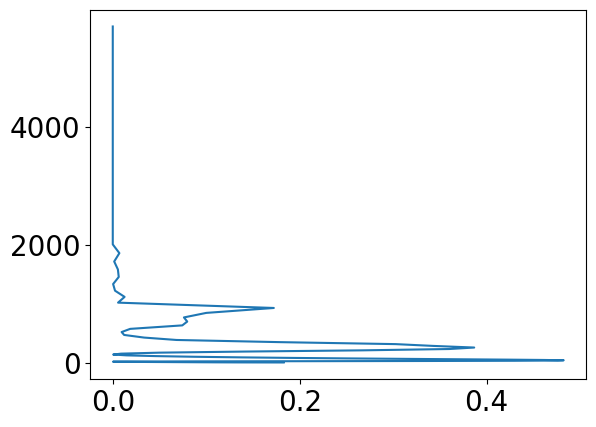

In [14]:
plt.plot(r_sq_depthav[:,i],  masked_u_along.depth)

In [15]:
# Import bathymetry
lat_slice = slice(-80, -59)
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()

In [16]:
# For polar projection
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Data required for lat/lon mapping
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

# Fontsize
ft_size = 16

In [17]:
lon_along_contour = CSHT_along.lon_along_contour
lat_along_contour = CSHT_along.lat_along_contour

Text(0.5, 0, 'Latitude')

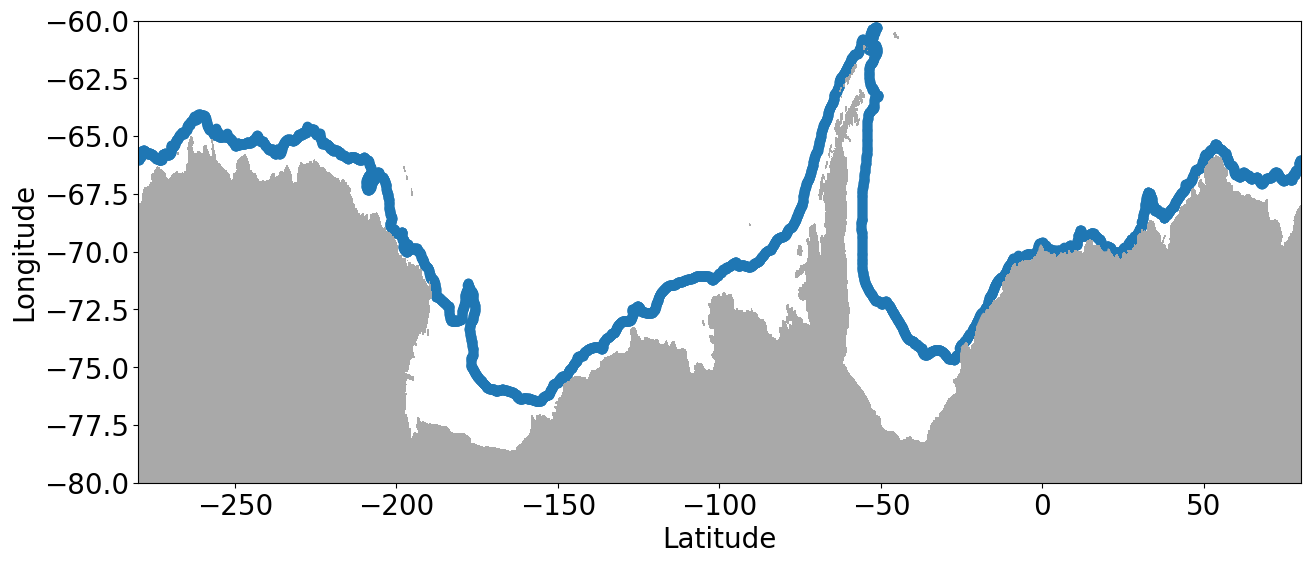

In [18]:
## Plot regions on antarctica ## USING 6002 CONTOUR INDEX
plt.figure(figsize = (15,6))
sc = plt.scatter(CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0), CSHT_along.lat_along_contour.isel(time = 0, st_ocean = 0))
plt.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
plt.plot(CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0), CSHT_along.lat_along_contour.isel(time = 0, st_ocean = -1))
plt.ylim([-80,-60])
plt.ylabel('Longitude')
plt.xlabel('Latitude')

In [19]:
## importing 5 deg binned circumpolar correlations
binned_corr = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/r_sq_all_5degBins.nc')
binned_corr_av = binned_corr.sel(depth = slice(600,1000)).mean(dim = 'depth')

In [20]:
CSHT_lon_along_contour = CSHT_along.lon_along_contour.isel(time = 0, st_ocean = 0).values
CSHT_lat_along_contour = CSHT_along.lat_along_contour.isel(time = 0, st_ocean = 0).values

In [21]:
binned_corr_lon_bins = binned_corr.lon_bins.values

In [22]:
%%time
## Takes a while! 
## improving the plotting by extrapolating 5 deg bins into original contour CSHT_lon_along_contour so plot is nicer
binned_corr_av_ext = np.zeros((len(CSHT_lon_along_contour),3))

n = 5 # no of degrees binning

XX = 0
for check_ll in range(len(CSHT_lon_along_contour)): # new longer lon
    print('ll = ', check_ll)
    for xx in range(XX, len(binned_corr_lon_bins)): # binned lon
        if (CSHT_lon_along_contour[check_ll] > binned_corr_lon_bins[xx] -n/2) & (CSHT_lon_along_contour[check_ll] < binned_corr_lon_bins[xx]+n/2 ):
            print('selecting', CSHT_lon_along_contour[check_ll] , binned_corr_lon_bins[xx])
            binned_corr_av_ext[check_ll,:] = binned_corr_av.isel(lon_bin_mid = xx).r_sq_all.values

ll =  0
ll =  1
ll =  2
ll =  3
ll =  4
ll =  5
ll =  6
ll =  7
ll =  8
ll =  9
ll =  10
ll =  11
ll =  12
ll =  13
ll =  14
ll =  15
ll =  16
ll =  17
ll =  18
ll =  19
ll =  20
ll =  21
ll =  22
ll =  23
ll =  24
ll =  25
selecting -278.49999999999966 -276.0
ll =  26
selecting -278.39999999999964 -276.0
ll =  27
selecting -278.39999999999964 -276.0
ll =  28
selecting -278.2999999999996 -276.0
ll =  29
selecting -278.1999999999996 -276.0
ll =  30
selecting -278.09999999999957 -276.0
ll =  31
selecting -277.99999999999955 -276.0
ll =  32
selecting -278.09999999999957 -276.0
ll =  33
selecting -277.8999999999995 -276.0
ll =  34
selecting -277.7999999999995 -276.0


2024-04-11 11:03:40,563 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1be0fce935cf824f299ff19e22e1785c', 0): 'waiting'}
2024-04-11 11:03:40,566 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1be0fce935cf824f299ff19e22e1785c', 0),)
2024-04-11 11:03:40,792 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1be0fce935cf824f299ff19e22e1785c', 0): 'waiting'}
2024-04-11 11:03:40,797 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1be0fce935cf824f299ff19e22e1785c', 0),)


ll =  35
selecting -277.6999999999995 -276.0
ll =  36
selecting -277.59999999999945 -276.0
ll =  37
selecting -277.6999999999995 -276.0
ll =  38
selecting -277.49999999999943 -276.0
ll =  39
selecting -277.3999999999994 -276.0
ll =  40
selecting -277.2999999999994 -276.0
ll =  41
selecting -277.19999999999936 -276.0
ll =  42
selecting -277.2999999999994 -276.0
ll =  43
selecting -277.09999999999934 -276.0
ll =  44
selecting -277.19999999999936 -276.0
ll =  45
selecting -276.9999999999993 -276.0
ll =  46
selecting -276.8999999999993 -276.0
ll =  47
selecting -276.7999999999993 -276.0
ll =  48
selecting -276.69999999999925 -276.0
ll =  49
selecting -276.5999999999992 -276.0
ll =  50
selecting -276.4999999999992 -276.0
ll =  51
selecting -276.4999999999992 -276.0


2024-04-11 11:03:41,138 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1be0fce935cf824f299ff19e22e1785c', 0): 'forgotten'}
2024-04-11 11:03:41,141 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1be0fce935cf824f299ff19e22e1785c', 0),)


ll =  52
selecting -276.3999999999992 -276.0
ll =  53
selecting -276.29999999999916 -276.0
ll =  54
selecting -276.19999999999914 -276.0
ll =  55
selecting -276.29999999999916 -276.0
ll =  56
selecting -276.0999999999991 -276.0
ll =  57
selecting -275.9999999999991 -276.0
ll =  58
selecting -275.89999999999907 -276.0
ll =  59
selecting -275.79999999999905 -276.0
ll =  60
selecting -275.699999999999 -276.0
ll =  61
selecting -275.599999999999 -276.0
ll =  62
selecting -275.699999999999 -276.0
ll =  63
selecting -275.499999999999 -276.0


2024-04-11 11:03:41,417 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1be0fce935cf824f299ff19e22e1785c', 0): 'forgotten'}
2024-04-11 11:03:41,420 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1be0fce935cf824f299ff19e22e1785c', 0),)


ll =  64
selecting -275.39999999999895 -276.0
ll =  65
selecting -275.29999999999893 -276.0
ll =  66
selecting -275.1999999999989 -276.0
ll =  67
selecting -275.29999999999893 -276.0
ll =  68
selecting -275.0999999999989 -276.0
ll =  69
selecting -275.1999999999989 -276.0
ll =  70
selecting -274.99999999999886 -276.0
ll =  71
selecting -274.89999999999884 -276.0
ll =  72
selecting -274.7999999999988 -276.0
ll =  73
selecting -274.6999999999988 -276.0
ll =  74
selecting -274.5999999999988 -276.0
ll =  75
selecting -274.49999999999875 -276.0
ll =  76
selecting -274.5999999999988 -276.0
ll =  77
selecting -274.3999999999987 -276.0
ll =  78
selecting -274.49999999999875 -276.0
ll =  79
selecting -274.2999999999987 -276.0
ll =  80
selecting -274.1999999999987 -276.0
ll =  81
selecting -274.1999999999987 -276.0
ll =  82
selecting -274.09999999999866 -276.0
ll =  83
selecting -273.99999999999864 -276.0
ll =  84
selecting -273.8999999999986 -276.0
ll =  85
selecting -273.7999999999986 -276.0
l

2024-04-11 11:03:42,375 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b08e7d8988a2a80dace9f5ff92d8186e', 0): 'waiting'}


ll =  91
selecting -273.3999999999985 -271.0
ll =  92
selecting -273.2999999999985 -271.0
ll =  93
selecting -273.3999999999985 -271.0
ll =  94
selecting -273.19999999999845 -271.0
ll =  95
selecting -273.09999999999843 -271.0
ll =  96
selecting -272.9999999999984 -271.0
ll =  97
selecting -272.8999999999984 -271.0
ll =  98
selecting -272.79999999999836 -271.0
ll =  99
selecting -272.79999999999836 -271.0
ll =  100
selecting -272.69999999999834 -271.0


2024-04-11 11:03:42,378 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b08e7d8988a2a80dace9f5ff92d8186e', 0),)


ll =  101
selecting -272.69999999999834 -271.0
ll =  102
selecting -272.5999999999983 -271.0
ll =  103
selecting -272.5999999999983 -271.0
ll =  104
selecting -272.4999999999983 -271.0
ll =  105
selecting -272.4999999999983 -271.0
ll =  106
selecting -272.4999999999983 -271.0
ll =  107
selecting -272.4999999999983 -271.0
ll =  108
selecting -272.3999999999983 -271.0


2024-04-11 11:03:42,735 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b08e7d8988a2a80dace9f5ff92d8186e', 0): 'waiting'}
2024-04-11 11:03:42,737 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b08e7d8988a2a80dace9f5ff92d8186e', 0),)


ll =  109
selecting -272.3999999999983 -271.0
ll =  110
selecting -272.29999999999825 -271.0
ll =  111
selecting -272.1999999999982 -271.0
ll =  112
selecting -272.0999999999982 -271.0
ll =  113
selecting -271.9999999999982 -271.0
ll =  114
selecting -271.89999999999816 -271.0
ll =  115
selecting -271.79999999999814 -271.0
ll =  116
selecting -271.6999999999981 -271.0
ll =  117
selecting -271.5999999999981 -271.0
ll =  118
selecting -271.5999999999981 -271.0
ll =  119
selecting -271.49999999999807 -271.0
ll =  120
selecting -271.39999999999804 -271.0
ll =  121
selecting -271.49999999999807 -271.0
ll =  122
selecting -271.299999999998 -271.0
ll =  123
selecting -271.199999999998 -271.0
ll =  124
selecting -271.099999999998 -271.0
ll =  125
selecting -270.99999999999795 -271.0
ll =  126
selecting -271.099999999998 -271.0
ll =  127
selecting -270.89999999999793 -271.0
ll =  128
selecting -270.7999999999979 -271.0
ll =  129
selecting -270.6999999999979 -271.0
ll =  130
selecting -270.59999

2024-04-11 11:03:44,255 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9a91cce128195bbeea78e88f0536cdea', 0): 'waiting'}
2024-04-11 11:03:44,259 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9a91cce128195bbeea78e88f0536cdea', 0),)


ll =  174
selecting -268.29999999999734 -266.0
ll =  175
selecting -268.1999999999973 -266.0
ll =  176
selecting -268.0999999999973 -266.0
ll =  177
selecting -267.99999999999727 -266.0
ll =  178
selecting -267.99999999999727 -266.0
ll =  179
selecting -267.89999999999725 -266.0
ll =  180
selecting -267.7999999999972 -266.0
ll =  181
selecting -267.6999999999972 -266.0
ll =  182
selecting -267.6999999999972 -266.0
ll =  183
selecting -267.5999999999972 -266.0
ll =  184
selecting -267.5999999999972 -266.0
ll =  185
selecting -267.49999999999716 -266.0


2024-04-11 11:03:44,475 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9a91cce128195bbeea78e88f0536cdea', 0): 'forgotten'}
2024-04-11 11:03:44,479 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9a91cce128195bbeea78e88f0536cdea', 0),)


ll =  186
selecting -267.39999999999714 -266.0
ll =  187
selecting -267.39999999999714 -266.0
ll =  188
selecting -267.2999999999971 -266.0
ll =  189
selecting -267.2999999999971 -266.0
ll =  190
selecting -267.1999999999971 -266.0
ll =  191
selecting -267.09999999999707 -266.0
ll =  192
selecting -266.99999999999704 -266.0
ll =  193
selecting -266.99999999999704 -266.0
ll =  194
selecting -266.899999999997 -266.0
ll =  195
selecting -266.799999999997 -266.0
ll =  196
selecting -266.699999999997 -266.0


2024-04-11 11:03:44,656 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9a91cce128195bbeea78e88f0536cdea', 0): 'waiting'}
2024-04-11 11:03:44,659 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9a91cce128195bbeea78e88f0536cdea', 0),)


ll =  197
selecting -266.59999999999695 -266.0
ll =  198
selecting -266.59999999999695 -266.0
ll =  199
selecting -266.59999999999695 -266.0
ll =  200
selecting -266.49999999999693 -266.0
ll =  201
selecting -266.3999999999969 -266.0
ll =  202
selecting -266.2999999999969 -266.0
ll =  203
selecting -266.19999999999686 -266.0
ll =  204
selecting -266.2999999999969 -266.0
ll =  205
selecting -266.09999999999684 -266.0
ll =  206
selecting -266.19999999999686 -266.0
ll =  207
selecting -265.9999999999968 -266.0
ll =  208
selecting -265.8999999999968 -266.0
ll =  209
selecting -265.79999999999677 -266.0
ll =  210
selecting -265.79999999999677 -266.0
ll =  211
selecting -265.69999999999675 -266.0
ll =  212
selecting -265.5999999999967 -266.0
ll =  213
selecting -265.5999999999967 -266.0
ll =  214
selecting -265.4999999999967 -266.0
ll =  215
selecting -265.4999999999967 -266.0
ll =  216
selecting -265.3999999999967 -266.0
ll =  217
selecting -265.29999999999666 -266.0
ll =  218
selecting -26

2024-04-11 11:03:45,640 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9a91cce128195bbeea78e88f0536cdea', 0): 'waiting'}
2024-04-11 11:03:45,644 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9a91cce128195bbeea78e88f0536cdea', 0),)


ll =  240
selecting -263.99999999999636 -266.0
ll =  241
selecting -263.89999999999634 -266.0
ll =  242
selecting -263.89999999999634 -266.0
ll =  243
selecting -263.7999999999963 -266.0
ll =  244
selecting -263.7999999999963 -266.0
ll =  245
selecting -263.6999999999963 -266.0
ll =  246
selecting -263.59999999999627 -266.0
ll =  247
selecting -263.49999999999625 -261.0
ll =  248
selecting -263.3999999999962 -261.0
ll =  249
selecting -263.2999999999962 -261.0
ll =  250
selecting -263.1999999999962 -261.0
ll =  251
selecting -263.1999999999962 -261.0
ll =  252
selecting -263.09999999999616 -261.0
ll =  253
selecting -262.99999999999613 -261.0
ll =  254
selecting -262.99999999999613 -261.0
ll =  255
selecting -262.99999999999613 -261.0
ll =  256
selecting -262.8999999999961 -261.0
ll =  257
selecting -262.7999999999961 -261.0
ll =  258
selecting -262.69999999999607 -261.0
ll =  259
selecting -262.59999999999604 -261.0
ll =  260
selecting -262.59999999999604 -261.0
ll =  261
selecting -2

2024-04-11 11:03:46,417 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c22840efd2e62719eca7c5971a548a02', 0): 'waiting'}
2024-04-11 11:03:46,419 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c22840efd2e62719eca7c5971a548a02', 0),)


ll =  269
selecting -262.19999999999595 -261.0
ll =  270
selecting -262.09999999999593 -261.0
ll =  271
selecting -262.09999999999593 -261.0
ll =  272
selecting -261.9999999999959 -261.0
ll =  273
selecting -261.8999999999959 -261.0
ll =  274
selecting -261.79999999999586 -261.0
ll =  275
selecting -261.69999999999584 -261.0
ll =  276
selecting -261.69999999999584 -261.0
ll =  277
selecting -261.5999999999958 -261.0
ll =  278
selecting -261.5999999999958 -261.0
ll =  279
selecting -261.5999999999958 -261.0


2024-04-11 11:03:46,641 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c22840efd2e62719eca7c5971a548a02', 0): 'waiting'}
2024-04-11 11:03:46,643 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c22840efd2e62719eca7c5971a548a02', 0),)


ll =  280
selecting -261.5999999999958 -261.0
ll =  281
selecting -261.5999999999958 -261.0
ll =  282
selecting -261.4999999999958 -261.0
ll =  283
selecting -261.39999999999577 -261.0
ll =  284
selecting -261.29999999999575 -261.0
ll =  285
selecting -261.39999999999577 -261.0
ll =  286
selecting -261.1999999999957 -261.0
ll =  287
selecting -261.0999999999957 -261.0
ll =  288
selecting -261.0999999999957 -261.0
ll =  289
selecting -260.9999999999957 -261.0
ll =  290
selecting -260.89999999999566 -261.0
ll =  291
selecting -260.79999999999563 -261.0
ll =  292
selecting -260.6999999999956 -261.0
ll =  293
selecting -260.5999999999956 -261.0
ll =  294
selecting -260.6999999999956 -261.0
ll =  295
selecting -260.49999999999557 -261.0
ll =  296
selecting -260.39999999999554 -261.0
ll =  297
selecting -260.2999999999955 -261.0
ll =  298
selecting -260.1999999999955 -261.0
ll =  299
selecting -260.0999999999955 -261.0
ll =  300
selecting -259.99999999999545 -261.0
ll =  301
selecting -259.8

2024-04-11 11:03:47,092 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c22840efd2e62719eca7c5971a548a02', 0): 'waiting'}
2024-04-11 11:03:47,094 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c22840efd2e62719eca7c5971a548a02', 0),)


ll =  302
selecting -259.7999999999954 -261.0
ll =  303
selecting -259.6999999999954 -261.0
ll =  304
selecting -259.59999999999536 -261.0
ll =  305
selecting -259.49999999999534 -261.0
ll =  306
selecting -259.59999999999536 -261.0
ll =  307
selecting -259.3999999999953 -261.0
ll =  308
selecting -259.2999999999953 -261.0
ll =  309
selecting -259.19999999999527 -261.0
ll =  310
selecting -259.09999999999525 -261.0
ll =  311
selecting -259.09999999999525 -261.0
ll =  312
selecting -258.9999999999952 -261.0
ll =  313
selecting -259.09999999999525 -261.0
ll =  314
selecting -258.9999999999952 -261.0
ll =  315
selecting -258.8999999999952 -261.0
ll =  316
selecting -258.9999999999952 -261.0
ll =  317
selecting -258.7999999999952 -261.0
ll =  318
selecting -258.8999999999952 -261.0
ll =  319
selecting -258.69999999999516 -261.0
ll =  320
selecting -258.7999999999952 -261.0
ll =  321
selecting -258.59999999999513 -261.0
ll =  322
selecting -258.69999999999516 -261.0
ll =  323
selecting -258

2024-04-11 11:03:47,589 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-534e17e59b5375e7205d469ba7828be4', 0): 'forgotten'}
2024-04-11 11:03:47,591 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-534e17e59b5375e7205d469ba7828be4', 0),)


ll =  326
selecting -258.3999999999951 -256.0
ll =  327
selecting -258.4999999999951 -256.0
ll =  328
selecting -258.29999999999507 -256.0
ll =  329
selecting -258.3999999999951 -256.0
ll =  330
selecting -258.19999999999504 -256.0
ll =  331
selecting -258.099999999995 -256.0
ll =  332
selecting -258.19999999999504 -256.0
ll =  333
selecting -257.999999999995 -256.0


2024-04-11 11:03:47,698 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-534e17e59b5375e7205d469ba7828be4', 0): 'forgotten'}
2024-04-11 11:03:47,701 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-534e17e59b5375e7205d469ba7828be4', 0),)
2024-04-11 11:03:47,782 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-534e17e59b5375e7205d469ba7828be4', 0): 'waiting'}
2024-04-11 11:03:47,784 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-534e17e59b5375e7205d469ba7828be4', 0),)


ll =  334
selecting -257.899999999995 -256.0
ll =  335
selecting -257.999999999995 -256.0
ll =  336
selecting -257.79999999999495 -256.0
ll =  337
selecting -257.899999999995 -256.0
ll =  338
selecting -257.69999999999493 -256.0
ll =  339
selecting -257.5999999999949 -256.0
ll =  340
selecting -257.4999999999949 -256.0
ll =  341
selecting -257.39999999999486 -256.0
ll =  342
selecting -257.29999999999484 -256.0
ll =  343
selecting -257.1999999999948 -256.0
ll =  344
selecting -257.0999999999948 -256.0
ll =  345
selecting -257.1999999999948 -256.0
ll =  346
selecting -256.99999999999477 -256.0
ll =  347
selecting -256.89999999999475 -256.0
ll =  348
selecting -256.99999999999477 -256.0
ll =  349
selecting -256.7999999999947 -256.0
ll =  350
selecting -256.89999999999475 -256.0
ll =  351
selecting -256.6999999999947 -256.0
ll =  352
selecting -256.5999999999947 -256.0
ll =  353
selecting -256.6999999999947 -256.0
ll =  354
selecting -256.49999999999466 -256.0


2024-04-11 11:03:48,244 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-534e17e59b5375e7205d469ba7828be4', 0): 'waiting'}
2024-04-11 11:03:48,249 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-534e17e59b5375e7205d469ba7828be4', 0),)


ll =  355
selecting -256.5999999999947 -256.0
ll =  356
selecting -256.39999999999463 -256.0
ll =  357
selecting -256.2999999999946 -256.0
ll =  358
selecting -256.1999999999946 -256.0
ll =  359
selecting -256.1999999999946 -256.0
ll =  360
selecting -256.1999999999946 -256.0
ll =  361
selecting -256.1999999999946 -256.0
ll =  362
selecting -256.09999999999457 -256.0
ll =  363
selecting -256.09999999999457 -256.0
ll =  364
selecting -256.09999999999457 -256.0
ll =  365
selecting -256.09999999999457 -256.0
ll =  366
selecting -255.99999999999457 -256.0
ll =  367
selecting -255.89999999999458 -256.0
ll =  368
selecting -255.89999999999458 -256.0


2024-04-11 11:03:48,463 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-534e17e59b5375e7205d469ba7828be4', 0): 'waiting'}
2024-04-11 11:03:48,466 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-534e17e59b5375e7205d469ba7828be4', 0),)


ll =  369
selecting -255.79999999999458 -256.0
ll =  370
selecting -255.79999999999458 -256.0
ll =  371
selecting -255.6999999999946 -256.0
ll =  372
selecting -255.79999999999458 -256.0
ll =  373
selecting -255.5999999999946 -256.0
ll =  374
selecting -255.6999999999946 -256.0
ll =  375
selecting -255.4999999999946 -256.0
ll =  376
selecting -255.5999999999946 -256.0
ll =  377
selecting -255.3999999999946 -256.0
ll =  378
selecting -255.2999999999946 -256.0


2024-04-11 11:03:48,590 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-534e17e59b5375e7205d469ba7828be4', 0): 'forgotten'}
2024-04-11 11:03:48,593 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-534e17e59b5375e7205d469ba7828be4', 0),)


ll =  379
selecting -255.19999999999462 -256.0
ll =  380
selecting -255.19999999999462 -256.0
ll =  381
selecting -255.19999999999462 -256.0
ll =  382
selecting -255.09999999999462 -256.0
ll =  383
selecting -255.19999999999462 -256.0
ll =  384
selecting -254.99999999999463 -256.0
ll =  385
selecting -255.09999999999462 -256.0
ll =  386
selecting -254.89999999999463 -256.0
ll =  387
selecting -254.99999999999463 -256.0
ll =  388
selecting -254.79999999999464 -256.0
ll =  389
selecting -254.69999999999465 -256.0
ll =  390
selecting -254.59999999999465 -256.0
ll =  391
selecting -254.49999999999466 -256.0
ll =  392
selecting -254.39999999999466 -256.0
ll =  393
selecting -254.29999999999467 -256.0
ll =  394
selecting -254.29999999999467 -256.0
ll =  395
selecting -254.19999999999467 -256.0
ll =  396
selecting -254.09999999999468 -256.0
ll =  397
selecting -254.19999999999467 -256.0
ll =  398
selecting -253.99999999999469 -256.0
ll =  399
selecting -253.8999999999947 -256.0
ll =  400
sele

2024-04-11 11:03:50,378 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ce7c5da1b3ff2b43e015ae7312b9c071', 0): 'waiting'}
2024-04-11 11:03:50,381 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ce7c5da1b3ff2b43e015ae7312b9c071', 0),)


ll =  460
selecting -249.69999999999493 -251.0
ll =  461
selecting -249.59999999999494 -251.0
ll =  462
selecting -249.59999999999494 -251.0
ll =  463
selecting -249.49999999999494 -251.0
ll =  464
selecting -249.49999999999494 -251.0
ll =  465
selecting -249.39999999999495 -251.0
ll =  466
selecting -249.29999999999495 -251.0
ll =  467
selecting -249.39999999999495 -251.0
ll =  468
selecting -249.19999999999496 -251.0
ll =  469
selecting -249.09999999999496 -251.0
ll =  470
selecting -249.09999999999496 -251.0
ll =  471
selecting -249.09999999999496 -251.0
ll =  472
selecting -248.99999999999497 -251.0
ll =  473
selecting -248.89999999999498 -251.0
ll =  474
selecting -248.89999999999498 -251.0
ll =  475
selecting -248.79999999999498 -251.0
ll =  476
selecting -248.89999999999498 -251.0
ll =  477
selecting -248.699999999995 -251.0
ll =  478
selecting -248.599999999995 -251.0
ll =  479
selecting -248.499999999995 -246.0
ll =  480
selecting -248.499999999995 -246.0
ll =  481
selecting -

2024-04-11 11:03:52,213 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0ba28981f72495071a0bf46fc2c868af', 0): 'waiting'}
2024-04-11 11:03:52,216 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0ba28981f72495071a0bf46fc2c868af', 0),)


ll =  489
selecting -247.59999999999505 -246.0
ll =  490
selecting -247.49999999999505 -246.0
ll =  491
selecting -247.39999999999506 -246.0
ll =  492
selecting -247.29999999999507 -246.0
ll =  493
selecting -247.19999999999507 -246.0
ll =  494
selecting -247.09999999999508 -246.0
ll =  495
selecting -246.99999999999508 -246.0
ll =  496
selecting -246.8999999999951 -246.0
ll =  497
selecting -246.7999999999951 -246.0
ll =  498
selecting -246.7999999999951 -246.0
ll =  499
selecting -246.6999999999951 -246.0
ll =  500
selecting -246.5999999999951 -246.0
ll =  501
selecting -246.4999999999951 -246.0
ll =  502
selecting -246.39999999999512 -246.0
ll =  503
selecting -246.29999999999512 -246.0
ll =  504
selecting -246.29999999999512 -246.0
ll =  505
selecting -246.19999999999513 -246.0
ll =  506
selecting -246.09999999999513 -246.0
ll =  507
selecting -245.99999999999514 -246.0
ll =  508
selecting -245.89999999999515 -246.0
ll =  509
selecting -245.99999999999514 -246.0
ll =  510
selecting

2024-04-11 11:03:53,735 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f347b14c66d4d37f0d1dddb1c292d3e2', 0): 'waiting'}
2024-04-11 11:03:53,739 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f347b14c66d4d37f0d1dddb1c292d3e2', 0),)
2024-04-11 11:03:53,832 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f347b14c66d4d37f0d1dddb1c292d3e2', 0): 'forgotten'}


ll =  545
selecting -243.1999999999953 -241.0
ll =  546
selecting -243.1999999999953 -241.0
ll =  547
selecting -243.0999999999953 -241.0
ll =  548
selecting -242.9999999999953 -241.0
ll =  549
selecting -242.89999999999532 -241.0
ll =  550
selecting -242.9999999999953 -241.0
ll =  551
selecting -242.79999999999532 -241.0
ll =  552
selecting -242.89999999999532 -241.0
ll =  553
selecting -242.69999999999533 -241.0
ll =  554
selecting -242.79999999999532 -241.0
ll =  555
selecting -242.59999999999533 -241.0
ll =  556
selecting -242.69999999999533 -241.0


2024-04-11 11:03:53,835 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f347b14c66d4d37f0d1dddb1c292d3e2', 0),)


ll =  557
selecting -242.49999999999534 -241.0
ll =  558
selecting -242.59999999999533 -241.0
ll =  559
selecting -242.39999999999534 -241.0
ll =  560
selecting -242.29999999999535 -241.0
ll =  561
selecting -242.19999999999536 -241.0
ll =  562
selecting -242.09999999999536 -241.0
ll =  563
selecting -242.19999999999536 -241.0
ll =  564
selecting -241.99999999999537 -241.0


2024-04-11 11:03:54,191 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f347b14c66d4d37f0d1dddb1c292d3e2', 0): 'forgotten'}
2024-04-11 11:03:54,194 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f347b14c66d4d37f0d1dddb1c292d3e2', 0),)


ll =  565
selecting -241.89999999999537 -241.0
ll =  566
selecting -241.99999999999537 -241.0
ll =  567
selecting -241.79999999999538 -241.0
ll =  568
selecting -241.69999999999538 -241.0
ll =  569
selecting -241.5999999999954 -241.0
ll =  570
selecting -241.5999999999954 -241.0
ll =  571
selecting -241.4999999999954 -241.0
ll =  572
selecting -241.3999999999954 -241.0
ll =  573
selecting -241.2999999999954 -241.0
ll =  574
selecting -241.1999999999954 -241.0
ll =  575
selecting -241.2999999999954 -241.0
ll =  576
selecting -241.09999999999542 -241.0
ll =  577
selecting -241.1999999999954 -241.0
ll =  578
selecting -240.99999999999542 -241.0
ll =  579
selecting -240.89999999999543 -241.0
ll =  580
selecting -240.79999999999544 -241.0
ll =  581
selecting -240.89999999999543 -241.0
ll =  582
selecting -240.69999999999544 -241.0
ll =  583
selecting -240.79999999999544 -241.0
ll =  584
selecting -240.59999999999545 -241.0
ll =  585
selecting -240.69999999999544 -241.0
ll =  586
selecting -

2024-04-11 11:03:55,679 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-346c37ee13a0bff222f1947ac46d1120', 0): 'waiting'}
2024-04-11 11:03:55,683 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-346c37ee13a0bff222f1947ac46d1120', 0),)


ll =  634
selecting -237.09999999999565 -236.0
ll =  635
selecting -237.09999999999565 -236.0
ll =  636
selecting -236.99999999999565 -236.0
ll =  637
selecting -236.89999999999566 -236.0
ll =  638
selecting -236.99999999999565 -236.0
ll =  639
selecting -236.89999999999566 -236.0
ll =  640
selecting -236.89999999999566 -236.0
ll =  641
selecting -236.79999999999566 -236.0
ll =  642
selecting -236.89999999999566 -236.0
ll =  643
selecting -236.69999999999567 -236.0
ll =  644
selecting -236.59999999999567 -236.0
ll =  645
selecting -236.49999999999568 -236.0
ll =  646
selecting -236.39999999999569 -236.0
ll =  647
selecting -236.2999999999957 -236.0
ll =  648
selecting -236.39999999999569 -236.0
ll =  649
selecting -236.1999999999957 -236.0
ll =  650
selecting -236.0999999999957 -236.0
ll =  651
selecting -235.9999999999957 -236.0
ll =  652
selecting -235.9999999999957 -236.0
ll =  653
selecting -235.8999999999957 -236.0


2024-04-11 11:03:56,156 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-346c37ee13a0bff222f1947ac46d1120', 0): 'waiting'}
2024-04-11 11:03:56,158 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-346c37ee13a0bff222f1947ac46d1120', 0),)
2024-04-11 11:03:56,278 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-346c37ee13a0bff222f1947ac46d1120', 0): 'forgotten'}
2024-04-11 11:03:56,283 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-346c37ee13a0bff222f1947ac46d1120', 0),)


ll =  654
selecting -235.79999999999572 -236.0
ll =  655
selecting -235.79999999999572 -236.0
ll =  656
selecting -235.79999999999572 -236.0
ll =  657
selecting -235.69999999999573 -236.0
ll =  658
selecting -235.69999999999573 -236.0
ll =  659
selecting -235.59999999999573 -236.0
ll =  660
selecting -235.49999999999574 -236.0
ll =  661
selecting -235.49999999999574 -236.0
ll =  662
selecting -235.49999999999574 -236.0
ll =  663
selecting -235.49999999999574 -236.0


2024-04-11 11:03:56,356 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-346c37ee13a0bff222f1947ac46d1120', 0): 'waiting'}
2024-04-11 11:03:56,359 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-346c37ee13a0bff222f1947ac46d1120', 0),)


ll =  664
selecting -235.39999999999574 -236.0
ll =  665
selecting -235.39999999999574 -236.0
ll =  666
selecting -235.29999999999575 -236.0
ll =  667
selecting -235.19999999999575 -236.0
ll =  668
selecting -235.09999999999576 -236.0
ll =  669
selecting -235.09999999999576 -236.0
ll =  670
selecting -234.99999999999577 -236.0
ll =  671
selecting -234.99999999999577 -236.0
ll =  672
selecting -234.89999999999577 -236.0
ll =  673
selecting -234.79999999999578 -236.0
ll =  674
selecting -234.79999999999578 -236.0
ll =  675
selecting -234.69999999999578 -236.0
ll =  676
selecting -234.69999999999578 -236.0
ll =  677
selecting -234.5999999999958 -236.0
ll =  678
selecting -234.4999999999958 -236.0
ll =  679
selecting -234.4999999999958 -236.0
ll =  680
selecting -234.3999999999958 -236.0
ll =  681
selecting -234.2999999999958 -236.0
ll =  682
selecting -234.1999999999958 -236.0
ll =  683
selecting -234.1999999999958 -236.0
ll =  684
selecting -234.09999999999582 -236.0
ll =  685
selecting 

2024-04-11 11:03:57,388 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ecb272a934fc6093eb63613770c9991c', 0): 'forgotten'}
2024-04-11 11:03:57,391 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ecb272a934fc6093eb63613770c9991c', 0),)
2024-04-11 11:03:57,484 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ecb272a934fc6093eb63613770c9991c', 0): 'forgotten'}
2024-04-11 11:03:57,488 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ecb272a934fc6093eb63613770c9991c', 0),)


ll =  700
selecting -232.7999999999959 -231.0
ll =  701
selecting -232.6999999999959 -231.0
ll =  702
selecting -232.7999999999959 -231.0
ll =  703
selecting -232.5999999999959 -231.0
ll =  704
selecting -232.4999999999959 -231.0
ll =  705
selecting -232.3999999999959 -231.0
ll =  706
selecting -232.29999999999592 -231.0
ll =  707
selecting -232.19999999999592 -231.0
ll =  708
selecting -232.29999999999592 -231.0
ll =  709
selecting -232.09999999999593 -231.0


2024-04-11 11:03:57,683 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ecb272a934fc6093eb63613770c9991c', 0): 'waiting'}
2024-04-11 11:03:57,687 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ecb272a934fc6093eb63613770c9991c', 0),)


ll =  710
selecting -231.99999999999594 -231.0
ll =  711
selecting -231.89999999999594 -231.0
ll =  712
selecting -231.79999999999595 -231.0
ll =  713
selecting -231.79999999999595 -231.0
ll =  714
selecting -231.69999999999595 -231.0
ll =  715
selecting -231.59999999999596 -231.0
ll =  716
selecting -231.49999999999596 -231.0
ll =  717
selecting -231.39999999999597 -231.0
ll =  718
selecting -231.39999999999597 -231.0
ll =  719
selecting -231.29999999999598 -231.0


2024-04-11 11:03:57,889 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ecb272a934fc6093eb63613770c9991c', 0): 'waiting'}
2024-04-11 11:03:57,892 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ecb272a934fc6093eb63613770c9991c', 0),)


ll =  720
selecting -231.19999999999598 -231.0
ll =  721
selecting -231.19999999999598 -231.0
ll =  722
selecting -231.099999999996 -231.0
ll =  723
selecting -230.999999999996 -231.0
ll =  724
selecting -230.899999999996 -231.0
ll =  725
selecting -230.799999999996 -231.0
ll =  726
selecting -230.699999999996 -231.0
ll =  727
selecting -230.699999999996 -231.0
ll =  728
selecting -230.59999999999602 -231.0
ll =  729
selecting -230.59999999999602 -231.0


2024-04-11 11:03:58,084 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ecb272a934fc6093eb63613770c9991c', 0): 'forgotten'}
2024-04-11 11:03:58,088 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ecb272a934fc6093eb63613770c9991c', 0),)


ll =  730
selecting -230.49999999999602 -231.0
ll =  731
selecting -230.49999999999602 -231.0
ll =  732
selecting -230.39999999999603 -231.0
ll =  733
selecting -230.29999999999603 -231.0
ll =  734
selecting -230.29999999999603 -231.0
ll =  735
selecting -230.19999999999604 -231.0
ll =  736
selecting -230.09999999999604 -231.0
ll =  737
selecting -229.99999999999605 -231.0
ll =  738
selecting -229.89999999999606 -231.0
ll =  739
selecting -229.99999999999605 -231.0
ll =  740
selecting -229.79999999999606 -231.0
ll =  741
selecting -229.69999999999607 -231.0
ll =  742
selecting -229.59999999999607 -231.0
ll =  743
selecting -229.49999999999608 -231.0
ll =  744
selecting -229.39999999999608 -231.0
ll =  745
selecting -229.2999999999961 -231.0
ll =  746
selecting -229.1999999999961 -231.0
ll =  747
selecting -229.1999999999961 -231.0


2024-04-11 11:03:58,491 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ecb272a934fc6093eb63613770c9991c', 0): 'forgotten'}
2024-04-11 11:03:58,494 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ecb272a934fc6093eb63613770c9991c', 0),)


ll =  748
selecting -229.0999999999961 -231.0
ll =  749
selecting -229.0999999999961 -231.0
ll =  750
selecting -229.0999999999961 -231.0
ll =  751
selecting -228.9999999999961 -231.0
ll =  752
selecting -228.8999999999961 -231.0
ll =  753
selecting -228.79999999999612 -231.0
ll =  754
selecting -228.69999999999612 -231.0
ll =  755
selecting -228.79999999999612 -231.0
ll =  756
selecting -228.59999999999613 -231.0
ll =  757
selecting -228.49999999999613 -226.0
ll =  758
selecting -228.39999999999614 -226.0
ll =  759
selecting -228.29999999999615 -226.0
ll =  760
selecting -228.19999999999615 -226.0
ll =  761
selecting -228.09999999999616 -226.0
ll =  762
selecting -227.99999999999616 -226.0
ll =  763
selecting -227.99999999999616 -226.0
ll =  764
selecting -227.89999999999617 -226.0
ll =  765
selecting -227.89999999999617 -226.0
ll =  766
selecting -227.89999999999617 -226.0
ll =  767
selecting -227.89999999999617 -226.0
ll =  768
selecting -227.89999999999617 -226.0
ll =  769
selectin

2024-04-11 11:03:59,093 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9ec48aaca373f3453d8c9dcce4ea7f1a', 0): 'forgotten'}
2024-04-11 11:03:59,097 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9ec48aaca373f3453d8c9dcce4ea7f1a', 0),)
2024-04-11 11:03:59,193 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9ec48aaca373f3453d8c9dcce4ea7f1a', 0): 'waiting'}
2024-04-11 11:03:59,195 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9ec48aaca373f3453d8c9dcce4ea7f1a', 0),)


ll =  778
selecting -227.2999999999962 -226.0
ll =  779
selecting -227.3999999999962 -226.0
ll =  780
selecting -227.1999999999962 -226.0
ll =  781
selecting -227.2999999999962 -226.0
ll =  782
selecting -227.09999999999621 -226.0
ll =  783
selecting -226.99999999999622 -226.0
ll =  784
selecting -226.89999999999623 -226.0
ll =  785
selecting -226.89999999999623 -226.0
ll =  786
selecting -226.79999999999623 -226.0
ll =  787
selecting -226.69999999999624 -226.0
ll =  788
selecting -226.79999999999623 -226.0
ll =  789
selecting -226.59999999999624 -226.0
ll =  790
selecting -226.49999999999625 -226.0


2024-04-11 11:03:59,405 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9ec48aaca373f3453d8c9dcce4ea7f1a', 0): 'forgotten'}
2024-04-11 11:03:59,411 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9ec48aaca373f3453d8c9dcce4ea7f1a', 0),)


ll =  791
selecting -226.39999999999625 -226.0
ll =  792
selecting -226.29999999999626 -226.0
ll =  793
selecting -226.29999999999626 -226.0
ll =  794
selecting -226.19999999999627 -226.0
ll =  795
selecting -226.09999999999627 -226.0
ll =  796
selecting -225.99999999999628 -226.0
ll =  797
selecting -225.89999999999628 -226.0
ll =  798
selecting -225.7999999999963 -226.0
ll =  799
selecting -225.6999999999963 -226.0
ll =  800
selecting -225.5999999999963 -226.0
ll =  801
selecting -225.5999999999963 -226.0
ll =  802
selecting -225.4999999999963 -226.0
ll =  803
selecting -225.5999999999963 -226.0
ll =  804
selecting -225.3999999999963 -226.0
ll =  805
selecting -225.4999999999963 -226.0
ll =  806
selecting -225.29999999999632 -226.0
ll =  807
selecting -225.19999999999632 -226.0
ll =  808
selecting -225.09999999999633 -226.0
ll =  809
selecting -225.19999999999632 -226.0
ll =  810
selecting -224.99999999999633 -226.0
ll =  811
selecting -224.89999999999634 -226.0
ll =  812
selecting -

2024-04-11 11:04:00,906 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d4ab22de61a8291d0c36ad6f7f2f9855', 0): 'forgotten'}
2024-04-11 11:04:00,910 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d4ab22de61a8291d0c36ad6f7f2f9855', 0),)


ll =  863
selecting -221.69999999999652 -221.0
ll =  864
selecting -221.69999999999652 -221.0
ll =  865
selecting -221.59999999999653 -221.0
ll =  866
selecting -221.49999999999653 -221.0
ll =  867
selecting -221.39999999999654 -221.0
ll =  868
selecting -221.29999999999654 -221.0
ll =  869
selecting -221.39999999999654 -221.0
ll =  870
selecting -221.19999999999655 -221.0
ll =  871
selecting -221.09999999999656 -221.0


2024-04-11 11:04:01,132 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d4ab22de61a8291d0c36ad6f7f2f9855', 0): 'forgotten'}
2024-04-11 11:04:01,136 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d4ab22de61a8291d0c36ad6f7f2f9855', 0),)
2024-04-11 11:04:01,214 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d4ab22de61a8291d0c36ad6f7f2f9855', 0): 'waiting'}
2024-04-11 11:04:01,217 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d4ab22de61a8291d0c36ad6f7f2f9855', 0),)


ll =  872
selecting -220.99999999999656 -221.0
ll =  873
selecting -221.09999999999656 -221.0
ll =  874
selecting -220.89999999999657 -221.0
ll =  875
selecting -220.79999999999657 -221.0
ll =  876
selecting -220.69999999999658 -221.0
ll =  877
selecting -220.79999999999657 -221.0
ll =  878
selecting -220.59999999999658 -221.0
ll =  879
selecting -220.4999999999966 -221.0
ll =  880
selecting -220.59999999999658 -221.0
ll =  881
selecting -220.3999999999966 -221.0
ll =  882
selecting -220.4999999999966 -221.0
ll =  883
selecting -220.2999999999966 -221.0


2024-04-11 11:04:01,354 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d4ab22de61a8291d0c36ad6f7f2f9855', 0): 'waiting'}
2024-04-11 11:04:01,359 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d4ab22de61a8291d0c36ad6f7f2f9855', 0),)
2024-04-11 11:04:01,435 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d4ab22de61a8291d0c36ad6f7f2f9855', 0): 'waiting'}
2024-04-11 11:04:01,439 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d4ab22de61a8291d0c36ad6f7f2f9855', 0),)


ll =  884
selecting -220.1999999999966 -221.0
ll =  885
selecting -220.0999999999966 -221.0
ll =  886
selecting -219.99999999999662 -221.0
ll =  887
selecting -219.89999999999662 -221.0
ll =  888
selecting -219.99999999999662 -221.0
ll =  889
selecting -219.79999999999663 -221.0
ll =  890
selecting -219.69999999999663 -221.0
ll =  891
selecting -219.79999999999663 -221.0
ll =  892
selecting -219.59999999999664 -221.0
ll =  893
selecting -219.49999999999665 -221.0
ll =  894
selecting -219.49999999999665 -221.0
ll =  895
selecting -219.49999999999665 -221.0


2024-04-11 11:04:01,597 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d4ab22de61a8291d0c36ad6f7f2f9855', 0): 'forgotten'}
2024-04-11 11:04:01,600 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d4ab22de61a8291d0c36ad6f7f2f9855', 0),)


ll =  896
selecting -219.39999999999665 -221.0
ll =  897
selecting -219.29999999999666 -221.0
ll =  898
selecting -219.39999999999665 -221.0
ll =  899
selecting -219.19999999999666 -221.0
ll =  900
selecting -219.09999999999667 -221.0
ll =  901
selecting -218.99999999999667 -221.0
ll =  902
selecting -219.09999999999667 -221.0
ll =  903
selecting -218.89999999999668 -221.0
ll =  904
selecting -218.7999999999967 -221.0
ll =  905
selecting -218.6999999999967 -221.0
ll =  906
selecting -218.5999999999967 -221.0
ll =  907
selecting -218.4999999999967 -216.0
ll =  908
selecting -218.4999999999967 -216.0
ll =  909
selecting -218.3999999999967 -216.0
ll =  910
selecting -218.29999999999671 -216.0
ll =  911
selecting -218.3999999999967 -216.0
ll =  912
selecting -218.19999999999672 -216.0
ll =  913
selecting -218.09999999999673 -216.0
ll =  914
selecting -217.99999999999673 -216.0
ll =  915
selecting -217.89999999999674 -216.0
ll =  916
selecting -217.99999999999673 -216.0
ll =  917
selecting 

2024-04-11 11:04:02,154 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-62fcf85385d37af7f05bb613eaa935bc', 0): 'waiting'}
2024-04-11 11:04:02,156 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-62fcf85385d37af7f05bb613eaa935bc', 0),)


ll =  920
selecting -217.49999999999676 -216.0
ll =  921
selecting -217.59999999999675 -216.0
ll =  922
selecting -217.39999999999677 -216.0
ll =  923
selecting -217.39999999999677 -216.0
ll =  924
selecting -217.29999999999677 -216.0
ll =  925
selecting -217.39999999999677 -216.0
ll =  926
selecting -217.19999999999678 -216.0
ll =  927
selecting -217.09999999999678 -216.0
ll =  928
selecting -216.9999999999968 -216.0
ll =  929
selecting -216.8999999999968 -216.0
ll =  930
selecting -216.7999999999968 -216.0


2024-04-11 11:04:02,345 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-62fcf85385d37af7f05bb613eaa935bc', 0): 'forgotten'}
2024-04-11 11:04:02,352 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-62fcf85385d37af7f05bb613eaa935bc', 0),)


ll =  931
selecting -216.6999999999968 -216.0
ll =  932
selecting -216.5999999999968 -216.0
ll =  933
selecting -216.49999999999682 -216.0
ll =  934
selecting -216.39999999999682 -216.0
ll =  935
selecting -216.29999999999683 -216.0
ll =  936
selecting -216.19999999999683 -216.0
ll =  937
selecting -216.09999999999684 -216.0
ll =  938
selecting -216.19999999999683 -216.0
ll =  939
selecting -215.99999999999685 -216.0
ll =  940
selecting -215.89999999999685 -216.0
ll =  941
selecting -215.99999999999685 -216.0
ll =  942
selecting -215.79999999999686 -216.0
ll =  943
selecting -215.69999999999686 -216.0
ll =  944
selecting -215.59999999999687 -216.0
ll =  945
selecting -215.49999999999687 -216.0
ll =  946
selecting -215.59999999999687 -216.0
ll =  947
selecting -215.39999999999688 -216.0
ll =  948
selecting -215.29999999999688 -216.0
ll =  949
selecting -215.1999999999969 -216.0
ll =  950
selecting -215.0999999999969 -216.0
ll =  951
selecting -215.1999999999969 -216.0
ll =  952
selectin

2024-04-11 11:04:02,920 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-62fcf85385d37af7f05bb613eaa935bc', 0): 'forgotten'}
2024-04-11 11:04:02,924 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-62fcf85385d37af7f05bb613eaa935bc', 0),)


ll =  960
selecting -214.39999999999694 -216.0
ll =  961
selecting -214.29999999999694 -216.0
ll =  962
selecting -214.19999999999695 -216.0
ll =  963
selecting -214.09999999999695 -216.0
ll =  964
selecting -213.99999999999696 -216.0
ll =  965
selecting -213.89999999999696 -216.0
ll =  966
selecting -213.79999999999697 -216.0
ll =  967
selecting -213.69999999999698 -216.0
ll =  968
selecting -213.59999999999698 -216.0
ll =  969
selecting -213.499999999997 -211.0
ll =  970
selecting -213.399999999997 -211.0
ll =  971
selecting -213.299999999997 -211.0
ll =  972
selecting -213.199999999997 -211.0
ll =  973
selecting -213.099999999997 -211.0
ll =  974
selecting -212.99999999999702 -211.0
ll =  975
selecting -212.89999999999702 -211.0
ll =  976
selecting -212.79999999999703 -211.0
ll =  977
selecting -212.69999999999703 -211.0
ll =  978
selecting -212.59999999999704 -211.0
ll =  979
selecting -212.69999999999703 -211.0


2024-04-11 11:04:03,360 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c803e4ec445460bb48cc04704759326d', 0): 'waiting'}
2024-04-11 11:04:03,362 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c803e4ec445460bb48cc04704759326d', 0),)


ll =  980
selecting -212.49999999999704 -211.0
ll =  981
selecting -212.39999999999705 -211.0
ll =  982
selecting -212.29999999999706 -211.0
ll =  983
selecting -212.39999999999705 -211.0
ll =  984
selecting -212.19999999999706 -211.0
ll =  985
selecting -212.09999999999707 -211.0
ll =  986
selecting -211.99999999999707 -211.0
ll =  987
selecting -211.89999999999708 -211.0
ll =  988
selecting -211.79999999999708 -211.0
ll =  989
selecting -211.6999999999971 -211.0
ll =  990
selecting -211.79999999999708 -211.0
ll =  991
selecting -211.5999999999971 -211.0
ll =  992
selecting -211.4999999999971 -211.0
ll =  993
selecting -211.3999999999971 -211.0
ll =  994
selecting -211.2999999999971 -211.0
ll =  995
selecting -211.2999999999971 -211.0
ll =  996
selecting -211.19999999999712 -211.0
ll =  997
selecting -211.09999999999712 -211.0
ll =  998
selecting -210.99999999999713 -211.0
ll =  999
selecting -211.09999999999712 -211.0
ll =  1000
selecting -210.89999999999714 -211.0
ll =  1001
selecti

2024-04-11 11:04:04,487 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c803e4ec445460bb48cc04704759326d', 0): 'forgotten'}
2024-04-11 11:04:04,495 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c803e4ec445460bb48cc04704759326d', 0),)


ll =  1027
selecting -208.89999999999725 -211.0
ll =  1028
selecting -208.79999999999725 -211.0
ll =  1029
selecting -208.69999999999726 -211.0
ll =  1030
selecting -208.59999999999727 -211.0
ll =  1031
selecting -208.69999999999726 -211.0
ll =  1032
selecting -208.59999999999727 -211.0
ll =  1033
selecting -208.49999999999727 -206.0
ll =  1034
selecting -208.59999999999727 -211.0
ll =  1035
selecting -208.39999999999728 -206.0
ll =  1036
selecting -208.49999999999727 -206.0
ll =  1037
selecting -208.29999999999728 -206.0
ll =  1038
selecting -208.39999999999728 -206.0
ll =  1039
selecting -208.1999999999973 -206.0
ll =  1040
selecting -208.29999999999728 -206.0
ll =  1041
selecting -208.0999999999973 -206.0
ll =  1042
selecting -207.9999999999973 -206.0
ll =  1043
selecting -208.0999999999973 -206.0
ll =  1044
selecting -207.8999999999973 -206.0
ll =  1045
selecting -207.9999999999973 -206.0
ll =  1046
selecting -207.8999999999973 -206.0
ll =  1047
selecting -207.8999999999973 -206.0


2024-04-11 11:04:05,151 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-37170068df1e508d0bd37ac119d25082', 0): 'forgotten'}
2024-04-11 11:04:05,155 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-37170068df1e508d0bd37ac119d25082', 0),)


ll =  1053
selecting -208.0999999999973 -206.0
ll =  1054
selecting -208.0999999999973 -206.0
ll =  1055
selecting -208.1999999999973 -206.0
ll =  1056
selecting -208.29999999999728 -206.0
ll =  1057
selecting -208.29999999999728 -206.0
ll =  1058
selecting -208.39999999999728 -206.0
ll =  1059
selecting -208.49999999999727 -206.0
ll =  1060
selecting -208.59999999999727 -211.0
ll =  1061
selecting -208.69999999999726 -211.0
ll =  1062
selecting -208.69999999999726 -211.0
ll =  1063
selecting -208.79999999999725 -211.0
ll =  1064
selecting -208.89999999999725 -211.0
ll =  1065
selecting -208.89999999999725 -211.0
ll =  1066
selecting -208.99999999999724 -211.0
ll =  1067
selecting -208.99999999999724 -211.0
ll =  1068
selecting -209.09999999999724 -211.0
ll =  1069
selecting -209.09999999999724 -211.0
ll =  1070
selecting -209.19999999999723 -211.0
ll =  1071
selecting -209.19999999999723 -211.0
ll =  1072
selecting -209.29999999999723 -211.0
ll =  1073
selecting -209.29999999999723 -2

2024-04-11 11:04:06,086 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-37170068df1e508d0bd37ac119d25082', 0): 'forgotten'}
2024-04-11 11:04:06,089 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-37170068df1e508d0bd37ac119d25082', 0),)


ll =  1090
selecting -208.59999999999727 -211.0
ll =  1091
selecting -208.49999999999727 -206.0
ll =  1092
selecting -208.39999999999728 -206.0
ll =  1093
selecting -208.39999999999728 -206.0
ll =  1094
selecting -208.29999999999728 -206.0
ll =  1095
selecting -208.1999999999973 -206.0
ll =  1096
selecting -208.1999999999973 -206.0
ll =  1097
selecting -208.0999999999973 -206.0
ll =  1098
selecting -207.9999999999973 -206.0
ll =  1099
selecting -207.9999999999973 -206.0
ll =  1100
selecting -207.8999999999973 -206.0
ll =  1101
selecting -207.8999999999973 -206.0
ll =  1102
selecting -207.7999999999973 -206.0
ll =  1103
selecting -207.7999999999973 -206.0
ll =  1104
selecting -207.69999999999732 -206.0
ll =  1105
selecting -207.69999999999732 -206.0
ll =  1106
selecting -207.59999999999732 -206.0
ll =  1107
selecting -207.59999999999732 -206.0
ll =  1108
selecting -207.49999999999733 -206.0
ll =  1109
selecting -207.39999999999733 -206.0
ll =  1110
selecting -207.39999999999733 -206.0


2024-04-11 11:04:06,407 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-37170068df1e508d0bd37ac119d25082', 0): 'forgotten'}
2024-04-11 11:04:06,410 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-37170068df1e508d0bd37ac119d25082', 0),)


ll =  1111
selecting -207.29999999999734 -206.0
ll =  1112
selecting -207.29999999999734 -206.0
ll =  1113
selecting -207.19999999999735 -206.0
ll =  1114
selecting -207.09999999999735 -206.0
ll =  1115
selecting -207.09999999999735 -206.0
ll =  1116
selecting -206.99999999999736 -206.0
ll =  1117
selecting -206.89999999999736 -206.0
ll =  1118
selecting -206.89999999999736 -206.0
ll =  1119
selecting -206.79999999999737 -206.0
ll =  1120
selecting -206.69999999999737 -206.0
ll =  1121
selecting -206.69999999999737 -206.0
ll =  1122
selecting -206.59999999999738 -206.0
ll =  1123
selecting -206.49999999999739 -206.0
ll =  1124
selecting -206.49999999999739 -206.0
ll =  1125
selecting -206.3999999999974 -206.0
ll =  1126
selecting -206.3999999999974 -206.0
ll =  1127
selecting -206.2999999999974 -206.0
ll =  1128
selecting -206.2999999999974 -206.0
ll =  1129
selecting -206.1999999999974 -206.0
ll =  1130
selecting -206.1999999999974 -206.0
ll =  1131
selecting -206.0999999999974 -206.0

2024-04-11 11:04:07,006 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-37170068df1e508d0bd37ac119d25082', 0): 'waiting'}
2024-04-11 11:04:07,009 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-37170068df1e508d0bd37ac119d25082', 0),)
2024-04-11 11:04:07,185 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-37170068df1e508d0bd37ac119d25082', 0): 'forgotten'}
2024-04-11 11:04:07,189 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-37170068df1e508d0bd37ac119d25082', 0),)


ll =  1139
selecting -205.49999999999744 -206.0
ll =  1140
selecting -205.39999999999745 -206.0
ll =  1141
selecting -205.49999999999744 -206.0
ll =  1142
selecting -205.29999999999745 -206.0
ll =  1143
selecting -205.39999999999745 -206.0
ll =  1144
selecting -205.19999999999746 -206.0
ll =  1145
selecting -205.29999999999745 -206.0
ll =  1146
selecting -205.09999999999746 -206.0
ll =  1147
selecting -205.19999999999746 -206.0
ll =  1148
selecting -204.99999999999747 -206.0
ll =  1149
selecting -204.89999999999748 -206.0
ll =  1150
selecting -204.99999999999747 -206.0
ll =  1151
selecting -204.79999999999748 -206.0
ll =  1152
selecting -204.6999999999975 -206.0
ll =  1153
selecting -204.5999999999975 -206.0
ll =  1154
selecting -204.4999999999975 -206.0
ll =  1155
selecting -204.3999999999975 -206.0
ll =  1156
selecting -204.2999999999975 -206.0
ll =  1157
selecting -204.19999999999752 -206.0
ll =  1158
selecting -204.09999999999752 -206.0
ll =  1159
selecting -203.99999999999753 -206

2024-04-11 11:04:08,103 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0): 'forgotten'}
2024-04-11 11:04:08,108 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0),)


ll =  1175
selecting -203.29999999999757 -201.0
ll =  1176
selecting -203.09999999999758 -201.0
ll =  1177
selecting -203.19999999999757 -201.0
ll =  1178
selecting -203.09999999999758 -201.0
ll =  1179
selecting -203.09999999999758 -201.0
ll =  1180
selecting -203.09999999999758 -201.0
ll =  1181
selecting -203.09999999999758 -201.0
ll =  1182
selecting -202.99999999999758 -201.0
ll =  1183
selecting -203.09999999999758 -201.0
ll =  1184
selecting -202.99999999999758 -201.0
ll =  1185
selecting -202.8999999999976 -201.0
ll =  1186
selecting -202.99999999999758 -201.0


2024-04-11 11:04:08,284 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0): 'forgotten'}
2024-04-11 11:04:08,289 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0),)


ll =  1187
selecting -202.7999999999976 -201.0
ll =  1188
selecting -202.6999999999976 -201.0
ll =  1189
selecting -202.7999999999976 -201.0
ll =  1190
selecting -202.6999999999976 -201.0
ll =  1191
selecting -202.5999999999976 -201.0
ll =  1192
selecting -202.6999999999976 -201.0
ll =  1193
selecting -202.5999999999976 -201.0
ll =  1194
selecting -202.4999999999976 -201.0
ll =  1195
selecting -202.5999999999976 -201.0
ll =  1196
selecting -202.39999999999762 -201.0
ll =  1197
selecting -202.4999999999976 -201.0
ll =  1198
selecting -202.39999999999762 -201.0
ll =  1199
selecting -202.39999999999762 -201.0
ll =  1200
selecting -202.39999999999762 -201.0
ll =  1201
selecting -202.39999999999762 -201.0
ll =  1202
selecting -202.29999999999762 -201.0
ll =  1203
selecting -202.39999999999762 -201.0
ll =  1204
selecting -202.29999999999762 -201.0
ll =  1205
selecting -202.29999999999762 -201.0
ll =  1206
selecting -202.29999999999762 -201.0
ll =  1207
selecting -202.29999999999762 -201.0
ll

2024-04-11 11:04:09,032 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0): 'forgotten'}
2024-04-11 11:04:09,036 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0),)
2024-04-11 11:04:09,270 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0): 'waiting'}
2024-04-11 11:04:09,273 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0),)


ll =  1229
selecting -201.59999999999766 -201.0
ll =  1230
selecting -201.59999999999766 -201.0
ll =  1231
selecting -201.59999999999766 -201.0
ll =  1232
selecting -201.69999999999766 -201.0
ll =  1233
selecting -201.69999999999766 -201.0
ll =  1234
selecting -201.69999999999766 -201.0
ll =  1235
selecting -201.79999999999765 -201.0
ll =  1236
selecting -201.89999999999765 -201.0
ll =  1237
selecting -201.99999999999764 -201.0
ll =  1238
selecting -202.09999999999764 -201.0
ll =  1239
selecting -202.09999999999764 -201.0


2024-04-11 11:04:09,437 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0): 'waiting'}
2024-04-11 11:04:09,442 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0),)


ll =  1240
selecting -201.99999999999764 -201.0
ll =  1241
selecting -202.09999999999764 -201.0
ll =  1242
selecting -201.89999999999765 -201.0
ll =  1243
selecting -201.79999999999765 -201.0
ll =  1244
selecting -201.89999999999765 -201.0
ll =  1245
selecting -201.69999999999766 -201.0
ll =  1246
selecting -201.59999999999766 -201.0
ll =  1247
selecting -201.69999999999766 -201.0
ll =  1248
selecting -201.49999999999767 -201.0
ll =  1249
selecting -201.39999999999768 -201.0


2024-04-11 11:04:09,597 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0): 'forgotten'}
2024-04-11 11:04:09,600 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0),)


ll =  1250
selecting -201.29999999999768 -201.0
ll =  1251
selecting -201.39999999999768 -201.0
ll =  1252
selecting -201.1999999999977 -201.0
ll =  1253
selecting -201.0999999999977 -201.0
ll =  1254
selecting -200.9999999999977 -201.0
ll =  1255
selecting -200.8999999999977 -201.0
ll =  1256
selecting -200.7999999999977 -201.0
ll =  1257
selecting -200.69999999999771 -201.0
ll =  1258
selecting -200.59999999999772 -201.0
ll =  1259
selecting -200.49999999999773 -201.0
ll =  1260
selecting -200.59999999999772 -201.0


2024-04-11 11:04:09,731 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0): 'waiting'}
2024-04-11 11:04:09,733 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0),)
2024-04-11 11:04:09,827 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0): 'forgotten'}
2024-04-11 11:04:09,831 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a3068557ef8dfb166b30fbdc34d2ba64', 0),)


ll =  1261
selecting -200.39999999999773 -201.0
ll =  1262
selecting -200.49999999999773 -201.0
ll =  1263
selecting -200.29999999999774 -201.0
ll =  1264
selecting -200.39999999999773 -201.0
ll =  1265
selecting -200.19999999999774 -201.0
ll =  1266
selecting -200.09999999999775 -201.0
ll =  1267
selecting -200.19999999999774 -201.0
ll =  1268
selecting -199.99999999999775 -201.0
ll =  1269
selecting -199.89999999999776 -201.0
ll =  1270
selecting -199.79999999999777 -201.0
ll =  1271
selecting -199.69999999999777 -201.0
ll =  1272
selecting -199.59999999999778 -201.0
ll =  1273
selecting -199.69999999999777 -201.0
ll =  1274
selecting -199.49999999999778 -201.0
ll =  1275
selecting -199.3999999999978 -201.0
ll =  1276
selecting -199.2999999999978 -201.0
ll =  1277
selecting -199.1999999999978 -201.0
ll =  1278
selecting -199.0999999999978 -201.0
ll =  1279
selecting -198.9999999999978 -201.0
ll =  1280
selecting -198.89999999999782 -201.0
ll =  1281
selecting -198.9999999999978 -201.

2024-04-11 11:04:10,686 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0): 'waiting'}
2024-04-11 11:04:10,689 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0),)
2024-04-11 11:04:10,752 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0): 'forgotten'}
2024-04-11 11:04:10,755 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0),)


ll =  1298
selecting -198.19999999999786 -196.0
ll =  1299
selecting -198.29999999999785 -196.0
ll =  1300
selecting -198.19999999999786 -196.0
ll =  1301
selecting -198.29999999999785 -196.0
ll =  1302
selecting -198.19999999999786 -196.0
ll =  1303
selecting -198.09999999999786 -196.0
ll =  1304
selecting -198.19999999999786 -196.0
ll =  1305
selecting -197.99999999999787 -196.0
ll =  1306
selecting -197.89999999999787 -196.0
ll =  1307
selecting -197.79999999999788 -196.0
ll =  1308
selecting -197.69999999999789 -196.0
ll =  1309
selecting -197.5999999999979 -196.0
ll =  1310
selecting -197.4999999999979 -196.0
ll =  1311
selecting -197.5999999999979 -196.0
ll =  1312
selecting -197.4999999999979 -196.0
ll =  1313
selecting -197.4999999999979 -196.0
ll =  1314
selecting -197.4999999999979 -196.0
ll =  1315
selecting -197.4999999999979 -196.0
ll =  1316
selecting -197.5999999999979 -196.0
ll =  1317
selecting -197.5999999999979 -196.0
ll =  1318
selecting -197.69999999999789 -196.0
l

2024-04-11 11:04:11,333 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0): 'forgotten'}
2024-04-11 11:04:11,338 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0),)


ll =  1333
selecting -197.09999999999792 -196.0
ll =  1334
selecting -197.1999999999979 -196.0
ll =  1335
selecting -196.99999999999793 -196.0
ll =  1336
selecting -196.89999999999793 -196.0
ll =  1337
selecting -196.99999999999793 -196.0
ll =  1338
selecting -196.79999999999794 -196.0
ll =  1339
selecting -196.69999999999794 -196.0
ll =  1340
selecting -196.59999999999795 -196.0
ll =  1341
selecting -196.59999999999795 -196.0
ll =  1342
selecting -196.49999999999795 -196.0


2024-04-11 11:04:11,587 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0): 'forgotten'}
2024-04-11 11:04:11,590 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0),)


ll =  1343
selecting -196.49999999999795 -196.0
ll =  1344
selecting -196.49999999999795 -196.0
ll =  1345
selecting -196.49999999999795 -196.0
ll =  1346
selecting -196.49999999999795 -196.0
ll =  1347
selecting -196.49999999999795 -196.0
ll =  1348
selecting -196.59999999999795 -196.0
ll =  1349
selecting -196.59999999999795 -196.0
ll =  1350
selecting -196.59999999999795 -196.0
ll =  1351
selecting -196.49999999999795 -196.0
ll =  1352
selecting -196.39999999999796 -196.0
ll =  1353
selecting -196.29999999999797 -196.0
ll =  1354
selecting -196.39999999999796 -196.0
ll =  1355
selecting -196.29999999999797 -196.0
ll =  1356
selecting -196.19999999999797 -196.0
ll =  1357
selecting -196.29999999999797 -196.0
ll =  1358
selecting -196.09999999999798 -196.0
ll =  1359
selecting -195.99999999999798 -196.0
ll =  1360
selecting -195.899999999998 -196.0
ll =  1361
selecting -195.99999999999798 -196.0
ll =  1362
selecting -195.799999999998 -196.0
ll =  1363
selecting -195.899999999998 -196.

2024-04-11 11:04:11,869 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0): 'forgotten'}
2024-04-11 11:04:11,873 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0),)
2024-04-11 11:04:12,094 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0): 'forgotten'}
2024-04-11 11:04:12,097 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0),)


ll =  1367
selecting -195.39999999999802 -196.0
ll =  1368
selecting -195.29999999999802 -196.0
ll =  1369
selecting -195.19999999999803 -196.0
ll =  1370
selecting -195.09999999999803 -196.0
ll =  1371
selecting -194.99999999999804 -196.0
ll =  1372
selecting -194.89999999999804 -196.0
ll =  1373
selecting -194.89999999999804 -196.0
ll =  1374
selecting -194.79999999999805 -196.0


2024-04-11 11:04:12,276 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0): 'forgotten'}
2024-04-11 11:04:12,280 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-e4fbc2b1c87df63a782742aecfc817bb', 0),)


ll =  1375
selecting -194.69999999999806 -196.0
ll =  1376
selecting -194.59999999999806 -196.0
ll =  1377
selecting -194.49999999999807 -196.0
ll =  1378
selecting -194.39999999999807 -196.0
ll =  1379
selecting -194.29999999999808 -196.0
ll =  1380
selecting -194.19999999999808 -196.0
ll =  1381
selecting -194.29999999999808 -196.0
ll =  1382
selecting -194.0999999999981 -196.0
ll =  1383
selecting -193.9999999999981 -196.0
ll =  1384
selecting -193.9999999999981 -196.0
ll =  1385
selecting -193.8999999999981 -196.0
ll =  1386
selecting -193.7999999999981 -196.0
ll =  1387
selecting -193.6999999999981 -196.0
ll =  1388
selecting -193.59999999999812 -196.0
ll =  1389
selecting -193.49999999999812 -191.0
ll =  1390
selecting -193.59999999999812 -196.0
ll =  1391
selecting -193.39999999999813 -191.0


2024-04-11 11:04:12,749 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-55669a02b5914cae6624a992e72208e2', 0): 'waiting'}
2024-04-11 11:04:12,753 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-55669a02b5914cae6624a992e72208e2', 0),)


ll =  1392
selecting -193.49999999999812 -191.0
ll =  1393
selecting -193.29999999999814 -191.0
ll =  1394
selecting -193.19999999999814 -191.0
ll =  1395
selecting -193.29999999999814 -191.0
ll =  1396
selecting -193.09999999999815 -191.0
ll =  1397
selecting -193.19999999999814 -191.0
ll =  1398
selecting -192.99999999999815 -191.0
ll =  1399
selecting -192.89999999999816 -191.0
ll =  1400
selecting -192.79999999999816 -191.0
ll =  1401
selecting -192.69999999999817 -191.0


2024-04-11 11:04:12,884 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-55669a02b5914cae6624a992e72208e2', 0): 'forgotten'}
2024-04-11 11:04:12,888 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-55669a02b5914cae6624a992e72208e2', 0),)


ll =  1402
selecting -192.79999999999816 -191.0
ll =  1403
selecting -192.59999999999818 -191.0
ll =  1404
selecting -192.49999999999818 -191.0
ll =  1405
selecting -192.59999999999818 -191.0
ll =  1406
selecting -192.49999999999818 -191.0
ll =  1407
selecting -192.3999999999982 -191.0
ll =  1408
selecting -192.49999999999818 -191.0
ll =  1409
selecting -192.2999999999982 -191.0
ll =  1410
selecting -192.3999999999982 -191.0
ll =  1411
selecting -192.1999999999982 -191.0
ll =  1412
selecting -192.2999999999982 -191.0
ll =  1413
selecting -192.0999999999982 -191.0
ll =  1414
selecting -192.1999999999982 -191.0
ll =  1415
selecting -191.9999999999982 -191.0
ll =  1416
selecting -191.89999999999822 -191.0
ll =  1417
selecting -191.79999999999822 -191.0
ll =  1418
selecting -191.69999999999823 -191.0
ll =  1419
selecting -191.79999999999822 -191.0
ll =  1420
selecting -191.69999999999823 -191.0
ll =  1421
selecting -191.59999999999823 -191.0
ll =  1422
selecting -191.69999999999823 -191.0


2024-04-11 11:04:13,562 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-55669a02b5914cae6624a992e72208e2', 0): 'waiting'}
2024-04-11 11:04:13,565 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-55669a02b5914cae6624a992e72208e2', 0),)


ll =  1431
selecting -190.99999999999827 -191.0
ll =  1432
selecting -191.09999999999826 -191.0
ll =  1433
selecting -190.89999999999827 -191.0
ll =  1434
selecting -190.79999999999828 -191.0
ll =  1435
selecting -190.69999999999828 -191.0
ll =  1436
selecting -190.79999999999828 -191.0
ll =  1437
selecting -190.5999999999983 -191.0
ll =  1438
selecting -190.4999999999983 -191.0
ll =  1439
selecting -190.3999999999983 -191.0


2024-04-11 11:04:13,810 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-55669a02b5914cae6624a992e72208e2', 0): 'forgotten'}
2024-04-11 11:04:13,815 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-55669a02b5914cae6624a992e72208e2', 0),)


ll =  1440
selecting -190.2999999999983 -191.0
ll =  1441
selecting -190.3999999999983 -191.0
ll =  1442
selecting -190.1999999999983 -191.0
ll =  1443
selecting -190.09999999999832 -191.0
ll =  1444
selecting -190.09999999999832 -191.0
ll =  1445
selecting -189.99999999999832 -191.0
ll =  1446
selecting -190.09999999999832 -191.0
ll =  1447
selecting -189.99999999999832 -191.0
ll =  1448
selecting -189.89999999999833 -191.0
ll =  1449
selecting -189.99999999999832 -191.0
ll =  1450
selecting -189.89999999999833 -191.0
ll =  1451
selecting -189.79999999999833 -191.0
ll =  1452
selecting -189.89999999999833 -191.0
ll =  1453
selecting -189.69999999999834 -191.0
ll =  1454
selecting -189.59999999999835 -191.0
ll =  1455
selecting -189.59999999999835 -191.0
ll =  1456
selecting -189.49999999999835 -191.0
ll =  1457
selecting -189.59999999999835 -191.0
ll =  1458
selecting -189.49999999999835 -191.0
ll =  1459
selecting -189.49999999999835 -191.0


2024-04-11 11:04:14,197 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-55669a02b5914cae6624a992e72208e2', 0): 'forgotten'}
2024-04-11 11:04:14,202 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-55669a02b5914cae6624a992e72208e2', 0),)
2024-04-11 11:04:14,277 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-55669a02b5914cae6624a992e72208e2', 0): 'forgotten'}
2024-04-11 11:04:14,280 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-55669a02b5914cae6624a992e72208e2', 0),)


ll =  1460
selecting -189.39999999999836 -191.0
ll =  1461
selecting -189.49999999999835 -191.0
ll =  1462
selecting -189.29999999999836 -191.0
ll =  1463
selecting -189.19999999999837 -191.0
ll =  1464
selecting -189.19999999999837 -191.0
ll =  1465
selecting -189.09999999999837 -191.0
ll =  1466
selecting -188.99999999999838 -191.0
ll =  1467
selecting -189.09999999999837 -191.0
ll =  1468
selecting -188.89999999999839 -191.0
ll =  1469
selecting -188.7999999999984 -191.0
ll =  1470
selecting -188.6999999999984 -191.0
ll =  1471
selecting -188.7999999999984 -191.0
ll =  1472
selecting -188.5999999999984 -191.0
ll =  1473
selecting -188.6999999999984 -191.0
ll =  1474
selecting -188.4999999999984 -186.0
ll =  1475
selecting -188.3999999999984 -186.0
ll =  1476
selecting -188.4999999999984 -186.0
ll =  1477
selecting -188.29999999999842 -186.0
ll =  1478
selecting -188.3999999999984 -186.0


2024-04-11 11:04:14,673 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c81073f902952eba35587fefd944c423', 0): 'forgotten'}
2024-04-11 11:04:14,676 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c81073f902952eba35587fefd944c423', 0),)


ll =  1479
selecting -188.19999999999843 -186.0
ll =  1480
selecting -188.29999999999842 -186.0
ll =  1481
selecting -188.09999999999843 -186.0
ll =  1482
selecting -187.99999999999844 -186.0
ll =  1483
selecting -188.09999999999843 -186.0
ll =  1484
selecting -187.99999999999844 -186.0
ll =  1485
selecting -187.89999999999844 -186.0
ll =  1486
selecting -187.99999999999844 -186.0
ll =  1487
selecting -187.89999999999844 -186.0


2024-04-11 11:04:14,905 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c81073f902952eba35587fefd944c423', 0): 'forgotten'}
2024-04-11 11:04:14,908 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c81073f902952eba35587fefd944c423', 0),)


ll =  1488
selecting -187.79999999999845 -186.0
ll =  1489
selecting -187.89999999999844 -186.0
ll =  1490
selecting -187.79999999999845 -186.0
ll =  1491
selecting -187.79999999999845 -186.0
ll =  1492
selecting -187.79999999999845 -186.0
ll =  1493
selecting -187.79999999999845 -186.0
ll =  1494
selecting -187.79999999999845 -186.0
ll =  1495
selecting -187.79999999999845 -186.0
ll =  1496
selecting -187.79999999999845 -186.0
ll =  1497
selecting -187.79999999999845 -186.0
ll =  1498
selecting -187.69999999999845 -186.0
ll =  1499
selecting -187.79999999999845 -186.0
ll =  1500
selecting -187.59999999999846 -186.0
ll =  1501
selecting -187.49999999999847 -186.0
ll =  1502
selecting -187.39999999999847 -186.0
ll =  1503
selecting -187.29999999999848 -186.0
ll =  1504
selecting -187.19999999999848 -186.0
ll =  1505
selecting -187.0999999999985 -186.0
ll =  1506
selecting -186.9999999999985 -186.0
ll =  1507
selecting -186.8999999999985 -186.0
ll =  1508
selecting -186.7999999999985 -18

2024-04-11 11:04:15,418 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c81073f902952eba35587fefd944c423', 0): 'forgotten'}
2024-04-11 11:04:15,421 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c81073f902952eba35587fefd944c423', 0),)
2024-04-11 11:04:15,503 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c81073f902952eba35587fefd944c423', 0): 'forgotten'}
2024-04-11 11:04:15,506 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c81073f902952eba35587fefd944c423', 0),)


ll =  1516
selecting -186.19999999999854 -186.0
ll =  1517
selecting -186.29999999999853 -186.0
ll =  1518
selecting -186.09999999999854 -186.0
ll =  1519
selecting -185.99999999999855 -186.0
ll =  1520
selecting -185.89999999999856 -186.0
ll =  1521
selecting -185.99999999999855 -186.0
ll =  1522
selecting -185.79999999999856 -186.0
ll =  1523
selecting -185.69999999999857 -186.0
ll =  1524
selecting -185.59999999999857 -186.0
ll =  1525
selecting -185.69999999999857 -186.0
ll =  1526
selecting -185.49999999999858 -186.0
ll =  1527
selecting -185.39999999999858 -186.0
ll =  1528
selecting -185.2999999999986 -186.0
ll =  1529
selecting -185.1999999999986 -186.0
ll =  1530
selecting -185.2999999999986 -186.0
ll =  1531
selecting -185.0999999999986 -186.0
ll =  1532
selecting -184.9999999999986 -186.0
ll =  1533
selecting -184.8999999999986 -186.0
ll =  1534
selecting -184.79999999999862 -186.0
ll =  1535
selecting -184.8999999999986 -186.0
ll =  1536
selecting -184.69999999999862 -186.0

2024-04-11 11:04:16,003 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c81073f902952eba35587fefd944c423', 0): 'forgotten'}
2024-04-11 11:04:16,006 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c81073f902952eba35587fefd944c423', 0),)


ll =  1539
selecting -184.59999999999863 -186.0
ll =  1540
selecting -184.39999999999864 -186.0
ll =  1541
selecting -184.29999999999865 -186.0
ll =  1542
selecting -184.39999999999864 -186.0
ll =  1543
selecting -184.19999999999865 -186.0
ll =  1544
selecting -184.09999999999866 -186.0
ll =  1545
selecting -183.99999999999866 -186.0
ll =  1546
selecting -183.89999999999867 -186.0
ll =  1547
selecting -183.79999999999868 -186.0
ll =  1548
selecting -183.69999999999868 -186.0
ll =  1549
selecting -183.79999999999868 -186.0
ll =  1550
selecting -183.69999999999868 -186.0
ll =  1551
selecting -183.69999999999868 -186.0
ll =  1552
selecting -183.69999999999868 -186.0
ll =  1553
selecting -183.5999999999987 -186.0
ll =  1554
selecting -183.69999999999868 -186.0
ll =  1555
selecting -183.5999999999987 -186.0
ll =  1556
selecting -183.5999999999987 -186.0
ll =  1557
selecting -183.5999999999987 -186.0
ll =  1558
selecting -183.5999999999987 -186.0
ll =  1559
selecting -183.4999999999987 -181.

2024-04-11 11:04:16,932 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-2b300fc71cc8d48277431a6a4a51c3af', 0): 'forgotten'}
2024-04-11 11:04:16,935 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-2b300fc71cc8d48277431a6a4a51c3af', 0),)


ll =  1594
selecting -180.99999999999883 -181.0
ll =  1595
selecting -180.89999999999884 -181.0
ll =  1596
selecting -180.79999999999885 -181.0
ll =  1597
selecting -180.79999999999885 -181.0
ll =  1598
selecting -180.69999999999885 -181.0
ll =  1599
selecting -180.59999999999886 -181.0
ll =  1600
selecting -180.49999999999886 -181.0
ll =  1601
selecting -180.39999999999887 -181.0
ll =  1602
selecting -180.29999999999887 -181.0
ll =  1603
selecting -180.19999999999888 -181.0
ll =  1604
selecting -180.0999999999989 -181.0
ll =  1605
selecting -180.0999999999989 -181.0
ll =  1606
selecting -179.9999999999989 -181.0
ll =  1607
selecting -179.8999999999989 -181.0
ll =  1608
selecting -179.7999999999989 -181.0
ll =  1609
selecting -179.6999999999989 -181.0
ll =  1610
selecting -179.6999999999989 -181.0
ll =  1611
selecting -179.59999999999891 -181.0
ll =  1612
selecting -179.59999999999891 -181.0
ll =  1613
selecting -179.59999999999891 -181.0
ll =  1614
selecting -179.59999999999891 -181.0

2024-04-11 11:04:18,692 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'waiting'}
2024-04-11 11:04:18,695 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)


ll =  1666
selecting -177.899999999999 -176.0
ll =  1667
selecting -177.899999999999 -176.0
ll =  1668
selecting -177.79999999999902 -176.0
ll =  1669
selecting -177.69999999999902 -176.0
ll =  1670
selecting -177.69999999999902 -176.0
ll =  1671
selecting -177.69999999999902 -176.0
ll =  1672
selecting -177.59999999999903 -176.0
ll =  1673
selecting -177.69999999999902 -176.0
ll =  1674
selecting -177.49999999999903 -176.0
ll =  1675
selecting -177.39999999999904 -176.0
ll =  1676
selecting -177.49999999999903 -176.0
ll =  1677
selecting -177.29999999999905 -176.0
ll =  1678
selecting -177.39999999999904 -176.0
ll =  1679
selecting -177.29999999999905 -176.0
ll =  1680
selecting -177.19999999999905 -176.0
ll =  1681
selecting -177.29999999999905 -176.0
ll =  1682
selecting -177.09999999999906 -176.0
ll =  1683
selecting -176.99999999999906 -176.0
ll =  1684
selecting -177.09999999999906 -176.0
ll =  1685
selecting -176.89999999999907 -176.0
ll =  1686
selecting -176.79999999999907 -17

2024-04-11 11:04:19,345 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'forgotten'}
2024-04-11 11:04:19,349 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)


ll =  1705
selecting -176.0999999999991 -176.0
ll =  1706
selecting -176.1999999999991 -176.0
ll =  1707
selecting -175.99999999999912 -176.0
ll =  1708
selecting -176.0999999999991 -176.0
ll =  1709
selecting -175.89999999999912 -176.0
ll =  1710
selecting -175.99999999999912 -176.0
ll =  1711
selecting -175.79999999999913 -176.0
ll =  1712
selecting -175.89999999999912 -176.0
ll =  1713
selecting -175.79999999999913 -176.0
ll =  1714
selecting -175.79999999999913 -176.0
ll =  1715
selecting -175.69999999999914 -176.0


2024-04-11 11:04:19,684 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'forgotten'}
2024-04-11 11:04:19,690 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)


ll =  1716
selecting -175.79999999999913 -176.0
ll =  1717
selecting -175.69999999999914 -176.0
ll =  1718
selecting -175.69999999999914 -176.0
ll =  1719
selecting -175.69999999999914 -176.0
ll =  1720
selecting -175.79999999999913 -176.0
ll =  1721
selecting -175.79999999999913 -176.0
ll =  1722
selecting -175.79999999999913 -176.0
ll =  1723
selecting -175.89999999999912 -176.0
ll =  1724
selecting -175.89999999999912 -176.0
ll =  1725
selecting -175.99999999999912 -176.0
ll =  1726
selecting -175.99999999999912 -176.0
ll =  1727
selecting -176.0999999999991 -176.0
ll =  1728
selecting -176.0999999999991 -176.0
ll =  1729
selecting -176.1999999999991 -176.0
ll =  1730
selecting -176.1999999999991 -176.0
ll =  1731
selecting -176.1999999999991 -176.0
ll =  1732
selecting -176.2999999999991 -176.0
ll =  1733
selecting -176.2999999999991 -176.0
ll =  1734
selecting -176.2999999999991 -176.0
ll =  1735
selecting -176.3999999999991 -176.0
ll =  1736
selecting -176.3999999999991 -176.0
ll

2024-04-11 11:04:20,095 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'waiting'}
2024-04-11 11:04:20,100 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)
2024-04-11 11:04:20,166 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'waiting'}
2024-04-11 11:04:20,169 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)


ll =  1738
selecting -176.4999999999991 -176.0
ll =  1739
selecting -176.59999999999908 -176.0
ll =  1740
selecting -176.59999999999908 -176.0
ll =  1741
selecting -176.69999999999908 -176.0
ll =  1742
selecting -176.79999999999907 -176.0
ll =  1743
selecting -176.79999999999907 -176.0
ll =  1744
selecting -176.89999999999907 -176.0
ll =  1745
selecting -176.99999999999906 -176.0
ll =  1746
selecting -176.99999999999906 -176.0
ll =  1747
selecting -177.09999999999906 -176.0
ll =  1748
selecting -177.09999999999906 -176.0
ll =  1749
selecting -177.19999999999905 -176.0
ll =  1750
selecting -177.19999999999905 -176.0
ll =  1751
selecting -177.29999999999905 -176.0
ll =  1752
selecting -177.29999999999905 -176.0
ll =  1753
selecting -177.29999999999905 -176.0
ll =  1754
selecting -177.39999999999904 -176.0
ll =  1755
selecting -177.39999999999904 -176.0
ll =  1756
selecting -177.29999999999905 -176.0
ll =  1757
selecting -177.39999999999904 -176.0
ll =  1758
selecting -177.29999999999905 

2024-04-11 11:04:20,757 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'waiting'}
2024-04-11 11:04:20,759 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)


ll =  1765
selecting -176.99999999999906 -176.0
ll =  1766
selecting -177.09999999999906 -176.0
ll =  1767
selecting -176.89999999999907 -176.0
ll =  1768
selecting -176.99999999999906 -176.0
ll =  1769
selecting -176.89999999999907 -176.0
ll =  1770
selecting -176.89999999999907 -176.0
ll =  1771
selecting -176.79999999999907 -176.0
ll =  1772
selecting -176.89999999999907 -176.0
ll =  1773
selecting -176.69999999999908 -176.0
ll =  1774
selecting -176.79999999999907 -176.0
ll =  1775
selecting -176.69999999999908 -176.0


2024-04-11 11:04:20,985 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'forgotten'}
2024-04-11 11:04:20,989 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)
2024-04-11 11:04:21,080 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'waiting'}
2024-04-11 11:04:21,083 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)


ll =  1776
selecting -176.59999999999908 -176.0
ll =  1777
selecting -176.69999999999908 -176.0
ll =  1778
selecting -176.59999999999908 -176.0
ll =  1779
selecting -176.4999999999991 -176.0
ll =  1780
selecting -176.59999999999908 -176.0
ll =  1781
selecting -176.4999999999991 -176.0
ll =  1782
selecting -176.4999999999991 -176.0
ll =  1783
selecting -176.3999999999991 -176.0
ll =  1784
selecting -176.4999999999991 -176.0
ll =  1785
selecting -176.2999999999991 -176.0
ll =  1786
selecting -176.3999999999991 -176.0
ll =  1787
selecting -176.2999999999991 -176.0
ll =  1788
selecting -176.2999999999991 -176.0
ll =  1789
selecting -176.2999999999991 -176.0


2024-04-11 11:04:21,195 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'forgotten'}
2024-04-11 11:04:21,199 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)
2024-04-11 11:04:21,274 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'forgotten'}
2024-04-11 11:04:21,278 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)


ll =  1790
selecting -176.2999999999991 -176.0
ll =  1791
selecting -176.2999999999991 -176.0
ll =  1792
selecting -176.2999999999991 -176.0
ll =  1793
selecting -176.2999999999991 -176.0
ll =  1794
selecting -176.3999999999991 -176.0
ll =  1795
selecting -176.3999999999991 -176.0
ll =  1796
selecting -176.4999999999991 -176.0
ll =  1797
selecting -176.4999999999991 -176.0
ll =  1798
selecting -176.59999999999908 -176.0
ll =  1799
selecting -176.69999999999908 -176.0
ll =  1800
selecting -176.79999999999907 -176.0


2024-04-11 11:04:21,405 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'waiting'}
2024-04-11 11:04:21,411 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)
2024-04-11 11:04:21,484 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'forgotten'}
2024-04-11 11:04:21,488 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)


ll =  1801
selecting -176.79999999999907 -176.0
ll =  1802
selecting -176.89999999999907 -176.0
ll =  1803
selecting -176.89999999999907 -176.0
ll =  1804
selecting -176.89999999999907 -176.0
ll =  1805
selecting -176.99999999999906 -176.0
ll =  1806
selecting -176.99999999999906 -176.0
ll =  1807
selecting -176.99999999999906 -176.0
ll =  1808
selecting -176.99999999999906 -176.0
ll =  1809
selecting -176.99999999999906 -176.0
ll =  1810
selecting -176.89999999999907 -176.0


2024-04-11 11:04:21,695 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'forgotten'}
2024-04-11 11:04:21,699 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)


ll =  1811
selecting -176.99999999999906 -176.0
ll =  1812
selecting -176.79999999999907 -176.0
ll =  1813
selecting -176.89999999999907 -176.0
ll =  1814
selecting -176.69999999999908 -176.0
ll =  1815
selecting -176.79999999999907 -176.0
ll =  1816
selecting -176.59999999999908 -176.0
ll =  1817
selecting -176.4999999999991 -176.0
ll =  1818
selecting -176.59999999999908 -176.0
ll =  1819
selecting -176.3999999999991 -176.0
ll =  1820
selecting -176.2999999999991 -176.0


2024-04-11 11:04:21,887 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'forgotten'}
2024-04-11 11:04:21,891 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)


ll =  1821
selecting -176.3999999999991 -176.0
ll =  1822
selecting -176.1999999999991 -176.0
ll =  1823
selecting -176.2999999999991 -176.0
ll =  1824
selecting -176.0999999999991 -176.0
ll =  1825
selecting -175.99999999999912 -176.0
ll =  1826
selecting -176.0999999999991 -176.0
ll =  1827
selecting -175.89999999999912 -176.0
ll =  1828
selecting -175.79999999999913 -176.0
ll =  1829
selecting -175.89999999999912 -176.0
ll =  1830
selecting -175.69999999999914 -176.0
ll =  1831
selecting -175.59999999999914 -176.0
ll =  1832
selecting -175.69999999999914 -176.0
ll =  1833
selecting -175.49999999999915 -176.0
ll =  1834
selecting -175.39999999999915 -176.0
ll =  1835
selecting -175.49999999999915 -176.0
ll =  1836
selecting -175.29999999999916 -176.0
ll =  1837
selecting -175.19999999999916 -176.0
ll =  1838
selecting -175.29999999999916 -176.0
ll =  1839
selecting -175.09999999999917 -176.0
ll =  1840
selecting -174.99999999999918 -176.0
ll =  1841
selecting -175.09999999999917 -176

2024-04-11 11:04:22,283 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0): 'waiting'}
2024-04-11 11:04:22,285 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9e8c3c284e18bcf0e7f752ad7308284b', 0),)


ll =  1842
selecting -174.89999999999918 -176.0
ll =  1843
selecting -174.7999999999992 -176.0
ll =  1844
selecting -174.89999999999918 -176.0
ll =  1845
selecting -174.6999999999992 -176.0
ll =  1846
selecting -174.5999999999992 -176.0
ll =  1847
selecting -174.4999999999992 -176.0
ll =  1848
selecting -174.5999999999992 -176.0
ll =  1849
selecting -174.3999999999992 -176.0
ll =  1850
selecting -174.29999999999922 -176.0
ll =  1851
selecting -174.3999999999992 -176.0
ll =  1852
selecting -174.19999999999922 -176.0
ll =  1853
selecting -174.09999999999923 -176.0
ll =  1854
selecting -174.19999999999922 -176.0
ll =  1855
selecting -173.99999999999923 -176.0
ll =  1856
selecting -173.89999999999924 -176.0
ll =  1857
selecting -173.79999999999924 -176.0
ll =  1858
selecting -173.69999999999925 -176.0
ll =  1859
selecting -173.79999999999924 -176.0
ll =  1860
selecting -173.59999999999926 -176.0
ll =  1861
selecting -173.49999999999926 -171.0
ll =  1862
selecting -173.59999999999926 -176.0

2024-04-11 11:04:22,904 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a5406f1363e779fe2222ee10946c59ec', 0): 'forgotten'}
2024-04-11 11:04:22,908 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a5406f1363e779fe2222ee10946c59ec', 0),)
2024-04-11 11:04:22,995 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a5406f1363e779fe2222ee10946c59ec', 0): 'forgotten'}
2024-04-11 11:04:22,998 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a5406f1363e779fe2222ee10946c59ec', 0),)


ll =  1872
selecting -172.6999999999993 -171.0
ll =  1873
selecting -172.7999999999993 -171.0
ll =  1874
selecting -172.5999999999993 -171.0
ll =  1875
selecting -172.49999999999932 -171.0
ll =  1876
selecting -172.39999999999932 -171.0
ll =  1877
selecting -172.49999999999932 -171.0
ll =  1878
selecting -172.29999999999933 -171.0
ll =  1879
selecting -172.19999999999933 -171.0
ll =  1880
selecting -172.09999999999934 -171.0
ll =  1881
selecting -172.19999999999933 -171.0
ll =  1882
selecting -171.99999999999935 -171.0
ll =  1883
selecting -171.89999999999935 -171.0
ll =  1884
selecting -171.99999999999935 -171.0
ll =  1885
selecting -171.79999999999936 -171.0
ll =  1886
selecting -171.69999999999936 -171.0
ll =  1887
selecting -171.59999999999937 -171.0
ll =  1888
selecting -171.49999999999937 -171.0
ll =  1889
selecting -171.39999999999938 -171.0
ll =  1890
selecting -171.2999999999994 -171.0
ll =  1891
selecting -171.39999999999938 -171.0
ll =  1892
selecting -171.1999999999994 -171

2024-04-11 11:04:23,415 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a5406f1363e779fe2222ee10946c59ec', 0): 'forgotten'}
2024-04-11 11:04:23,419 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a5406f1363e779fe2222ee10946c59ec', 0),)


ll =  1895
selecting -170.8999999999994 -171.0
ll =  1896
selecting -170.79999999999941 -171.0
ll =  1897
selecting -170.69999999999942 -171.0
ll =  1898
selecting -170.59999999999943 -171.0
ll =  1899
selecting -170.49999999999943 -171.0
ll =  1900
selecting -170.39999999999944 -171.0
ll =  1901
selecting -170.29999999999944 -171.0
ll =  1902
selecting -170.19999999999945 -171.0
ll =  1903
selecting -170.09999999999945 -171.0
ll =  1904
selecting -169.99999999999946 -171.0


2024-04-11 11:04:23,592 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a5406f1363e779fe2222ee10946c59ec', 0): 'forgotten'}
2024-04-11 11:04:23,596 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a5406f1363e779fe2222ee10946c59ec', 0),)


ll =  1905
selecting -169.89999999999947 -171.0
ll =  1906
selecting -169.79999999999947 -171.0
ll =  1907
selecting -169.69999999999948 -171.0
ll =  1908
selecting -169.79999999999947 -171.0
ll =  1909
selecting -169.59999999999948 -171.0
ll =  1910
selecting -169.4999999999995 -171.0
ll =  1911
selecting -169.3999999999995 -171.0
ll =  1912
selecting -169.4999999999995 -171.0
ll =  1913
selecting -169.2999999999995 -171.0
ll =  1914
selecting -169.1999999999995 -171.0
ll =  1915
selecting -169.0999999999995 -171.0
ll =  1916
selecting -168.99999999999952 -171.0
ll =  1917
selecting -168.89999999999952 -171.0
ll =  1918
selecting -168.79999999999953 -171.0
ll =  1919
selecting -168.69999999999953 -171.0
ll =  1920
selecting -168.59999999999954 -171.0
ll =  1921
selecting -168.49999999999955 -166.0
ll =  1922
selecting -168.49999999999955 -166.0
ll =  1923
selecting -168.39999999999955 -166.0
ll =  1924
selecting -168.29999999999956 -166.0
ll =  1925
selecting -168.19999999999956 -166.

2024-04-11 11:04:24,013 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-33e54d12eb2c4f9ed1501ba27b2417c6', 0): 'forgotten'}
2024-04-11 11:04:24,015 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-33e54d12eb2c4f9ed1501ba27b2417c6', 0),)


ll =  1928
selecting -167.89999999999958 -166.0
ll =  1929
selecting -167.79999999999959 -166.0
ll =  1930
selecting -167.6999999999996 -166.0
ll =  1931
selecting -167.5999999999996 -166.0
ll =  1932
selecting -167.4999999999996 -166.0
ll =  1933
selecting -167.3999999999996 -166.0
ll =  1934
selecting -167.3999999999996 -166.0
ll =  1935
selecting -167.2999999999996 -166.0
ll =  1936
selecting -167.19999999999962 -166.0
ll =  1937
selecting -167.09999999999962 -166.0
ll =  1938
selecting -166.99999999999963 -166.0
ll =  1939
selecting -167.09999999999962 -166.0
ll =  1940
selecting -166.89999999999964 -166.0
ll =  1941
selecting -166.79999999999964 -166.0
ll =  1942
selecting -166.69999999999965 -166.0
ll =  1943
selecting -166.59999999999965 -166.0
ll =  1944
selecting -166.49999999999966 -166.0
ll =  1945
selecting -166.39999999999966 -166.0
ll =  1946
selecting -166.29999999999967 -166.0
ll =  1947
selecting -166.19999999999968 -166.0
ll =  1948
selecting -166.09999999999968 -166.

2024-04-11 11:04:25,134 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0021f25b8576bb37f0669d48867d77eb', 0): 'waiting'}
2024-04-11 11:04:25,137 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0021f25b8576bb37f0669d48867d77eb', 0),)
2024-04-11 11:04:25,202 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0021f25b8576bb37f0669d48867d77eb', 0): 'forgotten'}


ll =  1978
selecting -163.59999999999982 -166.0
ll =  1979
selecting -163.39999999999984 -161.0
ll =  1980
selecting -163.29999999999984 -161.0
ll =  1981
selecting -163.19999999999985 -161.0
ll =  1982
selecting -163.09999999999985 -161.0
ll =  1983
selecting -162.99999999999986 -161.0
ll =  1984
selecting -163.09999999999985 -161.0
ll =  1985
selecting -162.89999999999986 -161.0
ll =  1986
selecting -162.79999999999987 -161.0
ll =  1987
selecting -162.69999999999987 -161.0
ll =  1988
selecting -162.79999999999987 -161.0


2024-04-11 11:04:25,207 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0021f25b8576bb37f0669d48867d77eb', 0),)
2024-04-11 11:04:25,353 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0021f25b8576bb37f0669d48867d77eb', 0): 'forgotten'}
2024-04-11 11:04:25,356 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0021f25b8576bb37f0669d48867d77eb', 0),)


ll =  1989
selecting -162.59999999999988 -161.0
ll =  1990
selecting -162.69999999999987 -161.0
ll =  1991
selecting -162.4999999999999 -161.0
ll =  1992
selecting -162.3999999999999 -161.0
ll =  1993
selecting -162.2999999999999 -161.0
ll =  1994
selecting -162.1999999999999 -161.0
ll =  1995
selecting -162.2999999999999 -161.0
ll =  1996
selecting -162.0999999999999 -161.0
ll =  1997
selecting -161.99999999999991 -161.0


2024-04-11 11:04:25,616 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0021f25b8576bb37f0669d48867d77eb', 0): 'waiting'}
2024-04-11 11:04:25,619 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0021f25b8576bb37f0669d48867d77eb', 0),)


ll =  1998
selecting -161.89999999999992 -161.0
ll =  1999
selecting -161.99999999999991 -161.0
ll =  2000
selecting -161.79999999999993 -161.0
ll =  2001
selecting -161.69999999999993 -161.0
ll =  2002
selecting -161.59999999999994 -161.0
ll =  2003
selecting -161.49999999999994 -161.0
ll =  2004
selecting -161.39999999999995 -161.0
ll =  2005
selecting -161.29999999999995 -161.0
ll =  2006
selecting -161.19999999999996 -161.0
ll =  2007
selecting -161.09999999999997 -161.0
ll =  2008
selecting -160.99999999999997 -161.0
ll =  2009
selecting -160.89999999999998 -161.0


2024-04-11 11:04:25,814 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0021f25b8576bb37f0669d48867d77eb', 0): 'forgotten'}
2024-04-11 11:04:25,817 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0021f25b8576bb37f0669d48867d77eb', 0),)


ll =  2010
selecting -160.89999999999998 -161.0
ll =  2011
selecting -160.79999999999998 -161.0
ll =  2012
selecting -160.7 -161.0
ll =  2013
selecting -160.6 -161.0
ll =  2014
selecting -160.5 -161.0
ll =  2015
selecting -160.4 -161.0
ll =  2016
selecting -160.3 -161.0
ll =  2017
selecting -160.20000000000002 -161.0
ll =  2018
selecting -160.10000000000002 -161.0
ll =  2019
selecting -160.00000000000003 -161.0
ll =  2020
selecting -159.90000000000003 -161.0
ll =  2021
selecting -159.80000000000004 -161.0
ll =  2022
selecting -159.70000000000005 -161.0
ll =  2023
selecting -159.60000000000005 -161.0
ll =  2024
selecting -159.50000000000006 -161.0
ll =  2025
selecting -159.60000000000005 -161.0
ll =  2026
selecting -159.40000000000006 -161.0
ll =  2027
selecting -159.30000000000007 -161.0
ll =  2028
selecting -159.20000000000007 -161.0
ll =  2029
selecting -159.10000000000008 -161.0
ll =  2030
selecting -159.00000000000009 -161.0
ll =  2031
selecting -158.9000000000001 -161.0
ll =  2032

2024-04-11 11:04:26,603 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f742c93cebba7a63e711408cb8e2d690', 0): 'waiting'}
2024-04-11 11:04:26,607 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f742c93cebba7a63e711408cb8e2d690', 0),)
2024-04-11 11:04:26,681 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f742c93cebba7a63e711408cb8e2d690', 0): 'waiting'}
2024-04-11 11:04:26,684 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f742c93cebba7a63e711408cb8e2d690', 0),)


ll =  2046
selecting -157.70000000000016 -156.0
ll =  2047
selecting -157.60000000000016 -156.0
ll =  2048
selecting -157.50000000000017 -156.0
ll =  2049
selecting -157.40000000000018 -156.0
ll =  2050
selecting -157.30000000000018 -156.0
ll =  2051
selecting -157.2000000000002 -156.0
ll =  2052
selecting -157.1000000000002 -156.0
ll =  2053
selecting -157.2000000000002 -156.0
ll =  2054
selecting -157.0000000000002 -156.0
ll =  2055
selecting -156.9000000000002 -156.0
ll =  2056
selecting -156.8000000000002 -156.0
ll =  2057
selecting -156.9000000000002 -156.0
ll =  2058
selecting -156.70000000000022 -156.0
ll =  2059
selecting -156.60000000000022 -156.0
ll =  2060
selecting -156.50000000000023 -156.0
ll =  2061
selecting -156.50000000000023 -156.0
ll =  2062
selecting -156.40000000000023 -156.0
ll =  2063
selecting -156.30000000000024 -156.0
ll =  2064
selecting -156.20000000000024 -156.0
ll =  2065
selecting -156.30000000000024 -156.0
ll =  2066
selecting -156.10000000000025 -156.0

2024-04-11 11:04:26,991 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f742c93cebba7a63e711408cb8e2d690', 0): 'waiting'}
2024-04-11 11:04:26,993 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f742c93cebba7a63e711408cb8e2d690', 0),)
2024-04-11 11:04:27,135 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f742c93cebba7a63e711408cb8e2d690', 0): 'forgotten'}
2024-04-11 11:04:27,139 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f742c93cebba7a63e711408cb8e2d690', 0),)


ll =  2069
selecting -155.80000000000027 -156.0
ll =  2070
selecting -155.70000000000027 -156.0
ll =  2071
selecting -155.60000000000028 -156.0
ll =  2072
selecting -155.50000000000028 -156.0
ll =  2073
selecting -155.4000000000003 -156.0
ll =  2074
selecting -155.3000000000003 -156.0
ll =  2075
selecting -155.3000000000003 -156.0
ll =  2076
selecting -155.2000000000003 -156.0
ll =  2077
selecting -155.2000000000003 -156.0
ll =  2078
selecting -155.1000000000003 -156.0
ll =  2079
selecting -155.0000000000003 -156.0
ll =  2080
selecting -155.0000000000003 -156.0
ll =  2081
selecting -154.90000000000032 -156.0
ll =  2082
selecting -154.80000000000032 -156.0
ll =  2083
selecting -154.80000000000032 -156.0
ll =  2084
selecting -154.70000000000033 -156.0
ll =  2085
selecting -154.60000000000034 -156.0
ll =  2086
selecting -154.60000000000034 -156.0
ll =  2087
selecting -154.50000000000034 -156.0


2024-04-11 11:04:27,597 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f742c93cebba7a63e711408cb8e2d690', 0): 'forgotten'}
2024-04-11 11:04:27,600 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f742c93cebba7a63e711408cb8e2d690', 0),)


ll =  2088
selecting -154.40000000000035 -156.0
ll =  2089
selecting -154.30000000000035 -156.0
ll =  2090
selecting -154.20000000000036 -156.0
ll =  2091
selecting -154.20000000000036 -156.0
ll =  2092
selecting -154.10000000000036 -156.0
ll =  2093
selecting -154.00000000000037 -156.0
ll =  2094
selecting -153.90000000000038 -156.0
ll =  2095
selecting -153.80000000000038 -156.0
ll =  2096
selecting -153.7000000000004 -156.0
ll =  2097
selecting -153.6000000000004 -156.0
ll =  2098
selecting -153.6000000000004 -156.0
ll =  2099
selecting -153.5000000000004 -156.0
ll =  2100
selecting -153.4000000000004 -151.0
ll =  2101
selecting -153.3000000000004 -151.0
ll =  2102
selecting -153.20000000000041 -151.0
ll =  2103
selecting -153.10000000000042 -151.0
ll =  2104
selecting -153.00000000000043 -151.0
ll =  2105
selecting -152.90000000000043 -151.0
ll =  2106
selecting -152.80000000000044 -151.0
ll =  2107
selecting -152.80000000000044 -151.0
ll =  2108
selecting -152.70000000000044 -151.

2024-04-11 11:04:28,191 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-49fe6705cdb6f9202ac3161c7f2d3100', 0): 'forgotten'}
2024-04-11 11:04:28,195 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-49fe6705cdb6f9202ac3161c7f2d3100', 0),)


ll =  2117
selecting -152.20000000000047 -151.0
ll =  2118
selecting -152.10000000000048 -151.0
ll =  2119
selecting -152.10000000000048 -151.0
ll =  2120
selecting -152.00000000000048 -151.0
ll =  2121
selecting -151.9000000000005 -151.0
ll =  2122
selecting -151.9000000000005 -151.0
ll =  2123
selecting -151.8000000000005 -151.0
ll =  2124
selecting -151.8000000000005 -151.0
ll =  2125
selecting -151.7000000000005 -151.0
ll =  2126
selecting -151.6000000000005 -151.0
ll =  2127
selecting -151.6000000000005 -151.0


2024-04-11 11:04:28,396 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-49fe6705cdb6f9202ac3161c7f2d3100', 0): 'waiting'}
2024-04-11 11:04:28,399 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-49fe6705cdb6f9202ac3161c7f2d3100', 0),)
2024-04-11 11:04:28,489 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-49fe6705cdb6f9202ac3161c7f2d3100', 0): 'waiting'}
2024-04-11 11:04:28,491 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-49fe6705cdb6f9202ac3161c7f2d3100', 0),)


ll =  2128
selecting -151.5000000000005 -151.0
ll =  2129
selecting -151.5000000000005 -151.0
ll =  2130
selecting -151.40000000000052 -151.0
ll =  2131
selecting -151.40000000000052 -151.0
ll =  2132
selecting -151.30000000000052 -151.0
ll =  2133
selecting -151.20000000000053 -151.0
ll =  2134
selecting -151.10000000000053 -151.0
ll =  2135
selecting -151.00000000000054 -151.0
ll =  2136
selecting -151.00000000000054 -151.0
ll =  2137
selecting -150.90000000000055 -151.0
ll =  2138
selecting -150.80000000000055 -151.0


2024-04-11 11:04:28,678 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-49fe6705cdb6f9202ac3161c7f2d3100', 0): 'forgotten'}
2024-04-11 11:04:28,681 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-49fe6705cdb6f9202ac3161c7f2d3100', 0),)


ll =  2139
selecting -150.70000000000056 -151.0
ll =  2140
selecting -150.60000000000056 -151.0
ll =  2141
selecting -150.50000000000057 -151.0
ll =  2142
selecting -150.40000000000057 -151.0
ll =  2143
selecting -150.30000000000058 -151.0
ll =  2144
selecting -150.20000000000059 -151.0
ll =  2145
selecting -150.1000000000006 -151.0
ll =  2146
selecting -150.1000000000006 -151.0
ll =  2147
selecting -150.0000000000006 -151.0
ll =  2148
selecting -149.9000000000006 -151.0
ll =  2149
selecting -149.9000000000006 -151.0


2024-04-11 11:04:28,916 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-49fe6705cdb6f9202ac3161c7f2d3100', 0): 'waiting'}
2024-04-11 11:04:28,918 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-49fe6705cdb6f9202ac3161c7f2d3100', 0),)


ll =  2150
selecting -149.8000000000006 -151.0
ll =  2151
selecting -149.7000000000006 -151.0
ll =  2152
selecting -149.7000000000006 -151.0
ll =  2153
selecting -149.60000000000062 -151.0
ll =  2154
selecting -149.60000000000062 -151.0
ll =  2155
selecting -149.50000000000063 -151.0
ll =  2156
selecting -149.40000000000063 -151.0
ll =  2157
selecting -149.30000000000064 -151.0
ll =  2158
selecting -149.30000000000064 -151.0
ll =  2159
selecting -149.20000000000064 -151.0
ll =  2160
selecting -149.10000000000065 -151.0
ll =  2161
selecting -149.10000000000065 -151.0
ll =  2162
selecting -149.00000000000065 -151.0
ll =  2163
selecting -148.90000000000066 -151.0
ll =  2164
selecting -148.80000000000067 -151.0
ll =  2165
selecting -148.80000000000067 -151.0
ll =  2166
selecting -148.70000000000067 -151.0
ll =  2167
selecting -148.60000000000068 -151.0
ll =  2168
selecting -148.50000000000068 -151.0
ll =  2169
selecting -148.4000000000007 -146.0


2024-04-11 11:04:29,377 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3826ae6850cb4fdbbc8fdcb1e9eae58c', 0): 'forgotten'}
2024-04-11 11:04:29,380 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3826ae6850cb4fdbbc8fdcb1e9eae58c', 0),)


ll =  2170
selecting -148.3000000000007 -146.0
ll =  2171
selecting -148.2000000000007 -146.0
ll =  2172
selecting -148.1000000000007 -146.0
ll =  2173
selecting -148.2000000000007 -146.0
ll =  2174
selecting -148.0000000000007 -146.0
ll =  2175
selecting -147.90000000000072 -146.0
ll =  2176
selecting -147.80000000000072 -146.0
ll =  2177
selecting -147.80000000000072 -146.0
ll =  2178
selecting -147.70000000000073 -146.0
ll =  2179
selecting -147.60000000000073 -146.0
ll =  2180
selecting -147.60000000000073 -146.0
ll =  2181
selecting -147.50000000000074 -146.0
ll =  2182
selecting -147.40000000000074 -146.0
ll =  2183
selecting -147.30000000000075 -146.0
ll =  2184
selecting -147.30000000000075 -146.0
ll =  2185
selecting -147.20000000000076 -146.0
ll =  2186
selecting -147.10000000000076 -146.0
ll =  2187
selecting -147.10000000000076 -146.0
ll =  2188
selecting -147.00000000000077 -146.0
ll =  2189
selecting -147.00000000000077 -146.0
ll =  2190
selecting -146.90000000000077 -146

2024-04-11 11:04:30,238 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3826ae6850cb4fdbbc8fdcb1e9eae58c', 0): 'waiting'}
2024-04-11 11:04:30,241 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3826ae6850cb4fdbbc8fdcb1e9eae58c', 0),)


ll =  2210
selecting -145.50000000000085 -146.0
ll =  2211
selecting -145.40000000000086 -146.0
ll =  2212
selecting -145.40000000000086 -146.0
ll =  2213
selecting -145.30000000000086 -146.0
ll =  2214
selecting -145.20000000000087 -146.0
ll =  2215
selecting -145.20000000000087 -146.0
ll =  2216
selecting -145.10000000000088 -146.0
ll =  2217
selecting -145.00000000000088 -146.0
ll =  2218
selecting -145.00000000000088 -146.0
ll =  2219
selecting -144.9000000000009 -146.0
ll =  2220
selecting -144.8000000000009 -146.0
ll =  2221
selecting -144.8000000000009 -146.0
ll =  2222
selecting -144.7000000000009 -146.0
ll =  2223
selecting -144.6000000000009 -146.0
ll =  2224
selecting -144.5000000000009 -146.0
ll =  2225
selecting -144.40000000000092 -146.0
ll =  2226
selecting -144.40000000000092 -146.0
ll =  2227
selecting -144.30000000000092 -146.0


2024-04-11 11:04:30,604 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-3826ae6850cb4fdbbc8fdcb1e9eae58c', 0): 'forgotten'}
2024-04-11 11:04:30,608 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-3826ae6850cb4fdbbc8fdcb1e9eae58c', 0),)


ll =  2228
selecting -144.20000000000093 -146.0
ll =  2229
selecting -144.10000000000093 -146.0
ll =  2230
selecting -144.10000000000093 -146.0
ll =  2231
selecting -144.10000000000093 -146.0
ll =  2232
selecting -144.10000000000093 -146.0
ll =  2233
selecting -144.20000000000093 -146.0
ll =  2234
selecting -144.20000000000093 -146.0
ll =  2235
selecting -144.10000000000093 -146.0
ll =  2236
selecting -144.00000000000094 -146.0
ll =  2237
selecting -144.00000000000094 -146.0
ll =  2238
selecting -143.90000000000094 -146.0
ll =  2239
selecting -143.80000000000095 -146.0
ll =  2240
selecting -143.70000000000095 -146.0
ll =  2241
selecting -143.70000000000095 -146.0
ll =  2242
selecting -143.60000000000096 -146.0
ll =  2243
selecting -143.50000000000097 -146.0
ll =  2244
selecting -143.40000000000097 -141.0


2024-04-11 11:04:31,027 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-285ff5e8a6605c5b6e912341bad0389b', 0): 'waiting'}
2024-04-11 11:04:31,031 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-285ff5e8a6605c5b6e912341bad0389b', 0),)
2024-04-11 11:04:31,131 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-285ff5e8a6605c5b6e912341bad0389b', 0): 'forgotten'}


ll =  2245
selecting -143.30000000000098 -141.0
ll =  2246
selecting -143.20000000000098 -141.0
ll =  2247
selecting -143.100000000001 -141.0
ll =  2248
selecting -143.000000000001 -141.0
ll =  2249
selecting -142.900000000001 -141.0
ll =  2250
selecting -142.800000000001 -141.0
ll =  2251
selecting -142.700000000001 -141.0
ll =  2252
selecting -142.60000000000102 -141.0
ll =  2253
selecting -142.50000000000102 -141.0
ll =  2254
selecting -142.40000000000103 -141.0
ll =  2255
selecting -142.30000000000103 -141.0
ll =  2256
selecting -142.20000000000104 -141.0
ll =  2257
selecting -142.20000000000104 -141.0


2024-04-11 11:04:31,136 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-285ff5e8a6605c5b6e912341bad0389b', 0),)


ll =  2258
selecting -142.10000000000105 -141.0
ll =  2259
selecting -142.10000000000105 -141.0
ll =  2260
selecting -142.00000000000105 -141.0
ll =  2261
selecting -142.00000000000105 -141.0
ll =  2262
selecting -141.90000000000106 -141.0
ll =  2263
selecting -141.80000000000106 -141.0
ll =  2264
selecting -141.80000000000106 -141.0
ll =  2265
selecting -141.70000000000107 -141.0
ll =  2266
selecting -141.60000000000107 -141.0
ll =  2267
selecting -141.50000000000108 -141.0


2024-04-11 11:04:31,555 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-285ff5e8a6605c5b6e912341bad0389b', 0): 'forgotten'}
2024-04-11 11:04:31,558 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-285ff5e8a6605c5b6e912341bad0389b', 0),)


ll =  2268
selecting -141.50000000000108 -141.0
ll =  2269
selecting -141.40000000000109 -141.0
ll =  2270
selecting -141.3000000000011 -141.0
ll =  2271
selecting -141.2000000000011 -141.0
ll =  2272
selecting -141.1000000000011 -141.0
ll =  2273
selecting -141.0000000000011 -141.0
ll =  2274
selecting -141.0000000000011 -141.0
ll =  2275
selecting -140.9000000000011 -141.0
ll =  2276
selecting -140.80000000000112 -141.0
ll =  2277
selecting -140.80000000000112 -141.0
ll =  2278
selecting -140.70000000000113 -141.0
ll =  2279
selecting -140.60000000000113 -141.0
ll =  2280
selecting -140.50000000000114 -141.0
ll =  2281
selecting -140.40000000000114 -141.0
ll =  2282
selecting -140.30000000000115 -141.0
ll =  2283
selecting -140.20000000000115 -141.0
ll =  2284
selecting -140.10000000000116 -141.0
ll =  2285
selecting -140.10000000000116 -141.0


2024-04-11 11:04:31,965 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-285ff5e8a6605c5b6e912341bad0389b', 0): 'forgotten'}
2024-04-11 11:04:31,969 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-285ff5e8a6605c5b6e912341bad0389b', 0),)


ll =  2286
selecting -140.00000000000117 -141.0
ll =  2287
selecting -139.90000000000117 -141.0
ll =  2288
selecting -139.80000000000118 -141.0
ll =  2289
selecting -139.70000000000118 -141.0
ll =  2290
selecting -139.6000000000012 -141.0
ll =  2291
selecting -139.5000000000012 -141.0
ll =  2292
selecting -139.4000000000012 -141.0


2024-04-11 11:04:32,136 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-285ff5e8a6605c5b6e912341bad0389b', 0): 'forgotten'}
2024-04-11 11:04:32,140 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-285ff5e8a6605c5b6e912341bad0389b', 0),)


ll =  2293
selecting -139.3000000000012 -141.0
ll =  2294
selecting -139.2000000000012 -141.0
ll =  2295
selecting -139.10000000000122 -141.0
ll =  2296
selecting -139.10000000000122 -141.0
ll =  2297
selecting -139.00000000000122 -141.0
ll =  2298
selecting -138.90000000000123 -141.0
ll =  2299
selecting -138.80000000000123 -141.0
ll =  2300
selecting -138.70000000000124 -141.0
ll =  2301
selecting -138.60000000000124 -141.0
ll =  2302
selecting -138.50000000000125 -141.0
ll =  2303
selecting -138.40000000000126 -136.0


2024-04-11 11:04:32,376 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a6de4e4723767ace6ac6910427d2c7e6', 0): 'forgotten'}
2024-04-11 11:04:32,379 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a6de4e4723767ace6ac6910427d2c7e6', 0),)


ll =  2304
selecting -138.30000000000126 -136.0
ll =  2305
selecting -138.20000000000127 -136.0
ll =  2306
selecting -138.10000000000127 -136.0
ll =  2307
selecting -138.00000000000128 -136.0
ll =  2308
selecting -137.90000000000128 -136.0
ll =  2309
selecting -137.8000000000013 -136.0
ll =  2310
selecting -137.7000000000013 -136.0
ll =  2311
selecting -137.6000000000013 -136.0
ll =  2312
selecting -137.5000000000013 -136.0
ll =  2313
selecting -137.4000000000013 -136.0


2024-04-11 11:04:32,630 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a6de4e4723767ace6ac6910427d2c7e6', 0): 'forgotten'}
2024-04-11 11:04:32,635 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a6de4e4723767ace6ac6910427d2c7e6', 0),)


ll =  2314
selecting -137.30000000000132 -136.0
ll =  2315
selecting -137.20000000000132 -136.0
ll =  2316
selecting -137.10000000000133 -136.0
ll =  2317
selecting -137.00000000000134 -136.0
ll =  2318
selecting -136.90000000000134 -136.0
ll =  2319
selecting -136.80000000000135 -136.0
ll =  2320
selecting -136.70000000000135 -136.0
ll =  2321
selecting -136.80000000000135 -136.0


2024-04-11 11:04:32,882 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a6de4e4723767ace6ac6910427d2c7e6', 0): 'forgotten'}
2024-04-11 11:04:32,886 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a6de4e4723767ace6ac6910427d2c7e6', 0),)


ll =  2322
selecting -136.60000000000136 -136.0
ll =  2323
selecting -136.70000000000135 -136.0
ll =  2324
selecting -136.50000000000136 -136.0
ll =  2325
selecting -136.40000000000137 -136.0
ll =  2326
selecting -136.30000000000138 -136.0
ll =  2327
selecting -136.20000000000138 -136.0
ll =  2328
selecting -136.20000000000138 -136.0
ll =  2329
selecting -136.1000000000014 -136.0
ll =  2330
selecting -136.1000000000014 -136.0
ll =  2331
selecting -136.0000000000014 -136.0
ll =  2332
selecting -136.0000000000014 -136.0
ll =  2333
selecting -136.0000000000014 -136.0
ll =  2334
selecting -136.0000000000014 -136.0


2024-04-11 11:04:33,041 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a6de4e4723767ace6ac6910427d2c7e6', 0): 'forgotten'}
2024-04-11 11:04:33,046 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a6de4e4723767ace6ac6910427d2c7e6', 0),)


ll =  2335
selecting -135.9000000000014 -136.0
ll =  2336
selecting -135.9000000000014 -136.0
ll =  2337
selecting -135.9000000000014 -136.0
ll =  2338
selecting -135.8000000000014 -136.0
ll =  2339
selecting -135.7000000000014 -136.0
ll =  2340
selecting -135.7000000000014 -136.0
ll =  2341
selecting -135.60000000000142 -136.0
ll =  2342
selecting -135.50000000000142 -136.0
ll =  2343
selecting -135.40000000000143 -136.0
ll =  2344
selecting -135.40000000000143 -136.0
ll =  2345
selecting -135.30000000000143 -136.0
ll =  2346
selecting -135.30000000000143 -136.0
ll =  2347
selecting -135.20000000000144 -136.0
ll =  2348
selecting -135.10000000000144 -136.0
ll =  2349
selecting -135.10000000000144 -136.0
ll =  2350
selecting -135.00000000000145 -136.0
ll =  2351
selecting -134.90000000000146 -136.0
ll =  2352
selecting -134.80000000000146 -136.0
ll =  2353
selecting -134.70000000000147 -136.0
ll =  2354
selecting -134.60000000000147 -136.0
ll =  2355
selecting -134.60000000000147 -136.

2024-04-11 11:04:33,578 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a6de4e4723767ace6ac6910427d2c7e6', 0): 'waiting'}
2024-04-11 11:04:33,581 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a6de4e4723767ace6ac6910427d2c7e6', 0),)
2024-04-11 11:04:33,767 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c3a02cf6e2a6a1f5353a4e9e4dd36465', 0): 'waiting'}
2024-04-11 11:04:33,770 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c3a02cf6e2a6a1f5353a4e9e4dd36465', 0),)


ll =  2368
selecting -133.50000000000153 -136.0
ll =  2369
selecting -133.50000000000153 -136.0
ll =  2370
selecting -133.40000000000154 -131.0
ll =  2371
selecting -133.40000000000154 -131.0
ll =  2372
selecting -133.30000000000155 -131.0
ll =  2373
selecting -133.20000000000155 -131.0
ll =  2374
selecting -133.10000000000156 -131.0
ll =  2375
selecting -133.00000000000156 -131.0
ll =  2376
selecting -132.90000000000157 -131.0
ll =  2377
selecting -132.80000000000157 -131.0


2024-04-11 11:04:34,002 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c3a02cf6e2a6a1f5353a4e9e4dd36465', 0): 'waiting'}
2024-04-11 11:04:34,006 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c3a02cf6e2a6a1f5353a4e9e4dd36465', 0),)


ll =  2378
selecting -132.70000000000158 -131.0
ll =  2379
selecting -132.6000000000016 -131.0
ll =  2380
selecting -132.5000000000016 -131.0
ll =  2381
selecting -132.5000000000016 -131.0
ll =  2382
selecting -132.4000000000016 -131.0
ll =  2383
selecting -132.4000000000016 -131.0
ll =  2384
selecting -132.3000000000016 -131.0
ll =  2385
selecting -132.2000000000016 -131.0
ll =  2386
selecting -132.2000000000016 -131.0
ll =  2387
selecting -132.10000000000161 -131.0


2024-04-11 11:04:34,157 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c3a02cf6e2a6a1f5353a4e9e4dd36465', 0): 'waiting'}
2024-04-11 11:04:34,158 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c3a02cf6e2a6a1f5353a4e9e4dd36465', 0),)


ll =  2388
selecting -132.10000000000161 -131.0
ll =  2389
selecting -132.00000000000162 -131.0
ll =  2390
selecting -132.00000000000162 -131.0
ll =  2391
selecting -131.90000000000163 -131.0
ll =  2392
selecting -131.80000000000163 -131.0
ll =  2393
selecting -131.80000000000163 -131.0
ll =  2394
selecting -131.70000000000164 -131.0
ll =  2395
selecting -131.70000000000164 -131.0
ll =  2396
selecting -131.60000000000164 -131.0
ll =  2397
selecting -131.50000000000165 -131.0
ll =  2398
selecting -131.50000000000165 -131.0
ll =  2399
selecting -131.40000000000165 -131.0
ll =  2400
selecting -131.30000000000166 -131.0
ll =  2401
selecting -131.30000000000166 -131.0
ll =  2402
selecting -131.20000000000167 -131.0
ll =  2403
selecting -131.10000000000167 -131.0


2024-04-11 11:04:34,581 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c3a02cf6e2a6a1f5353a4e9e4dd36465', 0): 'forgotten'}
2024-04-11 11:04:34,585 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c3a02cf6e2a6a1f5353a4e9e4dd36465', 0),)


ll =  2404
selecting -131.00000000000168 -131.0
ll =  2405
selecting -130.90000000000168 -131.0
ll =  2406
selecting -130.90000000000168 -131.0
ll =  2407
selecting -130.8000000000017 -131.0
ll =  2408
selecting -130.7000000000017 -131.0
ll =  2409
selecting -130.7000000000017 -131.0
ll =  2410
selecting -130.6000000000017 -131.0
ll =  2411
selecting -130.5000000000017 -131.0
ll =  2412
selecting -130.4000000000017 -131.0
ll =  2413
selecting -130.30000000000172 -131.0
ll =  2414
selecting -130.20000000000172 -131.0
ll =  2415
selecting -130.20000000000172 -131.0
ll =  2416
selecting -130.10000000000173 -131.0
ll =  2417
selecting -130.00000000000173 -131.0
ll =  2418
selecting -129.90000000000174 -131.0
ll =  2419
selecting -129.80000000000175 -131.0
ll =  2420
selecting -129.80000000000175 -131.0
ll =  2421
selecting -129.70000000000175 -131.0
ll =  2422
selecting -129.60000000000176 -131.0
ll =  2423
selecting -129.50000000000176 -131.0


2024-04-11 11:04:34,995 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c3a02cf6e2a6a1f5353a4e9e4dd36465', 0): 'forgotten'}
2024-04-11 11:04:34,999 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c3a02cf6e2a6a1f5353a4e9e4dd36465', 0),)
2024-04-11 11:04:35,083 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c3a02cf6e2a6a1f5353a4e9e4dd36465', 0): 'forgotten'}
2024-04-11 11:04:35,088 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c3a02cf6e2a6a1f5353a4e9e4dd36465', 0),)


ll =  2424
selecting -129.40000000000177 -131.0
ll =  2425
selecting -129.30000000000177 -131.0
ll =  2426
selecting -129.20000000000178 -131.0
ll =  2427
selecting -129.10000000000178 -131.0
ll =  2428
selecting -129.0000000000018 -131.0
ll =  2429
selecting -128.9000000000018 -131.0
ll =  2430
selecting -128.8000000000018 -131.0
ll =  2431
selecting -128.7000000000018 -131.0
ll =  2432
selecting -128.6000000000018 -131.0
ll =  2433
selecting -128.50000000000182 -131.0
ll =  2434
selecting -128.40000000000182 -126.0
ll =  2435
selecting -128.50000000000182 -131.0
ll =  2436
selecting -128.30000000000183 -126.0
ll =  2437
selecting -128.20000000000184 -126.0
ll =  2438
selecting -128.10000000000184 -126.0
ll =  2439
selecting -128.00000000000185 -126.0
ll =  2440
selecting -127.90000000000185 -126.0
ll =  2441
selecting -127.90000000000185 -126.0
ll =  2442
selecting -127.80000000000186 -126.0
ll =  2443
selecting -127.80000000000186 -126.0
ll =  2444
selecting -127.70000000000186 -126

2024-04-11 11:04:35,596 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-056d9b3765b2bf1deaecc10ff3de4841', 0): 'forgotten'}
2024-04-11 11:04:35,599 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-056d9b3765b2bf1deaecc10ff3de4841', 0),)


ll =  2456
selecting -126.90000000000191 -126.0
ll =  2457
selecting -126.90000000000191 -126.0
ll =  2458
selecting -126.80000000000192 -126.0
ll =  2459
selecting -126.80000000000192 -126.0
ll =  2460
selecting -126.80000000000192 -126.0
ll =  2461
selecting -126.80000000000192 -126.0
ll =  2462
selecting -126.90000000000191 -126.0
ll =  2463
selecting -126.90000000000191 -126.0
ll =  2464
selecting -126.90000000000191 -126.0
ll =  2465
selecting -127.0000000000019 -126.0
ll =  2466
selecting -127.0000000000019 -126.0
ll =  2467
selecting -126.90000000000191 -126.0
ll =  2468
selecting -126.80000000000192 -126.0
ll =  2469
selecting -126.70000000000192 -126.0
ll =  2470
selecting -126.60000000000193 -126.0
ll =  2471
selecting -126.70000000000192 -126.0
ll =  2472
selecting -126.50000000000193 -126.0
ll =  2473
selecting -126.60000000000193 -126.0
ll =  2474
selecting -126.40000000000194 -126.0
ll =  2475
selecting -126.50000000000193 -126.0
ll =  2476
selecting -126.30000000000194 -

2024-04-11 11:04:36,351 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-056d9b3765b2bf1deaecc10ff3de4841', 0): 'waiting'}
2024-04-11 11:04:36,354 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-056d9b3765b2bf1deaecc10ff3de4841', 0),)


ll =  2487
selecting -125.70000000000198 -126.0
ll =  2488
selecting -125.60000000000198 -126.0
ll =  2489
selecting -125.50000000000199 -126.0
ll =  2490
selecting -125.50000000000199 -126.0
ll =  2491
selecting -125.400000000002 -126.0
ll =  2492
selecting -125.300000000002 -126.0
ll =  2493
selecting -125.200000000002 -126.0
ll =  2494
selecting -125.10000000000201 -126.0
ll =  2495
selecting -125.00000000000202 -126.0
ll =  2496
selecting -125.10000000000201 -126.0
ll =  2497
selecting -124.90000000000202 -126.0
ll =  2498
selecting -124.80000000000203 -126.0
ll =  2499
selecting -124.70000000000203 -126.0
ll =  2500
selecting -124.80000000000203 -126.0
ll =  2501
selecting -124.60000000000204 -126.0
ll =  2502
selecting -124.70000000000203 -126.0
ll =  2503
selecting -124.50000000000205 -126.0
ll =  2504
selecting -124.40000000000205 -126.0
ll =  2505
selecting -124.50000000000205 -126.0
ll =  2506
selecting -124.30000000000206 -126.0
ll =  2507
selecting -124.20000000000206 -126.

2024-04-11 11:04:36,915 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-056d9b3765b2bf1deaecc10ff3de4841', 0): 'forgotten'}
2024-04-11 11:04:36,918 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-056d9b3765b2bf1deaecc10ff3de4841', 0),)


ll =  2516
selecting -123.5000000000021 -126.0
ll =  2517
selecting -123.40000000000211 -121.0
ll =  2518
selecting -123.30000000000211 -121.0
ll =  2519
selecting -123.20000000000212 -121.0
ll =  2520
selecting -123.10000000000213 -121.0
ll =  2521
selecting -123.00000000000213 -121.0
ll =  2522
selecting -122.90000000000214 -121.0
ll =  2523
selecting -123.00000000000213 -121.0
ll =  2524
selecting -122.80000000000214 -121.0
ll =  2525
selecting -122.70000000000215 -121.0


2024-04-11 11:04:37,130 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-44be415ddb386a164ba2dbfff14dc243', 0): 'forgotten'}
2024-04-11 11:04:37,132 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-44be415ddb386a164ba2dbfff14dc243', 0),)


ll =  2526
selecting -122.60000000000215 -121.0
ll =  2527
selecting -122.50000000000216 -121.0
ll =  2528
selecting -122.40000000000217 -121.0
ll =  2529
selecting -122.30000000000217 -121.0
ll =  2530
selecting -122.20000000000218 -121.0
ll =  2531
selecting -122.10000000000218 -121.0
ll =  2532
selecting -122.00000000000219 -121.0
ll =  2533
selecting -121.9000000000022 -121.0
ll =  2534
selecting -121.8000000000022 -121.0


2024-04-11 11:04:37,502 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-44be415ddb386a164ba2dbfff14dc243', 0): 'forgotten'}
2024-04-11 11:04:37,506 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-44be415ddb386a164ba2dbfff14dc243', 0),)


ll =  2535
selecting -121.7000000000022 -121.0
ll =  2536
selecting -121.60000000000221 -121.0
ll =  2537
selecting -121.50000000000222 -121.0
ll =  2538
selecting -121.40000000000222 -121.0
ll =  2539
selecting -121.30000000000223 -121.0
ll =  2540
selecting -121.20000000000223 -121.0
ll =  2541
selecting -121.10000000000224 -121.0
ll =  2542
selecting -121.00000000000225 -121.0
ll =  2543
selecting -120.90000000000225 -121.0
ll =  2544
selecting -120.80000000000226 -121.0
ll =  2545
selecting -120.80000000000226 -121.0


2024-04-11 11:04:37,704 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-44be415ddb386a164ba2dbfff14dc243', 0): 'forgotten'}
2024-04-11 11:04:37,708 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-44be415ddb386a164ba2dbfff14dc243', 0),)


ll =  2546
selecting -120.70000000000226 -121.0
ll =  2547
selecting -120.60000000000227 -121.0
ll =  2548
selecting -120.60000000000227 -121.0
ll =  2549
selecting -120.50000000000227 -121.0
ll =  2550
selecting -120.40000000000228 -121.0
ll =  2551
selecting -120.30000000000229 -121.0
ll =  2552
selecting -120.30000000000229 -121.0
ll =  2553
selecting -120.20000000000229 -121.0
ll =  2554
selecting -120.1000000000023 -121.0
ll =  2555
selecting -120.0000000000023 -121.0
ll =  2556
selecting -120.0000000000023 -121.0
ll =  2557
selecting -119.90000000000231 -121.0
ll =  2558
selecting -119.90000000000231 -121.0
ll =  2559
selecting -119.80000000000231 -121.0
ll =  2560
selecting -119.80000000000231 -121.0
ll =  2561
selecting -119.70000000000232 -121.0
ll =  2562
selecting -119.70000000000232 -121.0
ll =  2563
selecting -119.70000000000232 -121.0


2024-04-11 11:04:38,106 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-44be415ddb386a164ba2dbfff14dc243', 0): 'forgotten'}
2024-04-11 11:04:38,109 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-44be415ddb386a164ba2dbfff14dc243', 0),)


ll =  2564
selecting -119.60000000000232 -121.0
ll =  2565
selecting -119.60000000000232 -121.0
ll =  2566
selecting -119.50000000000233 -121.0
ll =  2567
selecting -119.50000000000233 -121.0
ll =  2568
selecting -119.40000000000234 -121.0
ll =  2569
selecting -119.30000000000234 -121.0
ll =  2570
selecting -119.30000000000234 -121.0
ll =  2571
selecting -119.20000000000235 -121.0
ll =  2572
selecting -119.20000000000235 -121.0
ll =  2573
selecting -119.10000000000235 -121.0
ll =  2574
selecting -119.10000000000235 -121.0


2024-04-11 11:04:38,396 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-44be415ddb386a164ba2dbfff14dc243', 0): 'waiting'}
2024-04-11 11:04:38,398 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-44be415ddb386a164ba2dbfff14dc243', 0),)


ll =  2575
selecting -119.00000000000236 -121.0
ll =  2576
selecting -119.00000000000236 -121.0
ll =  2577
selecting -118.90000000000236 -121.0
ll =  2578
selecting -118.90000000000236 -121.0
ll =  2579
selecting -118.90000000000236 -121.0
ll =  2580
selecting -118.80000000000237 -121.0
ll =  2581
selecting -118.80000000000237 -121.0
ll =  2582
selecting -118.70000000000238 -121.0
ll =  2583
selecting -118.60000000000238 -121.0
ll =  2584
selecting -118.60000000000238 -121.0
ll =  2585
selecting -118.50000000000239 -121.0


2024-04-11 11:04:38,578 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d50a74095082d2f911c3bf551b43bae', 0): 'forgotten'}
2024-04-11 11:04:38,581 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d50a74095082d2f911c3bf551b43bae', 0),)


ll =  2586
selecting -118.50000000000239 -121.0
ll =  2587
selecting -118.4000000000024 -116.0
ll =  2588
selecting -118.3000000000024 -116.0
ll =  2589
selecting -118.3000000000024 -116.0
ll =  2590
selecting -118.2000000000024 -116.0
ll =  2591
selecting -118.10000000000241 -116.0
ll =  2592
selecting -118.10000000000241 -116.0
ll =  2593
selecting -118.00000000000242 -116.0


2024-04-11 11:04:38,786 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d50a74095082d2f911c3bf551b43bae', 0): 'waiting'}
2024-04-11 11:04:38,788 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d50a74095082d2f911c3bf551b43bae', 0),)


ll =  2594
selecting -117.90000000000242 -116.0
ll =  2595
selecting -117.80000000000243 -116.0
ll =  2596
selecting -117.80000000000243 -116.0
ll =  2597
selecting -117.70000000000243 -116.0
ll =  2598
selecting -117.60000000000244 -116.0
ll =  2599
selecting -117.50000000000244 -116.0
ll =  2600
selecting -117.50000000000244 -116.0
ll =  2601
selecting -117.40000000000245 -116.0
ll =  2602
selecting -117.30000000000246 -116.0
ll =  2603
selecting -117.20000000000246 -116.0
ll =  2604
selecting -117.20000000000246 -116.0
ll =  2605
selecting -117.10000000000247 -116.0


2024-04-11 11:04:39,044 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d50a74095082d2f911c3bf551b43bae', 0): 'waiting'}
2024-04-11 11:04:39,048 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d50a74095082d2f911c3bf551b43bae', 0),)


ll =  2606
selecting -117.00000000000247 -116.0
ll =  2607
selecting -116.90000000000248 -116.0
ll =  2608
selecting -116.90000000000248 -116.0
ll =  2609
selecting -116.80000000000248 -116.0
ll =  2610
selecting -116.70000000000249 -116.0
ll =  2611
selecting -116.6000000000025 -116.0
ll =  2612
selecting -116.6000000000025 -116.0
ll =  2613
selecting -116.5000000000025 -116.0
ll =  2614
selecting -116.4000000000025 -116.0
ll =  2615
selecting -116.30000000000251 -116.0
ll =  2616
selecting -116.30000000000251 -116.0
ll =  2617
selecting -116.20000000000252 -116.0
ll =  2618
selecting -116.10000000000252 -116.0
ll =  2619
selecting -116.00000000000253 -116.0
ll =  2620
selecting -115.90000000000254 -116.0
ll =  2621
selecting -115.80000000000254 -116.0
ll =  2622
selecting -115.70000000000255 -116.0
ll =  2623
selecting -115.70000000000255 -116.0
ll =  2624
selecting -115.60000000000255 -116.0
ll =  2625
selecting -115.50000000000256 -116.0
ll =  2626
selecting -115.40000000000256 -11

2024-04-11 11:04:39,664 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d50a74095082d2f911c3bf551b43bae', 0): 'forgotten'}
2024-04-11 11:04:39,669 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d50a74095082d2f911c3bf551b43bae', 0),)


ll =  2634
selecting -114.60000000000261 -116.0
ll =  2635
selecting -114.50000000000261 -116.0
ll =  2636
selecting -114.40000000000262 -116.0
ll =  2637
selecting -114.30000000000263 -116.0
ll =  2638
selecting -114.20000000000263 -116.0
ll =  2639
selecting -114.10000000000264 -116.0
ll =  2640
selecting -114.00000000000264 -116.0
ll =  2641
selecting -113.90000000000265 -116.0
ll =  2642
selecting -113.80000000000265 -116.0
ll =  2643
selecting -113.80000000000265 -116.0
ll =  2644
selecting -113.70000000000266 -116.0
ll =  2645
selecting -113.60000000000267 -116.0
ll =  2646
selecting -113.50000000000267 -116.0
ll =  2647
selecting -113.40000000000268 -111.0
ll =  2648
selecting -113.40000000000268 -111.0
ll =  2649
selecting -113.30000000000268 -111.0
ll =  2650
selecting -113.20000000000269 -111.0
ll =  2651
selecting -113.1000000000027 -111.0
ll =  2652
selecting -113.0000000000027 -111.0
ll =  2653
selecting -113.0000000000027 -111.0
ll =  2654
selecting -112.9000000000027 -11

2024-04-11 11:04:39,947 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-843e1bd1424383d6fc10428477ebfeaa', 0): 'forgotten'}
2024-04-11 11:04:39,958 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-843e1bd1424383d6fc10428477ebfeaa', 0),)
2024-04-11 11:04:40,115 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-843e1bd1424383d6fc10428477ebfeaa', 0): 'waiting'}
2024-04-11 11:04:40,118 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-843e1bd1424383d6fc10428477ebfeaa', 0),)


ll =  2659
selecting -112.40000000000273 -111.0
ll =  2660
selecting -112.30000000000274 -111.0
ll =  2661
selecting -112.20000000000275 -111.0
ll =  2662
selecting -112.10000000000275 -111.0
ll =  2663
selecting -112.00000000000276 -111.0
ll =  2664
selecting -111.90000000000276 -111.0
ll =  2665
selecting -111.80000000000277 -111.0
ll =  2666
selecting -111.70000000000277 -111.0
ll =  2667
selecting -111.60000000000278 -111.0
ll =  2668
selecting -111.60000000000278 -111.0
ll =  2669
selecting -111.50000000000279 -111.0
ll =  2670
selecting -111.40000000000279 -111.0
ll =  2671
selecting -111.3000000000028 -111.0
ll =  2672
selecting -111.2000000000028 -111.0
ll =  2673
selecting -111.10000000000281 -111.0
ll =  2674
selecting -111.00000000000281 -111.0
ll =  2675
selecting -110.90000000000282 -111.0
ll =  2676
selecting -110.90000000000282 -111.0
ll =  2677
selecting -110.80000000000283 -111.0


2024-04-11 11:04:40,439 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-843e1bd1424383d6fc10428477ebfeaa', 0): 'forgotten'}
2024-04-11 11:04:40,444 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-843e1bd1424383d6fc10428477ebfeaa', 0),)


ll =  2678
selecting -110.70000000000283 -111.0
ll =  2679
selecting -110.60000000000284 -111.0
ll =  2680
selecting -110.50000000000284 -111.0
ll =  2681
selecting -110.40000000000285 -111.0
ll =  2682
selecting -110.40000000000285 -111.0
ll =  2683
selecting -110.30000000000285 -111.0
ll =  2684
selecting -110.20000000000286 -111.0
ll =  2685
selecting -110.10000000000286 -111.0
ll =  2686
selecting -110.00000000000287 -111.0
ll =  2687
selecting -109.90000000000288 -111.0
ll =  2688
selecting -109.90000000000288 -111.0
ll =  2689
selecting -109.80000000000288 -111.0


2024-04-11 11:04:40,701 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-843e1bd1424383d6fc10428477ebfeaa', 0): 'waiting'}
2024-04-11 11:04:40,704 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-843e1bd1424383d6fc10428477ebfeaa', 0),)


ll =  2690
selecting -109.70000000000289 -111.0
ll =  2691
selecting -109.6000000000029 -111.0
ll =  2692
selecting -109.5000000000029 -111.0
ll =  2693
selecting -109.4000000000029 -111.0
ll =  2694
selecting -109.30000000000291 -111.0
ll =  2695
selecting -109.20000000000292 -111.0
ll =  2696
selecting -109.10000000000292 -111.0
ll =  2697
selecting -109.00000000000293 -111.0
ll =  2698
selecting -108.90000000000293 -111.0
ll =  2699
selecting -108.80000000000294 -111.0
ll =  2700
selecting -108.70000000000294 -111.0
ll =  2701
selecting -108.60000000000295 -111.0
ll =  2702
selecting -108.60000000000295 -111.0
ll =  2703
selecting -108.50000000000296 -111.0


2024-04-11 11:04:40,789 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-843e1bd1424383d6fc10428477ebfeaa', 0): 'forgotten'}
2024-04-11 11:04:40,794 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-843e1bd1424383d6fc10428477ebfeaa', 0),)
2024-04-11 11:04:40,993 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-824280522c70e10a6538a217f2ff7f5e', 0): 'waiting'}
2024-04-11 11:04:40,995 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-824280522c70e10a6538a217f2ff7f5e', 0),)


ll =  2704
selecting -108.40000000000296 -106.0
ll =  2705
selecting -108.30000000000297 -106.0
ll =  2706
selecting -108.20000000000297 -106.0
ll =  2707
selecting -108.10000000000298 -106.0
ll =  2708
selecting -108.00000000000298 -106.0
ll =  2709
selecting -107.90000000000299 -106.0
ll =  2710
selecting -107.800000000003 -106.0
ll =  2711
selecting -107.800000000003 -106.0


2024-04-11 11:04:41,157 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-824280522c70e10a6538a217f2ff7f5e', 0): 'waiting'}
2024-04-11 11:04:41,159 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-824280522c70e10a6538a217f2ff7f5e', 0),)


ll =  2712
selecting -107.700000000003 -106.0
ll =  2713
selecting -107.600000000003 -106.0
ll =  2714
selecting -107.50000000000301 -106.0
ll =  2715
selecting -107.40000000000302 -106.0
ll =  2716
selecting -107.30000000000302 -106.0
ll =  2717
selecting -107.30000000000302 -106.0
ll =  2718
selecting -107.20000000000303 -106.0
ll =  2719
selecting -107.10000000000304 -106.0
ll =  2720
selecting -107.00000000000304 -106.0
ll =  2721
selecting -106.90000000000305 -106.0
ll =  2722
selecting -106.80000000000305 -106.0


2024-04-11 11:04:41,379 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-824280522c70e10a6538a217f2ff7f5e', 0): 'forgotten'}
2024-04-11 11:04:41,383 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-824280522c70e10a6538a217f2ff7f5e', 0),)


ll =  2723
selecting -106.70000000000306 -106.0
ll =  2724
selecting -106.60000000000306 -106.0
ll =  2725
selecting -106.50000000000307 -106.0
ll =  2726
selecting -106.40000000000308 -106.0
ll =  2727
selecting -106.30000000000308 -106.0
ll =  2728
selecting -106.20000000000309 -106.0
ll =  2729
selecting -106.10000000000309 -106.0
ll =  2730
selecting -106.0000000000031 -106.0
ll =  2731
selecting -105.9000000000031 -106.0


2024-04-11 11:04:41,595 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-824280522c70e10a6538a217f2ff7f5e', 0): 'forgotten'}
2024-04-11 11:04:41,601 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-824280522c70e10a6538a217f2ff7f5e', 0),)


ll =  2732
selecting -105.80000000000311 -106.0
ll =  2733
selecting -105.70000000000312 -106.0
ll =  2734
selecting -105.60000000000312 -106.0
ll =  2735
selecting -105.50000000000313 -106.0
ll =  2736
selecting -105.40000000000313 -106.0
ll =  2737
selecting -105.30000000000314 -106.0
ll =  2738
selecting -105.20000000000314 -106.0
ll =  2739
selecting -105.10000000000315 -106.0
ll =  2740
selecting -105.00000000000315 -106.0
ll =  2741
selecting -104.90000000000316 -106.0
ll =  2742
selecting -104.80000000000317 -106.0
ll =  2743
selecting -104.70000000000317 -106.0
ll =  2744
selecting -104.60000000000318 -106.0
ll =  2745
selecting -104.50000000000318 -106.0
ll =  2746
selecting -104.40000000000319 -106.0
ll =  2747
selecting -104.3000000000032 -106.0
ll =  2748
selecting -104.2000000000032 -106.0
ll =  2749
selecting -104.1000000000032 -106.0
ll =  2750
selecting -104.00000000000321 -106.0
ll =  2751
selecting -103.90000000000322 -106.0
ll =  2752
selecting -103.80000000000322 -1

2024-04-11 11:04:43,094 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-493709cbe6dcf916e1466716744e931e', 0): 'waiting'}
2024-04-11 11:04:43,097 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-493709cbe6dcf916e1466716744e931e', 0),)
2024-04-11 11:04:43,169 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-493709cbe6dcf916e1466716744e931e', 0): 'forgotten'}
2024-04-11 11:04:43,174 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-493709cbe6dcf916e1466716744e931e', 0),)


ll =  2794
selecting -100.40000000000342 -101.0
ll =  2795
selecting -100.40000000000342 -101.0
ll =  2796
selecting -100.30000000000342 -101.0
ll =  2797
selecting -100.30000000000342 -101.0
ll =  2798
selecting -100.20000000000343 -101.0
ll =  2799
selecting -100.10000000000343 -101.0
ll =  2800
selecting -100.10000000000343 -101.0
ll =  2801
selecting -100.00000000000344 -101.0
ll =  2802
selecting -99.90000000000344 -101.0
ll =  2803
selecting -99.80000000000345 -101.0
ll =  2804
selecting -99.70000000000346 -101.0
ll =  2805
selecting -99.60000000000346 -101.0
ll =  2806
selecting -99.50000000000347 -101.0
ll =  2807
selecting -99.50000000000347 -101.0
ll =  2808
selecting -99.40000000000347 -101.0
ll =  2809
selecting -99.30000000000348 -101.0
ll =  2810
selecting -99.30000000000348 -101.0
ll =  2811
selecting -99.20000000000348 -101.0
ll =  2812
selecting -99.10000000000349 -101.0
ll =  2813
selecting -99.10000000000349 -101.0
ll =  2814
selecting -99.0000000000035 -101.0
ll =  

2024-04-11 11:04:43,858 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f051a02a54fec2c327373f81343e7b3b', 0): 'waiting'}
2024-04-11 11:04:43,860 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f051a02a54fec2c327373f81343e7b3b', 0),)


ll =  2826
selecting -97.90000000000356 -96.0
ll =  2827
selecting -97.90000000000356 -96.0
ll =  2828
selecting -97.80000000000356 -96.0
ll =  2829
selecting -97.80000000000356 -96.0
ll =  2830
selecting -97.70000000000357 -96.0
ll =  2831
selecting -97.60000000000358 -96.0
ll =  2832
selecting -97.50000000000358 -96.0
ll =  2833
selecting -97.40000000000359 -96.0
ll =  2834
selecting -97.30000000000359 -96.0
ll =  2835
selecting -97.2000000000036 -96.0
ll =  2836
selecting -97.1000000000036 -96.0
ll =  2837
selecting -97.00000000000361 -96.0
ll =  2838
selecting -97.00000000000361 -96.0
ll =  2839
selecting -96.90000000000362 -96.0
ll =  2840
selecting -96.80000000000362 -96.0


2024-04-11 11:04:44,080 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f051a02a54fec2c327373f81343e7b3b', 0): 'waiting'}
2024-04-11 11:04:44,083 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f051a02a54fec2c327373f81343e7b3b', 0),)


ll =  2841
selecting -96.70000000000363 -96.0
ll =  2842
selecting -96.60000000000363 -96.0
ll =  2843
selecting -96.50000000000364 -96.0
ll =  2844
selecting -96.50000000000364 -96.0
ll =  2845
selecting -96.40000000000364 -96.0
ll =  2846
selecting -96.30000000000365 -96.0
ll =  2847
selecting -96.20000000000366 -96.0
ll =  2848
selecting -96.20000000000366 -96.0
ll =  2849
selecting -96.10000000000366 -96.0
ll =  2850
selecting -96.00000000000367 -96.0
ll =  2851
selecting -95.90000000000367 -96.0
ll =  2852
selecting -95.80000000000368 -96.0
ll =  2853
selecting -95.80000000000368 -96.0
ll =  2854
selecting -95.70000000000368 -96.0
ll =  2855
selecting -95.60000000000369 -96.0
ll =  2856
selecting -95.5000000000037 -96.0
ll =  2857
selecting -95.4000000000037 -96.0
ll =  2858
selecting -95.3000000000037 -96.0
ll =  2859
selecting -95.3000000000037 -96.0
ll =  2860
selecting -95.20000000000371 -96.0
ll =  2861
selecting -95.10000000000372 -96.0
ll =  2862
selecting -95.0000000000037

2024-04-11 11:04:44,595 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f051a02a54fec2c327373f81343e7b3b', 0): 'waiting'}
2024-04-11 11:04:44,597 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f051a02a54fec2c327373f81343e7b3b', 0),)


ll =  2877
selecting -93.90000000000379 -96.0
ll =  2878
selecting -93.80000000000379 -96.0
ll =  2879
selecting -93.7000000000038 -96.0
ll =  2880
selecting -93.6000000000038 -96.0
ll =  2881
selecting -93.50000000000381 -96.0
ll =  2882
selecting -93.50000000000381 -96.0
ll =  2883
selecting -93.40000000000381 -91.0
ll =  2884
selecting -93.30000000000382 -91.0


2024-04-11 11:04:44,915 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51edfe2a9d62db9d93a2fff2ff3558e2', 0): 'waiting'}
2024-04-11 11:04:44,917 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51edfe2a9d62db9d93a2fff2ff3558e2', 0),)


ll =  2885
selecting -93.20000000000383 -91.0
ll =  2886
selecting -93.10000000000383 -91.0
ll =  2887
selecting -93.00000000000384 -91.0
ll =  2888
selecting -92.90000000000384 -91.0
ll =  2889
selecting -92.80000000000385 -91.0
ll =  2890
selecting -92.70000000000385 -91.0
ll =  2891
selecting -92.60000000000386 -91.0
ll =  2892
selecting -92.50000000000387 -91.0
ll =  2893
selecting -92.40000000000387 -91.0
ll =  2894
selecting -92.30000000000388 -91.0
ll =  2895
selecting -92.40000000000387 -91.0
ll =  2896
selecting -92.20000000000388 -91.0
ll =  2897
selecting -92.10000000000389 -91.0
ll =  2898
selecting -92.0000000000039 -91.0
ll =  2899
selecting -91.9000000000039 -91.0
ll =  2900
selecting -91.8000000000039 -91.0
ll =  2901
selecting -91.70000000000391 -91.0
ll =  2902
selecting -91.60000000000392 -91.0


2024-04-11 11:04:45,217 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51edfe2a9d62db9d93a2fff2ff3558e2', 0): 'waiting'}
2024-04-11 11:04:45,219 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51edfe2a9d62db9d93a2fff2ff3558e2', 0),)
2024-04-11 11:04:45,390 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51edfe2a9d62db9d93a2fff2ff3558e2', 0): 'forgotten'}
2024-04-11 11:04:45,394 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51edfe2a9d62db9d93a2fff2ff3558e2', 0),)


ll =  2903
selecting -91.50000000000392 -91.0
ll =  2904
selecting -91.40000000000393 -91.0
ll =  2905
selecting -91.30000000000393 -91.0
ll =  2906
selecting -91.20000000000394 -91.0
ll =  2907
selecting -91.30000000000393 -91.0
ll =  2908
selecting -91.10000000000394 -91.0
ll =  2909
selecting -91.00000000000395 -91.0
ll =  2910
selecting -90.90000000000396 -91.0
ll =  2911
selecting -90.80000000000396 -91.0
ll =  2912
selecting -90.70000000000397 -91.0
ll =  2913
selecting -90.60000000000397 -91.0
ll =  2914
selecting -90.50000000000398 -91.0
ll =  2915
selecting -90.40000000000398 -91.0
ll =  2916
selecting -90.30000000000399 -91.0
ll =  2917
selecting -90.30000000000399 -91.0
ll =  2918
selecting -90.200000000004 -91.0
ll =  2919
selecting -90.100000000004 -91.0


2024-04-11 11:04:45,741 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51edfe2a9d62db9d93a2fff2ff3558e2', 0): 'waiting'}
2024-04-11 11:04:45,744 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51edfe2a9d62db9d93a2fff2ff3558e2', 0),)
2024-04-11 11:04:45,823 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-51edfe2a9d62db9d93a2fff2ff3558e2', 0): 'waiting'}
2024-04-11 11:04:45,826 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-51edfe2a9d62db9d93a2fff2ff3558e2', 0),)


ll =  2920
selecting -90.00000000000401 -91.0
ll =  2921
selecting -89.90000000000401 -91.0
ll =  2922
selecting -89.80000000000402 -91.0
ll =  2923
selecting -89.80000000000402 -91.0
ll =  2924
selecting -89.70000000000402 -91.0
ll =  2925
selecting -89.60000000000403 -91.0
ll =  2926
selecting -89.50000000000404 -91.0
ll =  2927
selecting -89.50000000000404 -91.0
ll =  2928
selecting -89.40000000000404 -91.0
ll =  2929
selecting -89.30000000000405 -91.0
ll =  2930
selecting -89.20000000000405 -91.0
ll =  2931
selecting -89.20000000000405 -91.0
ll =  2932
selecting -89.10000000000406 -91.0
ll =  2933
selecting -89.00000000000406 -91.0
ll =  2934
selecting -88.90000000000407 -91.0
ll =  2935
selecting -88.80000000000408 -91.0
ll =  2936
selecting -88.70000000000408 -91.0
ll =  2937
selecting -88.60000000000409 -91.0
ll =  2938
selecting -88.60000000000409 -91.0
ll =  2939
selecting -88.50000000000409 -91.0


2024-04-11 11:04:46,217 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a81b2b53ee3f9815ec80e88bd597cdab', 0): 'waiting'}
2024-04-11 11:04:46,219 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a81b2b53ee3f9815ec80e88bd597cdab', 0),)


ll =  2940
selecting -88.4000000000041 -86.0
ll =  2941
selecting -88.3000000000041 -86.0
ll =  2942
selecting -88.20000000000411 -86.0
ll =  2943
selecting -88.10000000000412 -86.0
ll =  2944
selecting -88.00000000000412 -86.0
ll =  2945
selecting -87.90000000000413 -86.0
ll =  2946
selecting -87.90000000000413 -86.0
ll =  2947
selecting -87.80000000000413 -86.0
ll =  2948
selecting -87.70000000000414 -86.0
ll =  2949
selecting -87.60000000000414 -86.0
ll =  2950
selecting -87.60000000000414 -86.0
ll =  2951
selecting -87.50000000000415 -86.0
ll =  2952
selecting -87.40000000000416 -86.0
ll =  2953
selecting -87.40000000000416 -86.0
ll =  2954
selecting -87.30000000000416 -86.0
ll =  2955
selecting -87.30000000000416 -86.0
ll =  2956
selecting -87.20000000000417 -86.0
ll =  2957
selecting -87.10000000000417 -86.0
ll =  2958
selecting -87.10000000000417 -86.0


2024-04-11 11:04:46,694 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a81b2b53ee3f9815ec80e88bd597cdab', 0): 'forgotten'}
2024-04-11 11:04:46,697 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a81b2b53ee3f9815ec80e88bd597cdab', 0),)


ll =  2959
selecting -87.00000000000418 -86.0
ll =  2960
selecting -86.90000000000418 -86.0
ll =  2961
selecting -86.80000000000419 -86.0
ll =  2962
selecting -86.80000000000419 -86.0
ll =  2963
selecting -86.7000000000042 -86.0
ll =  2964
selecting -86.6000000000042 -86.0
ll =  2965
selecting -86.5000000000042 -86.0
ll =  2966
selecting -86.5000000000042 -86.0
ll =  2967
selecting -86.40000000000421 -86.0
ll =  2968
selecting -86.30000000000422 -86.0
ll =  2969
selecting -86.30000000000422 -86.0
ll =  2970
selecting -86.20000000000422 -86.0
ll =  2971
selecting -86.10000000000423 -86.0
ll =  2972
selecting -86.10000000000423 -86.0
ll =  2973
selecting -86.00000000000423 -86.0
ll =  2974
selecting -85.90000000000424 -86.0
ll =  2975
selecting -85.90000000000424 -86.0
ll =  2976
selecting -85.80000000000425 -86.0
ll =  2977
selecting -85.70000000000425 -86.0
ll =  2978
selecting -85.60000000000426 -86.0
ll =  2979
selecting -85.50000000000426 -86.0
ll =  2980
selecting -85.5000000000042

2024-04-11 11:04:46,937 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a81b2b53ee3f9815ec80e88bd597cdab', 0): 'waiting'}
2024-04-11 11:04:46,940 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a81b2b53ee3f9815ec80e88bd597cdab', 0),)


ll =  2983
selecting -85.20000000000428 -86.0
ll =  2984
selecting -85.10000000000429 -86.0
ll =  2985
selecting -85.00000000000429 -86.0
ll =  2986
selecting -85.00000000000429 -86.0
ll =  2987
selecting -84.9000000000043 -86.0
ll =  2988
selecting -84.8000000000043 -86.0
ll =  2989
selecting -84.70000000000431 -86.0
ll =  2990
selecting -84.60000000000431 -86.0
ll =  2991
selecting -84.50000000000432 -86.0
ll =  2992
selecting -84.40000000000433 -86.0
ll =  2993
selecting -84.30000000000433 -86.0
ll =  2994
selecting -84.20000000000434 -86.0
ll =  2995
selecting -84.10000000000434 -86.0
ll =  2996
selecting -84.10000000000434 -86.0
ll =  2997
selecting -84.00000000000435 -86.0
ll =  2998
selecting -83.90000000000435 -86.0
ll =  2999
selecting -83.90000000000435 -86.0


2024-04-11 11:04:47,553 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a81b2b53ee3f9815ec80e88bd597cdab', 0): 'waiting'}
2024-04-11 11:04:47,556 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a81b2b53ee3f9815ec80e88bd597cdab', 0),)


ll =  3000
selecting -83.80000000000436 -86.0
ll =  3001
selecting -83.80000000000436 -86.0
ll =  3002
selecting -83.70000000000437 -86.0
ll =  3003
selecting -83.60000000000437 -86.0
ll =  3004
selecting -83.60000000000437 -86.0
ll =  3005
selecting -83.50000000000438 -86.0
ll =  3006
selecting -83.40000000000438 -81.0
ll =  3007
selecting -83.40000000000438 -81.0
ll =  3008
selecting -83.30000000000439 -81.0
ll =  3009
selecting -83.2000000000044 -81.0
ll =  3010
selecting -83.2000000000044 -81.0
ll =  3011
selecting -83.1000000000044 -81.0
ll =  3012
selecting -83.1000000000044 -81.0
ll =  3013
selecting -83.0000000000044 -81.0
ll =  3014
selecting -82.90000000000441 -81.0
ll =  3015
selecting -82.90000000000441 -81.0
ll =  3016
selecting -82.80000000000442 -81.0
ll =  3017
selecting -82.70000000000442 -81.0
ll =  3018
selecting -82.70000000000442 -81.0
ll =  3019
selecting -82.60000000000443 -81.0
ll =  3020
selecting -82.60000000000443 -81.0
ll =  3021
selecting -82.50000000000443

2024-04-11 11:04:48,665 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-83a1fb3550e4b7bfcaf8ae13766e438f', 0): 'waiting'}
2024-04-11 11:04:48,668 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-83a1fb3550e4b7bfcaf8ae13766e438f', 0),)


ll =  3054
selecting -79.80000000000459 -81.0
ll =  3055
selecting -79.7000000000046 -81.0
ll =  3056
selecting -79.6000000000046 -81.0
ll =  3057
selecting -79.5000000000046 -81.0
ll =  3058
selecting -79.5000000000046 -81.0
ll =  3059
selecting -79.40000000000461 -81.0
ll =  3060
selecting -79.30000000000462 -81.0
ll =  3061
selecting -79.30000000000462 -81.0
ll =  3062
selecting -79.20000000000462 -81.0
ll =  3063
selecting -79.20000000000462 -81.0
ll =  3064
selecting -79.10000000000463 -81.0


2024-04-11 11:04:48,837 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-83a1fb3550e4b7bfcaf8ae13766e438f', 0): 'forgotten'}
2024-04-11 11:04:48,841 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-83a1fb3550e4b7bfcaf8ae13766e438f', 0),)


ll =  3065
selecting -79.10000000000463 -81.0
ll =  3066
selecting -79.00000000000463 -81.0
ll =  3067
selecting -78.90000000000464 -81.0
ll =  3068
selecting -78.90000000000464 -81.0
ll =  3069
selecting -78.80000000000464 -81.0
ll =  3070
selecting -78.70000000000465 -81.0
ll =  3071
selecting -78.60000000000466 -81.0
ll =  3072
selecting -78.60000000000466 -81.0
ll =  3073
selecting -78.50000000000466 -81.0
ll =  3074
selecting -78.40000000000467 -76.0


2024-04-11 11:04:49,137 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-88e2d0281ec012b750d5e8b482d3dd9f', 0): 'waiting'}
2024-04-11 11:04:49,139 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-88e2d0281ec012b750d5e8b482d3dd9f', 0),)


ll =  3075
selecting -78.30000000000467 -76.0
ll =  3076
selecting -78.30000000000467 -76.0
ll =  3077
selecting -78.20000000000468 -76.0
ll =  3078
selecting -78.10000000000468 -76.0
ll =  3079
selecting -78.00000000000469 -76.0
ll =  3080
selecting -77.9000000000047 -76.0
ll =  3081
selecting -77.8000000000047 -76.0
ll =  3082
selecting -77.8000000000047 -76.0
ll =  3083
selecting -77.7000000000047 -76.0
ll =  3084
selecting -77.60000000000471 -76.0
ll =  3085
selecting -77.50000000000472 -76.0
ll =  3086
selecting -77.40000000000472 -76.0
ll =  3087
selecting -77.40000000000472 -76.0
ll =  3088
selecting -77.30000000000473 -76.0
ll =  3089
selecting -77.30000000000473 -76.0
ll =  3090
selecting -77.20000000000474 -76.0
ll =  3091
selecting -77.20000000000474 -76.0
ll =  3092
selecting -77.10000000000474 -76.0
ll =  3093
selecting -77.00000000000475 -76.0
ll =  3094
selecting -77.00000000000475 -76.0
ll =  3095
selecting -76.90000000000475 -76.0
ll =  3096
selecting -76.8000000000047

2024-04-11 11:04:50,088 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-88e2d0281ec012b750d5e8b482d3dd9f', 0): 'forgotten'}
2024-04-11 11:04:50,092 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-88e2d0281ec012b750d5e8b482d3dd9f', 0),)


ll =  3125
selecting -75.20000000000485 -76.0
ll =  3126
selecting -75.10000000000485 -76.0
ll =  3127
selecting -75.10000000000485 -76.0
ll =  3128
selecting -75.00000000000486 -76.0
ll =  3129
selecting -75.00000000000486 -76.0
ll =  3130
selecting -74.90000000000487 -76.0
ll =  3131
selecting -74.90000000000487 -76.0
ll =  3132
selecting -74.80000000000487 -76.0
ll =  3133
selecting -74.80000000000487 -76.0
ll =  3134
selecting -74.70000000000488 -76.0
ll =  3135
selecting -74.60000000000488 -76.0
ll =  3136
selecting -74.50000000000489 -76.0
ll =  3137
selecting -74.50000000000489 -76.0
ll =  3138
selecting -74.4000000000049 -76.0
ll =  3139
selecting -74.4000000000049 -76.0
ll =  3140
selecting -74.3000000000049 -76.0
ll =  3141
selecting -74.3000000000049 -76.0
ll =  3142
selecting -74.3000000000049 -76.0
ll =  3143
selecting -74.2000000000049 -76.0
ll =  3144
selecting -74.2000000000049 -76.0


2024-04-11 11:04:50,632 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-88e2d0281ec012b750d5e8b482d3dd9f', 0): 'forgotten'}
2024-04-11 11:04:50,635 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-88e2d0281ec012b750d5e8b482d3dd9f', 0),)


ll =  3145
selecting -74.10000000000491 -76.0
ll =  3146
selecting -74.10000000000491 -76.0
ll =  3147
selecting -74.10000000000491 -76.0
ll =  3148
selecting -74.10000000000491 -76.0
ll =  3149
selecting -74.10000000000491 -76.0
ll =  3150
selecting -74.10000000000491 -76.0
ll =  3151
selecting -74.10000000000491 -76.0
ll =  3152
selecting -74.00000000000492 -76.0
ll =  3153
selecting -74.00000000000492 -76.0
ll =  3154
selecting -73.90000000000492 -76.0
ll =  3155
selecting -73.90000000000492 -76.0
ll =  3156
selecting -73.90000000000492 -76.0
ll =  3157
selecting -73.80000000000493 -76.0
ll =  3158
selecting -73.80000000000493 -76.0
ll =  3159
selecting -73.70000000000493 -76.0
ll =  3160
selecting -73.70000000000493 -76.0
ll =  3161
selecting -73.70000000000493 -76.0
ll =  3162
selecting -73.60000000000494 -76.0
ll =  3163
selecting -73.60000000000494 -76.0
ll =  3164
selecting -73.50000000000495 -76.0
ll =  3165
selecting -73.50000000000495 -76.0
ll =  3166
selecting -73.400000000

2024-04-11 11:04:51,539 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ef80a7a6f7845fbfc81c7b94a6acc2f1', 0): 'waiting'}
2024-04-11 11:04:51,543 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ef80a7a6f7845fbfc81c7b94a6acc2f1', 0),)


ll =  3187
selecting -72.30000000000501 -71.0
ll =  3188
selecting -72.20000000000502 -71.0
ll =  3189
selecting -72.20000000000502 -71.0
ll =  3190
selecting -72.10000000000502 -71.0
ll =  3191
selecting -72.10000000000502 -71.0
ll =  3192
selecting -72.00000000000503 -71.0
ll =  3193
selecting -71.90000000000504 -71.0
ll =  3194
selecting -71.90000000000504 -71.0
ll =  3195
selecting -71.90000000000504 -71.0
ll =  3196
selecting -71.80000000000504 -71.0
ll =  3197
selecting -71.80000000000504 -71.0
ll =  3198
selecting -71.70000000000505 -71.0
ll =  3199
selecting -71.70000000000505 -71.0
ll =  3200
selecting -71.70000000000505 -71.0
ll =  3201
selecting -71.60000000000505 -71.0
ll =  3202
selecting -71.60000000000505 -71.0
ll =  3203
selecting -71.50000000000506 -71.0
ll =  3204
selecting -71.50000000000506 -71.0
ll =  3205
selecting -71.40000000000506 -71.0
ll =  3206
selecting -71.40000000000506 -71.0
ll =  3207
selecting -71.30000000000507 -71.0
ll =  3208
selecting -71.300000000

2024-04-11 11:04:51,890 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ef80a7a6f7845fbfc81c7b94a6acc2f1', 0): 'forgotten'}
2024-04-11 11:04:51,893 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ef80a7a6f7845fbfc81c7b94a6acc2f1', 0),)


ll =  3209
selecting -71.20000000000508 -71.0
ll =  3210
selecting -71.20000000000508 -71.0
ll =  3211
selecting -71.10000000000508 -71.0
ll =  3212
selecting -71.10000000000508 -71.0
ll =  3213
selecting -71.00000000000509 -71.0
ll =  3214
selecting -71.00000000000509 -71.0
ll =  3215
selecting -71.00000000000509 -71.0
ll =  3216
selecting -71.00000000000509 -71.0
ll =  3217
selecting -70.9000000000051 -71.0
ll =  3218
selecting -70.9000000000051 -71.0
ll =  3219
selecting -70.9000000000051 -71.0
ll =  3220
selecting -70.8000000000051 -71.0
ll =  3221
selecting -70.8000000000051 -71.0


2024-04-11 11:04:51,995 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ef80a7a6f7845fbfc81c7b94a6acc2f1', 0): 'waiting'}
2024-04-11 11:04:51,997 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ef80a7a6f7845fbfc81c7b94a6acc2f1', 0),)


ll =  3222
selecting -70.7000000000051 -71.0
ll =  3223
selecting -70.7000000000051 -71.0
ll =  3224
selecting -70.7000000000051 -71.0
ll =  3225
selecting -70.60000000000511 -71.0
ll =  3226
selecting -70.60000000000511 -71.0
ll =  3227
selecting -70.50000000000512 -71.0
ll =  3228
selecting -70.50000000000512 -71.0
ll =  3229
selecting -70.40000000000512 -71.0
ll =  3230
selecting -70.40000000000512 -71.0
ll =  3231
selecting -70.30000000000513 -71.0
ll =  3232
selecting -70.30000000000513 -71.0
ll =  3233
selecting -70.20000000000513 -71.0
ll =  3234
selecting -70.20000000000513 -71.0
ll =  3235
selecting -70.10000000000514 -71.0
ll =  3236
selecting -70.00000000000514 -71.0
ll =  3237
selecting -70.00000000000514 -71.0
ll =  3238
selecting -69.90000000000515 -71.0
ll =  3239
selecting -69.80000000000516 -71.0
ll =  3240
selecting -69.80000000000516 -71.0
ll =  3241
selecting -69.70000000000516 -71.0
ll =  3242
selecting -69.60000000000517 -71.0
ll =  3243
selecting -69.600000000005

2024-04-11 11:04:53,125 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ef80a7a6f7845fbfc81c7b94a6acc2f1', 0): 'waiting'}
2024-04-11 11:04:53,128 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ef80a7a6f7845fbfc81c7b94a6acc2f1', 0),)


ll =  3262
selecting -68.80000000000521 -71.0
ll =  3263
selecting -68.70000000000522 -71.0
ll =  3264
selecting -68.70000000000522 -71.0
ll =  3265
selecting -68.70000000000522 -71.0
ll =  3266
selecting -68.60000000000522 -71.0
ll =  3267
selecting -68.60000000000522 -71.0
ll =  3268
selecting -68.60000000000522 -71.0
ll =  3269
selecting -68.60000000000522 -71.0
ll =  3270
selecting -68.50000000000523 -71.0
ll =  3271
selecting -68.50000000000523 -71.0


2024-04-11 11:04:53,343 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a71521d3f461355fdff36b75406cf16e', 0): 'forgotten'}
2024-04-11 11:04:53,347 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a71521d3f461355fdff36b75406cf16e', 0),)


ll =  3272
selecting -68.40000000000524 -66.0
ll =  3273
selecting -68.40000000000524 -66.0
ll =  3274
selecting -68.40000000000524 -66.0
ll =  3275
selecting -68.30000000000524 -66.0
ll =  3276
selecting -68.30000000000524 -66.0
ll =  3277
selecting -68.20000000000525 -66.0
ll =  3278
selecting -68.20000000000525 -66.0
ll =  3279
selecting -68.10000000000525 -66.0
ll =  3280
selecting -68.10000000000525 -66.0


2024-04-11 11:04:53,541 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a71521d3f461355fdff36b75406cf16e', 0): 'forgotten'}
2024-04-11 11:04:53,546 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a71521d3f461355fdff36b75406cf16e', 0),)


ll =  3281
selecting -68.00000000000526 -66.0
ll =  3282
selecting -68.00000000000526 -66.0
ll =  3283
selecting -68.00000000000526 -66.0
ll =  3284
selecting -67.90000000000526 -66.0
ll =  3285
selecting -67.90000000000526 -66.0
ll =  3286
selecting -67.80000000000527 -66.0
ll =  3287
selecting -67.70000000000528 -66.0
ll =  3288
selecting -67.70000000000528 -66.0
ll =  3289
selecting -67.60000000000528 -66.0
ll =  3290
selecting -67.60000000000528 -66.0
ll =  3291
selecting -67.50000000000529 -66.0
ll =  3292
selecting -67.40000000000529 -66.0
ll =  3293
selecting -67.40000000000529 -66.0
ll =  3294
selecting -67.3000000000053 -66.0
ll =  3295
selecting -67.2000000000053 -66.0
ll =  3296
selecting -67.2000000000053 -66.0


2024-04-11 11:04:53,918 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a71521d3f461355fdff36b75406cf16e', 0): 'forgotten'}
2024-04-11 11:04:53,921 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a71521d3f461355fdff36b75406cf16e', 0),)
2024-04-11 11:04:53,993 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a71521d3f461355fdff36b75406cf16e', 0): 'forgotten'}
2024-04-11 11:04:53,996 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a71521d3f461355fdff36b75406cf16e', 0),)


ll =  3297
selecting -67.10000000000531 -66.0
ll =  3298
selecting -67.00000000000531 -66.0
ll =  3299
selecting -67.00000000000531 -66.0
ll =  3300
selecting -66.90000000000532 -66.0
ll =  3301
selecting -66.90000000000532 -66.0
ll =  3302
selecting -66.80000000000533 -66.0
ll =  3303
selecting -66.80000000000533 -66.0
ll =  3304
selecting -66.70000000000533 -66.0
ll =  3305
selecting -66.70000000000533 -66.0
ll =  3306
selecting -66.60000000000534 -66.0
ll =  3307
selecting -66.60000000000534 -66.0


2024-04-11 11:04:54,119 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a71521d3f461355fdff36b75406cf16e', 0): 'forgotten'}
2024-04-11 11:04:54,124 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a71521d3f461355fdff36b75406cf16e', 0),)
2024-04-11 11:04:54,202 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a71521d3f461355fdff36b75406cf16e', 0): 'forgotten'}
2024-04-11 11:04:54,206 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a71521d3f461355fdff36b75406cf16e', 0),)


ll =  3308
selecting -66.50000000000534 -66.0
ll =  3309
selecting -66.50000000000534 -66.0
ll =  3310
selecting -66.50000000000534 -66.0
ll =  3311
selecting -66.40000000000535 -66.0
ll =  3312
selecting -66.40000000000535 -66.0
ll =  3313
selecting -66.40000000000535 -66.0
ll =  3314
selecting -66.30000000000535 -66.0
ll =  3315
selecting -66.30000000000535 -66.0
ll =  3316
selecting -66.20000000000536 -66.0
ll =  3317
selecting -66.20000000000536 -66.0
ll =  3318
selecting -66.10000000000537 -66.0


2024-04-11 11:04:54,356 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a71521d3f461355fdff36b75406cf16e', 0): 'waiting'}
2024-04-11 11:04:54,359 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a71521d3f461355fdff36b75406cf16e', 0),)


ll =  3319
selecting -66.10000000000537 -66.0
ll =  3320
selecting -66.00000000000537 -66.0
ll =  3321
selecting -66.00000000000537 -66.0
ll =  3322
selecting -65.90000000000538 -66.0
ll =  3323
selecting -65.80000000000538 -66.0
ll =  3324
selecting -65.80000000000538 -66.0
ll =  3325
selecting -65.70000000000539 -66.0
ll =  3326
selecting -65.6000000000054 -66.0
ll =  3327
selecting -65.6000000000054 -66.0
ll =  3328
selecting -65.5000000000054 -66.0
ll =  3329
selecting -65.4000000000054 -66.0
ll =  3330
selecting -65.4000000000054 -66.0
ll =  3331
selecting -65.30000000000541 -66.0
ll =  3332
selecting -65.30000000000541 -66.0
ll =  3333
selecting -65.20000000000542 -66.0
ll =  3334
selecting -65.20000000000542 -66.0
ll =  3335
selecting -65.10000000000542 -66.0
ll =  3336
selecting -65.00000000000543 -66.0
ll =  3337
selecting -64.90000000000543 -66.0
ll =  3338
selecting -64.80000000000544 -66.0
ll =  3339
selecting -64.80000000000544 -66.0
ll =  3340
selecting -64.80000000000544

2024-04-11 11:04:56,121 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-a71521d3f461355fdff36b75406cf16e', 0): 'waiting'}
2024-04-11 11:04:56,123 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-a71521d3f461355fdff36b75406cf16e', 0),)


ll =  3355
selecting -64.20000000000547 -66.0
ll =  3356
selecting -64.20000000000547 -66.0
ll =  3357
selecting -64.10000000000548 -66.0
ll =  3358
selecting -64.00000000000549 -66.0
ll =  3359
selecting -63.900000000005484 -66.0
ll =  3360
selecting -63.900000000005484 -66.0
ll =  3361
selecting -63.80000000000548 -66.0
ll =  3362
selecting -63.70000000000548 -66.0
ll =  3363
selecting -63.70000000000548 -66.0
ll =  3364
selecting -63.60000000000548 -66.0
ll =  3365
selecting -63.60000000000548 -66.0
ll =  3366
selecting -63.50000000000548 -66.0
ll =  3367
selecting -63.50000000000548 -66.0
ll =  3368
selecting -63.40000000000548 -61.0
ll =  3369
selecting -63.40000000000548 -61.0
ll =  3370
selecting -63.300000000005475 -61.0
ll =  3371
selecting -63.200000000005474 -61.0
ll =  3372
selecting -63.10000000000547 -61.0
ll =  3373
selecting -63.00000000000547 -61.0
ll =  3374
selecting -62.90000000000547 -61.0
ll =  3375
selecting -62.90000000000547 -61.0
ll =  3376
selecting -62.90000

2024-04-11 11:04:57,123 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7f5345b8478ea75b545736f7368b8732', 0): 'forgotten'}


ll =  3395
selecting -61.900000000005456 -61.0
ll =  3396
selecting -61.800000000005454 -61.0
ll =  3397
selecting -61.800000000005454 -61.0
ll =  3398
selecting -61.70000000000545 -61.0
ll =  3399
selecting -61.60000000000545 -61.0
ll =  3400
selecting -61.60000000000545 -61.0
ll =  3401
selecting -61.50000000000545 -61.0
ll =  3402
selecting -61.40000000000545 -61.0
ll =  3403
selecting -61.40000000000545 -61.0
ll =  3404
selecting -61.30000000000545 -61.0
ll =  3405
selecting -61.200000000005446 -61.0
ll =  3406
selecting -61.200000000005446 -61.0
ll =  3407
selecting -61.100000000005444 -61.0


2024-04-11 11:04:57,127 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7f5345b8478ea75b545736f7368b8732', 0),)


ll =  3408
selecting -61.00000000000544 -61.0
ll =  3409
selecting -61.00000000000544 -61.0
ll =  3410
selecting -60.90000000000544 -61.0
ll =  3411
selecting -60.80000000000544 -61.0
ll =  3412
selecting -60.80000000000544 -61.0
ll =  3413
selecting -60.70000000000544 -61.0
ll =  3414
selecting -60.70000000000544 -61.0
ll =  3415
selecting -60.60000000000544 -61.0
ll =  3416
selecting -60.500000000005436 -61.0
ll =  3417
selecting -60.500000000005436 -61.0
ll =  3418
selecting -60.400000000005434 -61.0
ll =  3419
selecting -60.400000000005434 -61.0
ll =  3420
selecting -60.30000000000543 -61.0
ll =  3421
selecting -60.30000000000543 -61.0
ll =  3422
selecting -60.20000000000543 -61.0
ll =  3423
selecting -60.10000000000543 -61.0
ll =  3424
selecting -60.00000000000543 -61.0
ll =  3425
selecting -60.00000000000543 -61.0
ll =  3426
selecting -59.90000000000543 -61.0
ll =  3427
selecting -59.800000000005426 -61.0


2024-04-11 11:04:57,639 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7f5345b8478ea75b545736f7368b8732', 0): 'waiting'}
2024-04-11 11:04:57,643 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7f5345b8478ea75b545736f7368b8732', 0),)
2024-04-11 11:04:57,759 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7f5345b8478ea75b545736f7368b8732', 0): 'forgotten'}
2024-04-11 11:04:57,762 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7f5345b8478ea75b545736f7368b8732', 0),)


ll =  3428
selecting -59.800000000005426 -61.0
ll =  3429
selecting -59.700000000005424 -61.0
ll =  3430
selecting -59.60000000000542 -61.0
ll =  3431
selecting -59.60000000000542 -61.0
ll =  3432
selecting -59.50000000000542 -61.0
ll =  3433
selecting -59.50000000000542 -61.0
ll =  3434
selecting -59.40000000000542 -61.0
ll =  3435
selecting -59.30000000000542 -61.0
ll =  3436
selecting -59.30000000000542 -61.0
ll =  3437
selecting -59.20000000000542 -61.0
ll =  3438
selecting -59.20000000000542 -61.0
ll =  3439
selecting -59.100000000005416 -61.0
ll =  3440
selecting -59.000000000005414 -61.0
ll =  3441
selecting -58.90000000000541 -61.0
ll =  3442
selecting -58.90000000000541 -61.0
ll =  3443
selecting -58.80000000000541 -61.0
ll =  3444
selecting -58.70000000000541 -61.0
ll =  3445
selecting -58.70000000000541 -61.0
ll =  3446
selecting -58.60000000000541 -61.0
ll =  3447
selecting -58.50000000000541 -61.0
ll =  3448
selecting -58.400000000005406 -56.0
ll =  3449
selecting -58.4000

2024-04-11 11:04:58,918 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'forgotten'}
2024-04-11 11:04:58,921 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3474
selecting -56.50000000000538 -56.0
ll =  3475
selecting -56.50000000000538 -56.0
ll =  3476
selecting -56.40000000000538 -56.0
ll =  3477
selecting -56.300000000005376 -56.0
ll =  3478
selecting -56.300000000005376 -56.0
ll =  3479
selecting -56.300000000005376 -56.0
ll =  3480
selecting -56.200000000005375 -56.0
ll =  3481
selecting -56.10000000000537 -56.0
ll =  3482
selecting -56.10000000000537 -56.0
ll =  3483
selecting -56.10000000000537 -56.0
ll =  3484
selecting -56.00000000000537 -56.0
ll =  3485
selecting -56.00000000000537 -56.0
ll =  3486
selecting -56.00000000000537 -56.0
ll =  3487
selecting -55.90000000000537 -56.0
ll =  3488
selecting -55.80000000000537 -56.0
ll =  3489
selecting -55.80000000000537 -56.0
ll =  3490
selecting -55.70000000000537 -56.0
ll =  3491
selecting -55.600000000005366 -56.0
ll =  3492
selecting -55.500000000005365 -56.0
ll =  3493
selecting -55.40000000000536 -56.0
ll =  3494
selecting -55.500000000005365 -56.0
ll =  3495
selecting -55.30

2024-04-11 11:04:59,386 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'forgotten'}
2024-04-11 11:04:59,392 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)
2024-04-11 11:04:59,573 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'forgotten'}
2024-04-11 11:04:59,577 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3503
selecting -54.70000000000535 -56.0
ll =  3504
selecting -54.60000000000535 -56.0
ll =  3505
selecting -54.50000000000535 -56.0
ll =  3506
selecting -54.40000000000535 -56.0
ll =  3507
selecting -54.30000000000535 -56.0
ll =  3508
selecting -54.200000000005346 -56.0
ll =  3509
selecting -54.100000000005345 -56.0
ll =  3510
selecting -54.100000000005345 -56.0
ll =  3511
selecting -54.00000000000534 -56.0
ll =  3512
selecting -53.90000000000534 -56.0
ll =  3513
selecting -53.80000000000534 -56.0
ll =  3514
selecting -53.80000000000534 -56.0


2024-04-11 11:04:59,649 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'waiting'}
2024-04-11 11:04:59,652 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3515
selecting -53.70000000000534 -56.0
ll =  3516
selecting -53.60000000000534 -56.0
ll =  3517
selecting -53.60000000000534 -56.0
ll =  3518
selecting -53.500000000005336 -56.0
ll =  3519
selecting -53.500000000005336 -56.0
ll =  3520
selecting -53.400000000005335 -51.0
ll =  3521
selecting -53.400000000005335 -51.0
ll =  3522
selecting -53.400000000005335 -51.0
ll =  3523
selecting -53.30000000000533 -51.0
ll =  3524
selecting -53.20000000000533 -51.0
ll =  3525
selecting -53.20000000000533 -51.0
ll =  3526
selecting -53.10000000000533 -51.0
ll =  3527
selecting -53.10000000000533 -51.0
ll =  3528
selecting -53.00000000000533 -51.0
ll =  3529
selecting -53.00000000000533 -51.0
ll =  3530
selecting -52.90000000000533 -51.0
ll =  3531
selecting -52.90000000000533 -51.0
ll =  3532
selecting -52.800000000005326 -51.0
ll =  3533
selecting -52.700000000005325 -51.0
ll =  3534
selecting -52.60000000000532 -51.0
ll =  3535
selecting -52.50000000000532 -51.0
ll =  3536
selecting -52.40

2024-04-11 11:05:00,400 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'forgotten'}
2024-04-11 11:05:00,403 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)


ll =  3543
selecting -52.000000000005315 -51.0
ll =  3544
selecting -52.000000000005315 -51.0
ll =  3545
selecting -51.90000000000531 -51.0
ll =  3546
selecting -51.80000000000531 -51.0
ll =  3547
selecting -51.70000000000531 -51.0
ll =  3548
selecting -51.60000000000531 -51.0
ll =  3549
selecting -51.50000000000531 -51.0
ll =  3550
selecting -51.400000000005306 -51.0
ll =  3551
selecting -51.300000000005305 -51.0
ll =  3552
selecting -51.2000000000053 -51.0
ll =  3553
selecting -51.2000000000053 -51.0
ll =  3554
selecting -51.2000000000053 -51.0
ll =  3555
selecting -51.300000000005305 -51.0
ll =  3556
selecting -51.400000000005306 -51.0
ll =  3557
selecting -51.400000000005306 -51.0
ll =  3558
selecting -51.50000000000531 -51.0
ll =  3559
selecting -51.60000000000531 -51.0
ll =  3560
selecting -51.70000000000531 -51.0
ll =  3561
selecting -51.70000000000531 -51.0


2024-04-11 11:05:00,902 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'waiting'}
2024-04-11 11:05:00,905 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)


ll =  3562
selecting -51.80000000000531 -51.0
ll =  3563
selecting -51.80000000000531 -51.0
ll =  3564
selecting -51.90000000000531 -51.0
ll =  3565
selecting -51.90000000000531 -51.0
ll =  3566
selecting -52.000000000005315 -51.0
ll =  3567
selecting -52.000000000005315 -51.0
ll =  3568
selecting -52.100000000005316 -51.0
ll =  3569
selecting -52.20000000000532 -51.0
ll =  3570
selecting -52.30000000000532 -51.0


2024-04-11 11:05:01,178 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'forgotten'}
2024-04-11 11:05:01,181 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)


ll =  3571
selecting -52.40000000000532 -51.0
ll =  3572
selecting -52.50000000000532 -51.0
ll =  3573
selecting -52.60000000000532 -51.0
ll =  3574
selecting -52.60000000000532 -51.0
ll =  3575
selecting -52.700000000005325 -51.0
ll =  3576
selecting -52.60000000000532 -51.0
ll =  3577
selecting -52.700000000005325 -51.0
ll =  3578
selecting -52.50000000000532 -51.0
ll =  3579
selecting -52.40000000000532 -51.0
ll =  3580
selecting -52.40000000000532 -51.0
ll =  3581
selecting -52.40000000000532 -51.0


2024-04-11 11:05:01,311 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'forgotten'}
2024-04-11 11:05:01,313 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)


ll =  3582
selecting -52.50000000000532 -51.0
ll =  3583
selecting -52.60000000000532 -51.0
ll =  3584
selecting -52.700000000005325 -51.0
ll =  3585
selecting -52.800000000005326 -51.0
ll =  3586
selecting -52.90000000000533 -51.0
ll =  3587
selecting -52.90000000000533 -51.0
ll =  3588
selecting -53.00000000000533 -51.0
ll =  3589
selecting -53.10000000000533 -51.0
ll =  3590
selecting -53.10000000000533 -51.0


2024-04-11 11:05:01,600 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'waiting'}
2024-04-11 11:05:01,603 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3591
selecting -53.20000000000533 -51.0
ll =  3592
selecting -53.20000000000533 -51.0
ll =  3593
selecting -53.30000000000533 -51.0
ll =  3594
selecting -53.400000000005335 -51.0
ll =  3595
selecting -53.500000000005336 -56.0
ll =  3596
selecting -53.60000000000534 -56.0
ll =  3597
selecting -53.60000000000534 -56.0
ll =  3598
selecting -53.60000000000534 -56.0
ll =  3599
selecting -53.70000000000534 -56.0
ll =  3600
selecting -53.80000000000534 -56.0
ll =  3601
selecting -53.80000000000534 -56.0
ll =  3602
selecting -53.80000000000534 -56.0
ll =  3603
selecting -53.90000000000534 -56.0
ll =  3604
selecting -53.90000000000534 -56.0
ll =  3605
selecting -53.80000000000534 -56.0
ll =  3606
selecting -53.90000000000534 -56.0
ll =  3607
selecting -53.70000000000534 -56.0
ll =  3608
selecting -53.60000000000534 -56.0
ll =  3609
selecting -53.500000000005336 -56.0
ll =  3610
selecting -53.400000000005335 -51.0
ll =  3611
selecting -53.30000000000533 -51.0


2024-04-11 11:05:02,093 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'forgotten'}
2024-04-11 11:05:02,096 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)


ll =  3612
selecting -53.20000000000533 -51.0
ll =  3613
selecting -53.20000000000533 -51.0
ll =  3614
selecting -53.10000000000533 -51.0
ll =  3615
selecting -53.10000000000533 -51.0
ll =  3616
selecting -53.00000000000533 -51.0
ll =  3617
selecting -52.90000000000533 -51.0
ll =  3618
selecting -52.90000000000533 -51.0
ll =  3619
selecting -52.800000000005326 -51.0
ll =  3620
selecting -52.700000000005325 -51.0
ll =  3621
selecting -52.60000000000532 -51.0
ll =  3622
selecting -52.60000000000532 -51.0
ll =  3623
selecting -52.50000000000532 -51.0
ll =  3624
selecting -52.40000000000532 -51.0
ll =  3625
selecting -52.40000000000532 -51.0
ll =  3626
selecting -52.30000000000532 -51.0
ll =  3627
selecting -52.20000000000532 -51.0
ll =  3628
selecting -52.30000000000532 -51.0
ll =  3629
selecting -52.100000000005316 -51.0
ll =  3630
selecting -52.000000000005315 -51.0
ll =  3631
selecting -51.90000000000531 -51.0
ll =  3632
selecting -51.80000000000531 -51.0
ll =  3633
selecting -51.70000

2024-04-11 11:05:03,629 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'forgotten'}
2024-04-11 11:05:03,634 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3681
selecting -53.400000000005335 -51.0
ll =  3682
selecting -53.500000000005336 -56.0
ll =  3683
selecting -53.500000000005336 -56.0
ll =  3684
selecting -53.60000000000534 -56.0
ll =  3685
selecting -53.60000000000534 -56.0
ll =  3686
selecting -53.60000000000534 -56.0
ll =  3687
selecting -53.60000000000534 -56.0
ll =  3688
selecting -53.70000000000534 -56.0
ll =  3689
selecting -53.70000000000534 -56.0


2024-04-11 11:05:03,822 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'forgotten'}
2024-04-11 11:05:03,827 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3690
selecting -53.60000000000534 -56.0
ll =  3691
selecting -53.70000000000534 -56.0
ll =  3692
selecting -53.60000000000534 -56.0
ll =  3693
selecting -53.60000000000534 -56.0
ll =  3694
selecting -53.60000000000534 -56.0
ll =  3695
selecting -53.70000000000534 -56.0
ll =  3696
selecting -53.70000000000534 -56.0
ll =  3697
selecting -53.60000000000534 -56.0
ll =  3698
selecting -53.70000000000534 -56.0
ll =  3699
selecting -53.60000000000534 -56.0
ll =  3700
selecting -53.60000000000534 -56.0


2024-04-11 11:05:03,903 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'waiting'}
2024-04-11 11:05:03,905 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3701
selecting -53.500000000005336 -56.0
ll =  3702
selecting -53.60000000000534 -56.0
ll =  3703
selecting -53.500000000005336 -56.0
ll =  3704
selecting -53.400000000005335 -51.0
ll =  3705
selecting -53.500000000005336 -56.0
ll =  3706
selecting -53.400000000005335 -51.0
ll =  3707
selecting -53.30000000000533 -51.0
ll =  3708
selecting -53.400000000005335 -51.0
ll =  3709
selecting -53.20000000000533 -51.0
ll =  3710
selecting -53.10000000000533 -51.0
ll =  3711
selecting -53.20000000000533 -51.0
ll =  3712
selecting -53.00000000000533 -51.0
ll =  3713
selecting -52.90000000000533 -51.0
ll =  3714
selecting -53.00000000000533 -51.0
ll =  3715
selecting -52.800000000005326 -51.0
ll =  3716
selecting -52.90000000000533 -51.0
ll =  3717
selecting -52.700000000005325 -51.0
ll =  3718
selecting -52.800000000005326 -51.0
ll =  3719
selecting -52.60000000000532 -51.0
ll =  3720
selecting -52.50000000000532 -51.0
ll =  3721
selecting -52.50000000000532 -51.0
ll =  3722
selecting -52.

2024-04-11 11:05:05,305 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'forgotten'}
2024-04-11 11:05:05,309 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)


ll =  3764
selecting -52.000000000005315 -51.0
ll =  3765
selecting -52.000000000005315 -51.0
ll =  3766
selecting -52.000000000005315 -51.0
ll =  3767
selecting -52.100000000005316 -51.0
ll =  3768
selecting -52.100000000005316 -51.0
ll =  3769
selecting -52.100000000005316 -51.0
ll =  3770
selecting -52.100000000005316 -51.0
ll =  3771
selecting -52.100000000005316 -51.0
ll =  3772
selecting -52.20000000000532 -51.0
ll =  3773
selecting -52.20000000000532 -51.0
ll =  3774
selecting -52.20000000000532 -51.0
ll =  3775
selecting -52.30000000000532 -51.0
ll =  3776
selecting -52.30000000000532 -51.0


2024-04-11 11:05:05,612 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'waiting'}
2024-04-11 11:05:05,614 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)


ll =  3777
selecting -52.40000000000532 -51.0
ll =  3778
selecting -52.50000000000532 -51.0
ll =  3779
selecting -52.50000000000532 -51.0
ll =  3780
selecting -52.60000000000532 -51.0
ll =  3781
selecting -52.700000000005325 -51.0
ll =  3782
selecting -52.800000000005326 -51.0
ll =  3783
selecting -52.90000000000533 -51.0
ll =  3784
selecting -52.90000000000533 -51.0
ll =  3785
selecting -53.00000000000533 -51.0


2024-04-11 11:05:05,863 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'waiting'}
2024-04-11 11:05:05,865 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)


ll =  3786
selecting -53.00000000000533 -51.0
ll =  3787
selecting -53.10000000000533 -51.0
ll =  3788
selecting -53.10000000000533 -51.0
ll =  3789
selecting -53.20000000000533 -51.0
ll =  3790
selecting -53.30000000000533 -51.0
ll =  3791
selecting -53.30000000000533 -51.0
ll =  3792
selecting -53.400000000005335 -51.0
ll =  3793
selecting -53.500000000005336 -56.0
ll =  3794
selecting -53.60000000000534 -56.0
ll =  3795
selecting -53.70000000000534 -56.0
ll =  3796
selecting -53.80000000000534 -56.0
ll =  3797
selecting -53.80000000000534 -56.0
ll =  3798
selecting -53.90000000000534 -56.0
ll =  3799
selecting -53.90000000000534 -56.0
ll =  3800
selecting -54.00000000000534 -56.0
ll =  3801
selecting -54.00000000000534 -56.0
ll =  3802
selecting -54.00000000000534 -56.0
ll =  3803
selecting -54.100000000005345 -56.0
ll =  3804
selecting -54.100000000005345 -56.0
ll =  3805
selecting -54.100000000005345 -56.0
ll =  3806
selecting -54.100000000005345 -56.0
ll =  3807
selecting -54.200

2024-04-11 11:05:06,558 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'waiting'}
2024-04-11 11:05:06,562 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3812
selecting -54.200000000005346 -56.0
ll =  3813
selecting -54.200000000005346 -56.0
ll =  3814
selecting -54.200000000005346 -56.0
ll =  3815
selecting -54.200000000005346 -56.0
ll =  3816
selecting -54.200000000005346 -56.0
ll =  3817
selecting -54.200000000005346 -56.0
ll =  3818
selecting -54.200000000005346 -56.0
ll =  3819
selecting -54.30000000000535 -56.0
ll =  3820
selecting -54.30000000000535 -56.0
ll =  3821
selecting -54.30000000000535 -56.0
ll =  3822
selecting -54.30000000000535 -56.0
ll =  3823
selecting -54.30000000000535 -56.0
ll =  3824
selecting -54.30000000000535 -56.0
ll =  3825
selecting -54.30000000000535 -56.0
ll =  3826
selecting -54.30000000000535 -56.0
ll =  3827
selecting -54.30000000000535 -56.0
ll =  3828
selecting -54.30000000000535 -56.0
ll =  3829
selecting -54.30000000000535 -56.0
ll =  3830
selecting -54.30000000000535 -56.0
ll =  3831
selecting -54.30000000000535 -56.0
ll =  3832
selecting -54.30000000000535 -56.0
ll =  3833
selecting -54.30

2024-04-11 11:05:07,601 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'waiting'}
2024-04-11 11:05:07,604 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3863
selecting -54.800000000005355 -56.0
ll =  3864
selecting -54.800000000005355 -56.0
ll =  3865
selecting -54.900000000005356 -56.0
ll =  3866
selecting -54.900000000005356 -56.0
ll =  3867
selecting -54.900000000005356 -56.0
ll =  3868
selecting -55.00000000000536 -56.0
ll =  3869
selecting -55.00000000000536 -56.0
ll =  3870
selecting -55.00000000000536 -56.0
ll =  3871
selecting -55.00000000000536 -56.0
ll =  3872
selecting -55.10000000000536 -56.0
ll =  3873
selecting -55.10000000000536 -56.0


2024-04-11 11:05:07,986 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'forgotten'}
2024-04-11 11:05:07,991 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3874
selecting -55.10000000000536 -56.0
ll =  3875
selecting -55.10000000000536 -56.0
ll =  3876
selecting -55.10000000000536 -56.0
ll =  3877
selecting -55.20000000000536 -56.0
ll =  3878
selecting -55.20000000000536 -56.0
ll =  3879
selecting -55.20000000000536 -56.0
ll =  3880
selecting -55.20000000000536 -56.0
ll =  3881
selecting -55.30000000000536 -56.0
ll =  3882
selecting -55.30000000000536 -56.0


2024-04-11 11:05:08,110 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'forgotten'}
2024-04-11 11:05:08,114 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3883
selecting -55.30000000000536 -56.0
ll =  3884
selecting -55.30000000000536 -56.0
ll =  3885
selecting -55.40000000000536 -56.0
ll =  3886
selecting -55.40000000000536 -56.0
ll =  3887
selecting -55.40000000000536 -56.0
ll =  3888
selecting -55.40000000000536 -56.0
ll =  3889
selecting -55.500000000005365 -56.0
ll =  3890
selecting -55.500000000005365 -56.0
ll =  3891
selecting -55.600000000005366 -56.0
ll =  3892
selecting -55.600000000005366 -56.0


2024-04-11 11:05:08,391 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'forgotten'}
2024-04-11 11:05:08,396 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3893
selecting -55.600000000005366 -56.0
ll =  3894
selecting -55.70000000000537 -56.0
ll =  3895
selecting -55.70000000000537 -56.0
ll =  3896
selecting -55.70000000000537 -56.0
ll =  3897
selecting -55.70000000000537 -56.0
ll =  3898
selecting -55.70000000000537 -56.0
ll =  3899
selecting -55.80000000000537 -56.0
ll =  3900
selecting -55.80000000000537 -56.0
ll =  3901
selecting -55.80000000000537 -56.0
ll =  3902
selecting -55.70000000000537 -56.0
ll =  3903
selecting -55.80000000000537 -56.0
ll =  3904
selecting -55.70000000000537 -56.0
ll =  3905
selecting -55.70000000000537 -56.0
ll =  3906
selecting -55.70000000000537 -56.0
ll =  3907
selecting -55.70000000000537 -56.0
ll =  3908
selecting -55.70000000000537 -56.0
ll =  3909
selecting -55.70000000000537 -56.0
ll =  3910
selecting -55.70000000000537 -56.0
ll =  3911
selecting -55.70000000000537 -56.0
ll =  3912
selecting -55.70000000000537 -56.0
ll =  3913
selecting -55.70000000000537 -56.0
ll =  3914
selecting -55.70000000

2024-04-11 11:05:08,905 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'forgotten'}
2024-04-11 11:05:08,911 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)
2024-04-11 11:05:09,104 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'forgotten'}
2024-04-11 11:05:09,108 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3921
selecting -55.70000000000537 -56.0
ll =  3922
selecting -55.70000000000537 -56.0
ll =  3923
selecting -55.70000000000537 -56.0
ll =  3924
selecting -55.70000000000537 -56.0
ll =  3925
selecting -55.70000000000537 -56.0
ll =  3926
selecting -55.70000000000537 -56.0
ll =  3927
selecting -55.70000000000537 -56.0
ll =  3928
selecting -55.70000000000537 -56.0
ll =  3929
selecting -55.80000000000537 -56.0
ll =  3930
selecting -55.80000000000537 -56.0
ll =  3931
selecting -55.90000000000537 -56.0
ll =  3932
selecting -55.90000000000537 -56.0
ll =  3933
selecting -56.00000000000537 -56.0
ll =  3934
selecting -56.00000000000537 -56.0
ll =  3935
selecting -56.00000000000537 -56.0
ll =  3936
selecting -56.10000000000537 -56.0
ll =  3937
selecting -56.10000000000537 -56.0
ll =  3938
selecting -56.10000000000537 -56.0
ll =  3939
selecting -56.10000000000537 -56.0
ll =  3940
selecting -56.10000000000537 -56.0
ll =  3941
selecting -56.00000000000537 -56.0
ll =  3942
selecting -56.100000000

2024-04-11 11:05:09,395 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'forgotten'}
2024-04-11 11:05:09,398 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)
2024-04-11 11:05:09,493 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'forgotten'}
2024-04-11 11:05:09,497 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3943
selecting -56.00000000000537 -56.0
ll =  3944
selecting -56.00000000000537 -56.0
ll =  3945
selecting -55.90000000000537 -56.0
ll =  3946
selecting -56.00000000000537 -56.0
ll =  3947
selecting -55.90000000000537 -56.0
ll =  3948
selecting -55.90000000000537 -56.0
ll =  3949
selecting -55.90000000000537 -56.0
ll =  3950
selecting -55.90000000000537 -56.0
ll =  3951
selecting -55.80000000000537 -56.0
ll =  3952
selecting -55.90000000000537 -56.0
ll =  3953
selecting -55.80000000000537 -56.0
ll =  3954
selecting -55.80000000000537 -56.0
ll =  3955
selecting -55.80000000000537 -56.0
ll =  3956
selecting -55.80000000000537 -56.0


2024-04-11 11:05:09,735 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'waiting'}
2024-04-11 11:05:09,737 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3957
selecting -55.80000000000537 -56.0
ll =  3958
selecting -55.80000000000537 -56.0
ll =  3959
selecting -55.80000000000537 -56.0
ll =  3960
selecting -55.80000000000537 -56.0
ll =  3961
selecting -55.80000000000537 -56.0
ll =  3962
selecting -55.80000000000537 -56.0
ll =  3963
selecting -55.80000000000537 -56.0
ll =  3964
selecting -55.80000000000537 -56.0


2024-04-11 11:05:09,827 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'waiting'}
2024-04-11 11:05:09,830 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)
2024-04-11 11:05:09,908 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'waiting'}
2024-04-11 11:05:09,910 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)
2024-04-11 11:05:09,986 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'waiting'}
2024-04-11 11:05:09,989 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3965
selecting -55.80000000000537 -56.0
ll =  3966
selecting -55.80000000000537 -56.0
ll =  3967
selecting -55.80000000000537 -56.0
ll =  3968
selecting -55.80000000000537 -56.0
ll =  3969
selecting -55.80000000000537 -56.0
ll =  3970
selecting -55.80000000000537 -56.0
ll =  3971
selecting -55.80000000000537 -56.0
ll =  3972
selecting -55.90000000000537 -56.0
ll =  3973
selecting -55.90000000000537 -56.0
ll =  3974
selecting -55.90000000000537 -56.0
ll =  3975
selecting -55.90000000000537 -56.0
ll =  3976
selecting -55.90000000000537 -56.0
ll =  3977
selecting -55.90000000000537 -56.0


2024-04-11 11:05:10,086 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'waiting'}
2024-04-11 11:05:10,088 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3978
selecting -55.90000000000537 -56.0
ll =  3979
selecting -55.90000000000537 -56.0
ll =  3980
selecting -55.80000000000537 -56.0
ll =  3981
selecting -55.90000000000537 -56.0
ll =  3982
selecting -55.80000000000537 -56.0
ll =  3983
selecting -55.80000000000537 -56.0
ll =  3984
selecting -55.80000000000537 -56.0
ll =  3985
selecting -55.80000000000537 -56.0
ll =  3986
selecting -55.70000000000537 -56.0
ll =  3987
selecting -55.80000000000537 -56.0
ll =  3988
selecting -55.70000000000537 -56.0
ll =  3989
selecting -55.70000000000537 -56.0
ll =  3990
selecting -55.70000000000537 -56.0
ll =  3991
selecting -55.600000000005366 -56.0
ll =  3992
selecting -55.70000000000537 -56.0
ll =  3993
selecting -55.600000000005366 -56.0


2024-04-11 11:05:10,351 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0): 'waiting'}
2024-04-11 11:05:10,354 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-daaba3ee2edd5e540b44d5209c5b2d1f', 0),)


ll =  3994
selecting -55.500000000005365 -56.0
ll =  3995
selecting -55.600000000005366 -56.0
ll =  3996
selecting -55.500000000005365 -56.0
ll =  3997
selecting -55.40000000000536 -56.0
ll =  3998
selecting -55.500000000005365 -56.0
ll =  3999
selecting -55.30000000000536 -56.0
ll =  4000
selecting -55.40000000000536 -56.0
ll =  4001
selecting -55.30000000000536 -56.0
ll =  4002
selecting -55.20000000000536 -56.0
ll =  4003
selecting -55.30000000000536 -56.0
ll =  4004
selecting -55.10000000000536 -56.0
ll =  4005
selecting -55.20000000000536 -56.0
ll =  4006
selecting -55.10000000000536 -56.0
ll =  4007
selecting -55.00000000000536 -56.0
ll =  4008
selecting -55.10000000000536 -56.0
ll =  4009
selecting -54.900000000005356 -56.0
ll =  4010
selecting -55.00000000000536 -56.0
ll =  4011
selecting -54.800000000005355 -56.0
ll =  4012
selecting -54.900000000005356 -56.0
ll =  4013
selecting -54.70000000000535 -56.0
ll =  4014
selecting -54.800000000005355 -56.0
ll =  4015
selecting -54.6

2024-04-11 11:05:11,554 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'waiting'}
2024-04-11 11:05:11,557 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)


ll =  4042
selecting -52.90000000000533 -51.0
ll =  4043
selecting -52.800000000005326 -51.0
ll =  4044
selecting -52.90000000000533 -51.0
ll =  4045
selecting -52.700000000005325 -51.0
ll =  4046
selecting -52.60000000000532 -51.0
ll =  4047
selecting -52.700000000005325 -51.0
ll =  4048
selecting -52.50000000000532 -51.0
ll =  4049
selecting -52.40000000000532 -51.0
ll =  4050
selecting -52.50000000000532 -51.0
ll =  4051
selecting -52.30000000000532 -51.0
ll =  4052
selecting -52.20000000000532 -51.0
ll =  4053
selecting -52.30000000000532 -51.0
ll =  4054
selecting -52.100000000005316 -51.0
ll =  4055
selecting -52.000000000005315 -51.0
ll =  4056
selecting -52.100000000005316 -51.0
ll =  4057
selecting -51.90000000000531 -51.0
ll =  4058
selecting -51.80000000000531 -51.0
ll =  4059
selecting -51.90000000000531 -51.0


2024-04-11 11:05:11,812 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'waiting'}
2024-04-11 11:05:11,814 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)


ll =  4060
selecting -51.70000000000531 -51.0
ll =  4061
selecting -51.60000000000531 -51.0
ll =  4062
selecting -51.70000000000531 -51.0
ll =  4063
selecting -51.50000000000531 -51.0
ll =  4064
selecting -51.400000000005306 -51.0
ll =  4065
selecting -51.300000000005305 -51.0
ll =  4066
selecting -51.2000000000053 -51.0
ll =  4067
selecting -51.1000000000053 -51.0
ll =  4068
selecting -51.0000000000053 -51.0
ll =  4069
selecting -50.9000000000053 -51.0
ll =  4070
selecting -50.8000000000053 -51.0
ll =  4071
selecting -50.700000000005296 -51.0


2024-04-11 11:05:12,000 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'forgotten'}
2024-04-11 11:05:12,003 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)
2024-04-11 11:05:12,155 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'waiting'}
2024-04-11 11:05:12,160 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)


ll =  4072
selecting -50.600000000005295 -51.0
ll =  4073
selecting -50.50000000000529 -51.0
ll =  4074
selecting -50.40000000000529 -51.0
ll =  4075
selecting -50.50000000000529 -51.0
ll =  4076
selecting -50.30000000000529 -51.0
ll =  4077
selecting -50.20000000000529 -51.0
ll =  4078
selecting -50.10000000000529 -51.0
ll =  4079
selecting -50.20000000000529 -51.0
ll =  4080
selecting -50.000000000005286 -51.0
ll =  4081
selecting -50.10000000000529 -51.0
ll =  4082
selecting -49.900000000005285 -51.0
ll =  4083
selecting -49.800000000005284 -51.0
ll =  4084
selecting -49.70000000000528 -51.0


2024-04-11 11:05:12,245 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40c43b18f52aaf5885080e9f7549bd44', 0): 'forgotten'}
2024-04-11 11:05:12,252 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40c43b18f52aaf5885080e9f7549bd44', 0),)


ll =  4085
selecting -49.60000000000528 -51.0
ll =  4086
selecting -49.50000000000528 -51.0
ll =  4087
selecting -49.40000000000528 -51.0
ll =  4088
selecting -49.40000000000528 -51.0
ll =  4089
selecting -49.30000000000528 -51.0
ll =  4090
selecting -49.200000000005275 -51.0
ll =  4091
selecting -49.100000000005274 -51.0
ll =  4092
selecting -49.00000000000527 -51.0
ll =  4093
selecting -48.90000000000527 -51.0
ll =  4094
selecting -48.90000000000527 -51.0
ll =  4095
selecting -48.80000000000527 -51.0
ll =  4096
selecting -48.70000000000527 -51.0
ll =  4097
selecting -48.60000000000527 -51.0
ll =  4098
selecting -48.60000000000527 -51.0
ll =  4099
selecting -48.500000000005265 -51.0
ll =  4100
selecting -48.400000000005264 -46.0
ll =  4101
selecting -48.30000000000526 -46.0
ll =  4102
selecting -48.400000000005264 -46.0
ll =  4103
selecting -48.20000000000526 -46.0
ll =  4104
selecting -48.10000000000526 -46.0


2024-04-11 11:05:12,810 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ed3e3e925fd4c7818de5d256d39a115a', 0): 'forgotten'}
2024-04-11 11:05:12,813 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ed3e3e925fd4c7818de5d256d39a115a', 0),)


ll =  4105
selecting -48.20000000000526 -46.0
ll =  4106
selecting -48.00000000000526 -46.0
ll =  4107
selecting -47.90000000000526 -46.0
ll =  4108
selecting -48.00000000000526 -46.0
ll =  4109
selecting -47.800000000005255 -46.0
ll =  4110
selecting -47.700000000005254 -46.0
ll =  4111
selecting -47.800000000005255 -46.0
ll =  4112
selecting -47.60000000000525 -46.0
ll =  4113
selecting -47.50000000000525 -46.0
ll =  4114
selecting -47.40000000000525 -46.0


2024-04-11 11:05:13,035 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ed3e3e925fd4c7818de5d256d39a115a', 0): 'forgotten'}
2024-04-11 11:05:13,039 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ed3e3e925fd4c7818de5d256d39a115a', 0),)


ll =  4115
selecting -47.50000000000525 -46.0
ll =  4116
selecting -47.30000000000525 -46.0
ll =  4117
selecting -47.20000000000525 -46.0
ll =  4118
selecting -47.30000000000525 -46.0
ll =  4119
selecting -47.100000000005245 -46.0
ll =  4120
selecting -47.000000000005244 -46.0
ll =  4121
selecting -47.100000000005245 -46.0
ll =  4122
selecting -46.90000000000524 -46.0
ll =  4123
selecting -47.000000000005244 -46.0


2024-04-11 11:05:13,319 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ed3e3e925fd4c7818de5d256d39a115a', 0): 'forgotten'}
2024-04-11 11:05:13,323 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ed3e3e925fd4c7818de5d256d39a115a', 0),)


ll =  4124
selecting -46.80000000000524 -46.0
ll =  4125
selecting -46.70000000000524 -46.0
ll =  4126
selecting -46.80000000000524 -46.0
ll =  4127
selecting -46.60000000000524 -46.0
ll =  4128
selecting -46.50000000000524 -46.0
ll =  4129
selecting -46.60000000000524 -46.0
ll =  4130
selecting -46.400000000005235 -46.0
ll =  4131
selecting -46.300000000005234 -46.0
ll =  4132
selecting -46.400000000005235 -46.0
ll =  4133
selecting -46.20000000000523 -46.0
ll =  4134
selecting -46.10000000000523 -46.0
ll =  4135
selecting -46.20000000000523 -46.0
ll =  4136
selecting -46.00000000000523 -46.0
ll =  4137
selecting -45.90000000000523 -46.0
ll =  4138
selecting -46.00000000000523 -46.0
ll =  4139
selecting -45.80000000000523 -46.0
ll =  4140
selecting -45.90000000000523 -46.0
ll =  4141
selecting -45.700000000005225 -46.0
ll =  4142
selecting -45.600000000005224 -46.0
ll =  4143
selecting -45.700000000005225 -46.0
ll =  4144
selecting -45.50000000000522 -46.0
ll =  4145
selecting -45.400

2024-04-11 11:05:14,628 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8d193c1f6fec091f262fced5d42af9aa', 0): 'forgotten'}
2024-04-11 11:05:14,632 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8d193c1f6fec091f262fced5d42af9aa', 0),)


ll =  4178
selecting -43.500000000005194 -46.0
ll =  4179
selecting -43.30000000000519 -41.0
ll =  4180
selecting -43.20000000000519 -41.0
ll =  4181
selecting -43.30000000000519 -41.0
ll =  4182
selecting -43.10000000000519 -41.0
ll =  4183
selecting -43.00000000000519 -41.0
ll =  4184
selecting -43.10000000000519 -41.0
ll =  4185
selecting -42.900000000005186 -41.0
ll =  4186
selecting -43.00000000000519 -41.0
ll =  4187
selecting -42.800000000005184 -41.0
ll =  4188
selecting -42.70000000000518 -41.0
ll =  4189
selecting -42.800000000005184 -41.0
ll =  4190
selecting -42.60000000000518 -41.0
ll =  4191
selecting -42.70000000000518 -41.0
ll =  4192
selecting -42.50000000000518 -41.0


2024-04-11 11:05:15,092 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8d193c1f6fec091f262fced5d42af9aa', 0): 'waiting'}
2024-04-11 11:05:15,094 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8d193c1f6fec091f262fced5d42af9aa', 0),)


ll =  4193
selecting -42.40000000000518 -41.0
ll =  4194
selecting -42.50000000000518 -41.0
ll =  4195
selecting -42.30000000000518 -41.0
ll =  4196
selecting -42.40000000000518 -41.0
ll =  4197
selecting -42.200000000005176 -41.0
ll =  4198
selecting -42.100000000005174 -41.0
ll =  4199
selecting -42.200000000005176 -41.0
ll =  4200
selecting -42.00000000000517 -41.0


2024-04-11 11:05:15,261 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8d193c1f6fec091f262fced5d42af9aa', 0): 'waiting'}
2024-04-11 11:05:15,263 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8d193c1f6fec091f262fced5d42af9aa', 0),)


ll =  4201
selecting -42.100000000005174 -41.0
ll =  4202
selecting -41.90000000000517 -41.0
ll =  4203
selecting -41.80000000000517 -41.0
ll =  4204
selecting -41.90000000000517 -41.0
ll =  4205
selecting -41.70000000000517 -41.0
ll =  4206
selecting -41.60000000000517 -41.0
ll =  4207
selecting -41.70000000000517 -41.0
ll =  4208
selecting -41.500000000005166 -41.0
ll =  4209
selecting -41.400000000005164 -41.0


2024-04-11 11:05:15,392 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8d193c1f6fec091f262fced5d42af9aa', 0): 'waiting'}
2024-04-11 11:05:15,393 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8d193c1f6fec091f262fced5d42af9aa', 0),)
2024-04-11 11:05:15,513 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8d193c1f6fec091f262fced5d42af9aa', 0): 'waiting'}
2024-04-11 11:05:15,516 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8d193c1f6fec091f262fced5d42af9aa', 0),)


ll =  4210
selecting -41.30000000000516 -41.0
ll =  4211
selecting -41.400000000005164 -41.0
ll =  4212
selecting -41.20000000000516 -41.0
ll =  4213
selecting -41.10000000000516 -41.0
ll =  4214
selecting -41.00000000000516 -41.0
ll =  4215
selecting -40.90000000000516 -41.0
ll =  4216
selecting -40.800000000005156 -41.0
ll =  4217
selecting -40.700000000005154 -41.0
ll =  4218
selecting -40.60000000000515 -41.0
ll =  4219
selecting -40.700000000005154 -41.0
ll =  4220
selecting -40.50000000000515 -41.0
ll =  4221
selecting -40.40000000000515 -41.0
ll =  4222
selecting -40.30000000000515 -41.0
ll =  4223
selecting -40.20000000000515 -41.0


2024-04-11 11:05:15,693 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8d193c1f6fec091f262fced5d42af9aa', 0): 'forgotten'}
2024-04-11 11:05:15,695 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8d193c1f6fec091f262fced5d42af9aa', 0),)


ll =  4224
selecting -40.100000000005146 -41.0
ll =  4225
selecting -40.000000000005144 -41.0
ll =  4226
selecting -39.90000000000514 -41.0
ll =  4227
selecting -39.80000000000514 -41.0
ll =  4228
selecting -39.90000000000514 -41.0
ll =  4229
selecting -39.70000000000514 -41.0
ll =  4230
selecting -39.80000000000514 -41.0
ll =  4231
selecting -39.60000000000514 -41.0
ll =  4232
selecting -39.70000000000514 -41.0
ll =  4233
selecting -39.50000000000514 -41.0
ll =  4234
selecting -39.400000000005136 -41.0
ll =  4235
selecting -39.300000000005134 -41.0
ll =  4236
selecting -39.20000000000513 -41.0
ll =  4237
selecting -39.10000000000513 -41.0
ll =  4238
selecting -39.00000000000513 -41.0
ll =  4239
selecting -38.90000000000513 -41.0
ll =  4240
selecting -38.90000000000513 -41.0
ll =  4241
selecting -38.80000000000513 -41.0
ll =  4242
selecting -38.90000000000513 -41.0
ll =  4243
selecting -38.700000000005126 -41.0
ll =  4244
selecting -38.600000000005124 -41.0
ll =  4245
selecting -38.500

2024-04-11 11:05:16,392 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-429ba686befdce4a6315c92b539152f4', 0): 'forgotten'}
2024-04-11 11:05:16,398 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-429ba686befdce4a6315c92b539152f4', 0),)


ll =  4253
selecting -37.900000000005114 -36.0
ll =  4254
selecting -37.80000000000511 -36.0
ll =  4255
selecting -37.70000000000511 -36.0
ll =  4256
selecting -37.60000000000511 -36.0
ll =  4257
selecting -37.50000000000511 -36.0
ll =  4258
selecting -37.40000000000511 -36.0
ll =  4259
selecting -37.40000000000511 -36.0
ll =  4260
selecting -37.40000000000511 -36.0
ll =  4261
selecting -37.300000000005106 -36.0
ll =  4262
selecting -37.40000000000511 -36.0


2024-04-11 11:05:16,605 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-429ba686befdce4a6315c92b539152f4', 0): 'waiting'}
2024-04-11 11:05:16,607 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-429ba686befdce4a6315c92b539152f4', 0),)


ll =  4263
selecting -37.200000000005105 -36.0
ll =  4264
selecting -37.300000000005106 -36.0
ll =  4265
selecting -37.1000000000051 -36.0
ll =  4266
selecting -37.0000000000051 -36.0
ll =  4267
selecting -37.1000000000051 -36.0
ll =  4268
selecting -36.9000000000051 -36.0
ll =  4269
selecting -37.0000000000051 -36.0
ll =  4270
selecting -36.8000000000051 -36.0
ll =  4271
selecting -36.7000000000051 -36.0
ll =  4272
selecting -36.600000000005096 -36.0
ll =  4273
selecting -36.500000000005095 -36.0
ll =  4274
selecting -36.600000000005096 -36.0
ll =  4275
selecting -36.40000000000509 -36.0
ll =  4276
selecting -36.30000000000509 -36.0
ll =  4277
selecting -36.20000000000509 -36.0
ll =  4278
selecting -36.10000000000509 -36.0
ll =  4279
selecting -36.00000000000509 -36.0


2024-04-11 11:05:17,029 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-429ba686befdce4a6315c92b539152f4', 0): 'waiting'}
2024-04-11 11:05:17,031 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-429ba686befdce4a6315c92b539152f4', 0),)


ll =  4280
selecting -35.900000000005086 -36.0
ll =  4281
selecting -35.800000000005085 -36.0
ll =  4282
selecting -35.70000000000508 -36.0
ll =  4283
selecting -35.60000000000508 -36.0
ll =  4284
selecting -35.60000000000508 -36.0
ll =  4285
selecting -35.50000000000508 -36.0
ll =  4286
selecting -35.40000000000508 -36.0
ll =  4287
selecting -35.30000000000508 -36.0
ll =  4288
selecting -35.200000000005076 -36.0
ll =  4289
selecting -35.200000000005076 -36.0


2024-04-11 11:05:17,179 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-429ba686befdce4a6315c92b539152f4', 0): 'waiting'}
2024-04-11 11:05:17,181 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-429ba686befdce4a6315c92b539152f4', 0),)


ll =  4290
selecting -35.100000000005075 -36.0
ll =  4291
selecting -35.00000000000507 -36.0
ll =  4292
selecting -34.90000000000507 -36.0
ll =  4293
selecting -34.80000000000507 -36.0
ll =  4294
selecting -34.80000000000507 -36.0
ll =  4295
selecting -34.70000000000507 -36.0
ll =  4296
selecting -34.60000000000507 -36.0
ll =  4297
selecting -34.500000000005066 -36.0
ll =  4298
selecting -34.400000000005065 -36.0


2024-04-11 11:05:17,443 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-429ba686befdce4a6315c92b539152f4', 0): 'forgotten'}
2024-04-11 11:05:17,451 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-429ba686befdce4a6315c92b539152f4', 0),)


ll =  4299
selecting -34.400000000005065 -36.0
ll =  4300
selecting -34.30000000000506 -36.0
ll =  4301
selecting -34.20000000000506 -36.0
ll =  4302
selecting -34.10000000000506 -36.0
ll =  4303
selecting -34.00000000000506 -36.0
ll =  4304
selecting -33.90000000000506 -36.0
ll =  4305
selecting -33.800000000005056 -36.0
ll =  4306
selecting -33.700000000005055 -36.0
ll =  4307
selecting -33.700000000005055 -36.0
ll =  4308
selecting -33.60000000000505 -36.0
ll =  4309
selecting -33.50000000000505 -36.0
ll =  4310
selecting -33.40000000000505 -31.0
ll =  4311
selecting -33.30000000000505 -31.0
ll =  4312
selecting -33.20000000000505 -31.0
ll =  4313
selecting -33.100000000005046 -31.0
ll =  4314
selecting -33.000000000005045 -31.0
ll =  4315
selecting -32.90000000000504 -31.0
ll =  4316
selecting -32.80000000000504 -31.0
ll =  4317
selecting -32.70000000000504 -31.0
ll =  4318
selecting -32.60000000000504 -31.0
ll =  4319
selecting -32.50000000000504 -31.0
ll =  4320
selecting -32.400

2024-04-11 11:05:18,015 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c68a59519adf931efc12fecddbfe2afb', 0): 'forgotten'}
2024-04-11 11:05:18,020 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c68a59519adf931efc12fecddbfe2afb', 0),)


ll =  4325
selecting -31.90000000000503 -31.0
ll =  4326
selecting -31.800000000005028 -31.0
ll =  4327
selecting -31.700000000005026 -31.0
ll =  4328
selecting -31.600000000005025 -31.0
ll =  4329
selecting -31.500000000005024 -31.0
ll =  4330
selecting -31.600000000005025 -31.0
ll =  4331
selecting -31.400000000005022 -31.0
ll =  4332
selecting -31.30000000000502 -31.0
ll =  4333
selecting -31.20000000000502 -31.0
ll =  4334
selecting -31.100000000005018 -31.0


2024-04-11 11:05:18,236 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c68a59519adf931efc12fecddbfe2afb', 0): 'waiting'}
2024-04-11 11:05:18,238 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c68a59519adf931efc12fecddbfe2afb', 0),)


ll =  4335
selecting -31.20000000000502 -31.0
ll =  4336
selecting -31.000000000005016 -31.0
ll =  4337
selecting -30.900000000005015 -31.0
ll =  4338
selecting -30.800000000005014 -31.0
ll =  4339
selecting -30.700000000005012 -31.0
ll =  4340
selecting -30.60000000000501 -31.0
ll =  4341
selecting -30.700000000005012 -31.0
ll =  4342
selecting -30.50000000000501 -31.0
ll =  4343
selecting -30.400000000005008 -31.0
ll =  4344
selecting -30.50000000000501 -31.0
ll =  4345
selecting -30.300000000005006 -31.0
ll =  4346
selecting -30.200000000005005 -31.0
ll =  4347
selecting -30.100000000005004 -31.0
ll =  4348
selecting -30.200000000005005 -31.0


2024-04-11 11:05:18,501 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c68a59519adf931efc12fecddbfe2afb', 0): 'waiting'}
2024-04-11 11:05:18,503 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c68a59519adf931efc12fecddbfe2afb', 0),)


ll =  4349
selecting -30.000000000005002 -31.0
ll =  4350
selecting -29.900000000005 -31.0
ll =  4351
selecting -29.800000000005 -31.0
ll =  4352
selecting -29.900000000005 -31.0
ll =  4353
selecting -29.700000000004998 -31.0
ll =  4354
selecting -29.600000000004997 -31.0
ll =  4355
selecting -29.700000000004998 -31.0
ll =  4356
selecting -29.500000000004995 -31.0
ll =  4357
selecting -29.400000000004994 -31.0
ll =  4358
selecting -29.300000000004992 -31.0


2024-04-11 11:05:18,695 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c68a59519adf931efc12fecddbfe2afb', 0): 'forgotten'}
2024-04-11 11:05:18,700 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c68a59519adf931efc12fecddbfe2afb', 0),)


ll =  4359
selecting -29.400000000004994 -31.0
ll =  4360
selecting -29.20000000000499 -31.0
ll =  4361
selecting -29.10000000000499 -31.0
ll =  4362
selecting -29.20000000000499 -31.0
ll =  4363
selecting -29.000000000004988 -31.0
ll =  4364
selecting -28.900000000004987 -31.0
ll =  4365
selecting -28.800000000004985 -31.0
ll =  4366
selecting -28.700000000004984 -31.0
ll =  4367
selecting -28.600000000004982 -31.0
ll =  4368
selecting -28.50000000000498 -31.0
ll =  4369
selecting -28.40000000000498 -26.0
ll =  4370
selecting -28.300000000004978 -26.0
ll =  4371
selecting -28.200000000004977 -26.0
ll =  4372
selecting -28.100000000004975 -26.0
ll =  4373
selecting -28.000000000004974 -26.0
ll =  4374
selecting -27.900000000004972 -26.0
ll =  4375
selecting -27.80000000000497 -26.0
ll =  4376
selecting -27.70000000000497 -26.0
ll =  4377
selecting -27.600000000004968 -26.0
ll =  4378
selecting -27.500000000004967 -26.0
ll =  4379
selecting -27.600000000004968 -26.0
ll =  4380
selecting

2024-04-11 11:05:19,315 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5c8b603d3f9c0081243e432eb1e17af3', 0): 'waiting'}
2024-04-11 11:05:19,318 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5c8b603d3f9c0081243e432eb1e17af3', 0),)


ll =  4386
selecting -27.00000000000496 -26.0
ll =  4387
selecting -26.900000000004958 -26.0
ll =  4388
selecting -26.900000000004958 -26.0
ll =  4389
selecting -26.800000000004957 -26.0
ll =  4390
selecting -26.700000000004955 -26.0
ll =  4391
selecting -26.700000000004955 -26.0
ll =  4392
selecting -26.600000000004954 -26.0
ll =  4393
selecting -26.600000000004954 -26.0
ll =  4394
selecting -26.500000000004952 -26.0
ll =  4395
selecting -26.40000000000495 -26.0
ll =  4396
selecting -26.30000000000495 -26.0
ll =  4397
selecting -26.200000000004948 -26.0
ll =  4398
selecting -26.200000000004948 -26.0
ll =  4399
selecting -26.100000000004947 -26.0
ll =  4400
selecting -26.000000000004945 -26.0
ll =  4401
selecting -25.900000000004944 -26.0
ll =  4402
selecting -25.900000000004944 -26.0
ll =  4403
selecting -25.800000000004943 -26.0
ll =  4404
selecting -25.800000000004943 -26.0
ll =  4405
selecting -25.70000000000494 -26.0
ll =  4406
selecting -25.60000000000494 -26.0
ll =  4407
selecti

2024-04-11 11:05:20,462 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-5c8b603d3f9c0081243e432eb1e17af3', 0): 'waiting'}
2024-04-11 11:05:20,465 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-5c8b603d3f9c0081243e432eb1e17af3', 0),)


ll =  4432
selecting -24.20000000000492 -26.0
ll =  4433
selecting -24.20000000000492 -26.0
ll =  4434
selecting -24.10000000000492 -26.0
ll =  4435
selecting -24.000000000004917 -26.0
ll =  4436
selecting -23.900000000004916 -26.0
ll =  4437
selecting -23.900000000004916 -26.0
ll =  4438
selecting -23.800000000004914 -26.0
ll =  4439
selecting -23.700000000004913 -26.0
ll =  4440
selecting -23.60000000000491 -26.0
ll =  4441
selecting -23.50000000000491 -26.0
ll =  4442
selecting -23.50000000000491 -26.0
ll =  4443
selecting -23.40000000000491 -21.0
ll =  4444
selecting -23.40000000000491 -21.0
ll =  4445
selecting -23.300000000004907 -21.0
ll =  4446
selecting -23.300000000004907 -21.0
ll =  4447
selecting -23.200000000004906 -21.0
ll =  4448
selecting -23.100000000004904 -21.0


2024-04-11 11:05:20,898 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-102e3453bd318a394e531f8d804f9705', 0): 'waiting'}
2024-04-11 11:05:20,901 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-102e3453bd318a394e531f8d804f9705', 0),)


ll =  4449
selecting -23.000000000004903 -21.0
ll =  4450
selecting -23.000000000004903 -21.0
ll =  4451
selecting -22.9000000000049 -21.0
ll =  4452
selecting -22.9000000000049 -21.0
ll =  4453
selecting -22.8000000000049 -21.0
ll =  4454
selecting -22.8000000000049 -21.0
ll =  4455
selecting -22.7000000000049 -21.0
ll =  4456
selecting -22.600000000004897 -21.0
ll =  4457
selecting -22.500000000004896 -21.0
ll =  4458
selecting -22.400000000004894 -21.0
ll =  4459
selecting -22.400000000004894 -21.0
ll =  4460
selecting -22.300000000004893 -21.0
ll =  4461
selecting -22.20000000000489 -21.0
ll =  4462
selecting -22.10000000000489 -21.0
ll =  4463
selecting -22.00000000000489 -21.0
ll =  4464
selecting -22.00000000000489 -21.0
ll =  4465
selecting -21.900000000004887 -21.0
ll =  4466
selecting -21.900000000004887 -21.0
ll =  4467
selecting -21.800000000004886 -21.0
ll =  4468
selecting -21.800000000004886 -21.0
ll =  4469
selecting -21.700000000004884 -21.0
ll =  4470
selecting -21.60

2024-04-11 11:05:22,176 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-102e3453bd318a394e531f8d804f9705', 0): 'forgotten'}
2024-04-11 11:05:22,179 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-102e3453bd318a394e531f8d804f9705', 0),)


ll =  4510
selecting -19.20000000000485 -21.0
ll =  4511
selecting -19.20000000000485 -21.0
ll =  4512
selecting -19.100000000004847 -21.0
ll =  4513
selecting -19.000000000004846 -21.0
ll =  4514
selecting -19.000000000004846 -21.0
ll =  4515
selecting -18.900000000004844 -21.0
ll =  4516
selecting -18.800000000004843 -21.0
ll =  4517
selecting -18.70000000000484 -21.0
ll =  4518
selecting -18.70000000000484 -21.0
ll =  4519
selecting -18.60000000000484 -21.0
ll =  4520
selecting -18.50000000000484 -21.0
ll =  4521
selecting -18.400000000004837 -16.0
ll =  4522
selecting -18.300000000004836 -16.0
ll =  4523
selecting -18.200000000004835 -16.0
ll =  4524
selecting -18.200000000004835 -16.0
ll =  4525
selecting -18.100000000004833 -16.0
ll =  4526
selecting -18.00000000000483 -16.0
ll =  4527
selecting -18.00000000000483 -16.0
ll =  4528
selecting -17.90000000000483 -16.0


2024-04-11 11:05:22,588 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0): 'waiting'}
2024-04-11 11:05:22,591 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0),)


ll =  4529
selecting -17.90000000000483 -16.0
ll =  4530
selecting -17.80000000000483 -16.0
ll =  4531
selecting -17.80000000000483 -16.0
ll =  4532
selecting -17.700000000004827 -16.0
ll =  4533
selecting -17.600000000004826 -16.0
ll =  4534
selecting -17.500000000004825 -16.0
ll =  4535
selecting -17.500000000004825 -16.0
ll =  4536
selecting -17.400000000004823 -16.0
ll =  4537
selecting -17.30000000000482 -16.0
ll =  4538
selecting -17.20000000000482 -16.0
ll =  4539
selecting -17.20000000000482 -16.0
ll =  4540
selecting -17.10000000000482 -16.0
ll =  4541
selecting -17.000000000004817 -16.0
ll =  4542
selecting -17.000000000004817 -16.0
ll =  4543
selecting -16.900000000004816 -16.0
ll =  4544
selecting -16.900000000004816 -16.0
ll =  4545
selecting -16.800000000004815 -16.0
ll =  4546
selecting -16.800000000004815 -16.0


2024-04-11 11:05:23,032 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0): 'forgotten'}
2024-04-11 11:05:23,036 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0),)


ll =  4547
selecting -16.700000000004813 -16.0
ll =  4548
selecting -16.700000000004813 -16.0
ll =  4549
selecting -16.700000000004813 -16.0
ll =  4550
selecting -16.700000000004813 -16.0
ll =  4551
selecting -16.600000000004812 -16.0
ll =  4552
selecting -16.600000000004812 -16.0
ll =  4553
selecting -16.600000000004812 -16.0
ll =  4554
selecting -16.50000000000481 -16.0
ll =  4555
selecting -16.50000000000481 -16.0
ll =  4556
selecting -16.40000000000481 -16.0
ll =  4557
selecting -16.300000000004808 -16.0
ll =  4558
selecting -16.300000000004808 -16.0
ll =  4559
selecting -16.200000000004806 -16.0
ll =  4560
selecting -16.100000000004805 -16.0
ll =  4561
selecting -16.100000000004805 -16.0
ll =  4562
selecting -16.000000000004803 -16.0
ll =  4563
selecting -15.900000000004804 -16.0
ll =  4564
selecting -15.900000000004804 -16.0
ll =  4565
selecting -15.800000000004804 -16.0
ll =  4566
selecting -15.700000000004804 -16.0
ll =  4567
selecting -15.600000000004805 -16.0
ll =  4568
selec

2024-04-11 11:05:23,637 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0): 'forgotten'}
2024-04-11 11:05:23,641 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0),)


ll =  4570
selecting -15.500000000004805 -16.0
ll =  4571
selecting -15.500000000004805 -16.0
ll =  4572
selecting -15.400000000004805 -16.0
ll =  4573
selecting -15.300000000004806 -16.0
ll =  4574
selecting -15.300000000004806 -16.0
ll =  4575
selecting -15.200000000004806 -16.0
ll =  4576
selecting -15.200000000004806 -16.0
ll =  4577
selecting -15.100000000004806 -16.0
ll =  4578
selecting -15.100000000004806 -16.0
ll =  4579
selecting -15.000000000004807 -16.0
ll =  4580
selecting -15.000000000004807 -16.0
ll =  4581
selecting -14.900000000004807 -16.0


2024-04-11 11:05:23,729 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0): 'forgotten'}
2024-04-11 11:05:23,731 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0),)
2024-04-11 11:05:23,812 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0): 'forgotten'}
2024-04-11 11:05:23,817 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0),)
2024-04-11 11:05:23,895 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0): 'forgotten'}
2024-04-11 11:05:23,898 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0),)


ll =  4582
selecting -14.900000000004807 -16.0
ll =  4583
selecting -14.800000000004808 -16.0
ll =  4584
selecting -14.800000000004808 -16.0
ll =  4585
selecting -14.700000000004808 -16.0
ll =  4586
selecting -14.600000000004808 -16.0
ll =  4587
selecting -14.600000000004808 -16.0
ll =  4588
selecting -14.500000000004809 -16.0
ll =  4589
selecting -14.500000000004809 -16.0
ll =  4590
selecting -14.400000000004809 -16.0
ll =  4591
selecting -14.30000000000481 -16.0
ll =  4592
selecting -14.30000000000481 -16.0


2024-04-11 11:05:23,997 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0): 'waiting'}
2024-04-11 11:05:24,001 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1d83f11c76b7bd636e815ccb34f14d5d', 0),)


ll =  4593
selecting -14.20000000000481 -16.0
ll =  4594
selecting -14.10000000000481 -16.0
ll =  4595
selecting -14.00000000000481 -16.0
ll =  4596
selecting -14.00000000000481 -16.0
ll =  4597
selecting -13.90000000000481 -16.0
ll =  4598
selecting -13.800000000004811 -16.0
ll =  4599
selecting -13.800000000004811 -16.0
ll =  4600
selecting -13.700000000004811 -16.0
ll =  4601
selecting -13.600000000004812 -16.0
ll =  4602
selecting -13.600000000004812 -16.0
ll =  4603
selecting -13.500000000004812 -16.0
ll =  4604
selecting -13.400000000004813 -11.0
ll =  4605
selecting -13.400000000004813 -11.0
ll =  4606
selecting -13.300000000004813 -11.0
ll =  4607
selecting -13.200000000004813 -11.0
ll =  4608
selecting -13.200000000004813 -11.0
ll =  4609
selecting -13.100000000004814 -11.0
ll =  4610
selecting -13.000000000004814 -11.0
ll =  4611
selecting -12.900000000004814 -11.0
ll =  4612
selecting -12.900000000004814 -11.0
ll =  4613
selecting -12.800000000004815 -11.0
ll =  4614
selecti

2024-04-11 11:05:24,711 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d0300d97cb4ae0360e51704fa820a403', 0): 'waiting'}
2024-04-11 11:05:24,714 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d0300d97cb4ae0360e51704fa820a403', 0),)


ll =  4625
selecting -11.900000000004818 -11.0
ll =  4626
selecting -11.800000000004818 -11.0
ll =  4627
selecting -11.800000000004818 -11.0
ll =  4628
selecting -11.800000000004818 -11.0
ll =  4629
selecting -11.700000000004819 -11.0
ll =  4630
selecting -11.700000000004819 -11.0
ll =  4631
selecting -11.600000000004819 -11.0
ll =  4632
selecting -11.50000000000482 -11.0
ll =  4633
selecting -11.40000000000482 -11.0
ll =  4634
selecting -11.40000000000482 -11.0
ll =  4635
selecting -11.30000000000482 -11.0
ll =  4636
selecting -11.20000000000482 -11.0
ll =  4637
selecting -11.20000000000482 -11.0
ll =  4638
selecting -11.10000000000482 -11.0
ll =  4639
selecting -11.10000000000482 -11.0
ll =  4640
selecting -11.000000000004821 -11.0
ll =  4641
selecting -11.000000000004821 -11.0
ll =  4642
selecting -10.900000000004821 -11.0
ll =  4643
selecting -10.800000000004822 -11.0
ll =  4644
selecting -10.800000000004822 -11.0


2024-04-11 11:05:25,080 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d0300d97cb4ae0360e51704fa820a403', 0): 'waiting'}
2024-04-11 11:05:25,083 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d0300d97cb4ae0360e51704fa820a403', 0),)


ll =  4645
selecting -10.700000000004822 -11.0
ll =  4646
selecting -10.600000000004822 -11.0
ll =  4647
selecting -10.600000000004822 -11.0
ll =  4648
selecting -10.500000000004823 -11.0
ll =  4649
selecting -10.500000000004823 -11.0
ll =  4650
selecting -10.400000000004823 -11.0
ll =  4651
selecting -10.300000000004824 -11.0
ll =  4652
selecting -10.300000000004824 -11.0
ll =  4653
selecting -10.200000000004824 -11.0
ll =  4654
selecting -10.100000000004824 -11.0


2024-04-11 11:05:25,332 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d0300d97cb4ae0360e51704fa820a403', 0): 'forgotten'}
2024-04-11 11:05:25,334 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d0300d97cb4ae0360e51704fa820a403', 0),)


ll =  4655
selecting -10.100000000004824 -11.0
ll =  4656
selecting -10.000000000004825 -11.0
ll =  4657
selecting -9.900000000004825 -11.0
ll =  4658
selecting -9.800000000004825 -11.0
ll =  4659
selecting -9.800000000004825 -11.0
ll =  4660
selecting -9.700000000004826 -11.0
ll =  4661
selecting -9.600000000004826 -11.0
ll =  4662
selecting -9.600000000004826 -11.0
ll =  4663
selecting -9.500000000004826 -11.0


2024-04-11 11:05:25,581 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-d0300d97cb4ae0360e51704fa820a403', 0): 'forgotten'}
2024-04-11 11:05:25,586 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-d0300d97cb4ae0360e51704fa820a403', 0),)


ll =  4664
selecting -9.500000000004826 -11.0
ll =  4665
selecting -9.400000000004827 -11.0
ll =  4666
selecting -9.400000000004827 -11.0
ll =  4667
selecting -9.300000000004827 -11.0
ll =  4668
selecting -9.300000000004827 -11.0
ll =  4669
selecting -9.200000000004827 -11.0
ll =  4670
selecting -9.200000000004827 -11.0
ll =  4671
selecting -9.100000000004828 -11.0
ll =  4672
selecting -9.000000000004828 -11.0
ll =  4673
selecting -8.900000000004828 -11.0
ll =  4674
selecting -9.000000000004828 -11.0
ll =  4675
selecting -8.800000000004829 -11.0
ll =  4676
selecting -8.70000000000483 -11.0
ll =  4677
selecting -8.60000000000483 -11.0
ll =  4678
selecting -8.60000000000483 -11.0
ll =  4679
selecting -8.50000000000483 -11.0
ll =  4680
selecting -8.40000000000483 -6.0
ll =  4681
selecting -8.30000000000483 -6.0
ll =  4682
selecting -8.200000000004831 -6.0
ll =  4683
selecting -8.30000000000483 -6.0
ll =  4684
selecting -8.100000000004831 -6.0


2024-04-11 11:05:26,021 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-901d600293828b20cc99a9af164838d0', 0): 'waiting'}
2024-04-11 11:05:26,027 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-901d600293828b20cc99a9af164838d0', 0),)


ll =  4685
selecting -8.000000000004832 -6.0
ll =  4686
selecting -8.100000000004831 -6.0
ll =  4687
selecting -7.900000000004832 -6.0
ll =  4688
selecting -8.000000000004832 -6.0
ll =  4689
selecting -7.800000000004832 -6.0
ll =  4690
selecting -7.700000000004833 -6.0
ll =  4691
selecting -7.600000000004833 -6.0
ll =  4692
selecting -7.5000000000048335 -6.0


2024-04-11 11:05:26,091 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-901d600293828b20cc99a9af164838d0', 0): 'forgotten'}
2024-04-11 11:05:26,095 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-901d600293828b20cc99a9af164838d0', 0),)


ll =  4693
selecting -7.5000000000048335 -6.0
ll =  4694
selecting -7.5000000000048335 -6.0
ll =  4695
selecting -7.5000000000048335 -6.0
ll =  4696
selecting -7.600000000004833 -6.0
ll =  4697
selecting -7.5000000000048335 -6.0
ll =  4698
selecting -7.5000000000048335 -6.0
ll =  4699
selecting -7.5000000000048335 -6.0
ll =  4700
selecting -7.5000000000048335 -6.0
ll =  4701
selecting -7.400000000004834 -6.0
ll =  4702
selecting -7.300000000004834 -6.0
ll =  4703
selecting -7.400000000004834 -6.0
ll =  4704
selecting -7.2000000000048345 -6.0
ll =  4705
selecting -7.100000000004835 -6.0
ll =  4706
selecting -7.100000000004835 -6.0
ll =  4707
selecting -7.000000000004835 -6.0


2024-04-11 11:05:26,288 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-901d600293828b20cc99a9af164838d0', 0): 'forgotten'}
2024-04-11 11:05:26,292 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-901d600293828b20cc99a9af164838d0', 0),)
2024-04-11 11:05:26,378 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-901d600293828b20cc99a9af164838d0', 0): 'forgotten'}
2024-04-11 11:05:26,382 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-901d600293828b20cc99a9af164838d0', 0),)


ll =  4708
selecting -7.100000000004835 -6.0
ll =  4709
selecting -6.900000000004836 -6.0
ll =  4710
selecting -6.800000000004836 -6.0
ll =  4711
selecting -6.700000000004836 -6.0
ll =  4712
selecting -6.600000000004837 -6.0
ll =  4713
selecting -6.500000000004837 -6.0
ll =  4714
selecting -6.400000000004837 -6.0
ll =  4715
selecting -6.300000000004838 -6.0
ll =  4716
selecting -6.200000000004838 -6.0
ll =  4717
selecting -6.100000000004838 -6.0
ll =  4718
selecting -6.100000000004838 -6.0
ll =  4719
selecting -6.000000000004839 -6.0
ll =  4720
selecting -5.900000000004839 -6.0
ll =  4721
selecting -5.900000000004839 -6.0


2024-04-11 11:05:26,493 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-901d600293828b20cc99a9af164838d0', 0): 'waiting'}
2024-04-11 11:05:26,495 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-901d600293828b20cc99a9af164838d0', 0),)


ll =  4722
selecting -5.8000000000048395 -6.0
ll =  4723
selecting -5.70000000000484 -6.0
ll =  4724
selecting -5.60000000000484 -6.0
ll =  4725
selecting -5.60000000000484 -6.0
ll =  4726
selecting -5.500000000004841 -6.0
ll =  4727
selecting -5.400000000004841 -6.0
ll =  4728
selecting -5.300000000004841 -6.0
ll =  4729
selecting -5.200000000004842 -6.0
ll =  4730
selecting -5.100000000004842 -6.0
ll =  4731
selecting -5.100000000004842 -6.0
ll =  4732
selecting -5.000000000004842 -6.0
ll =  4733
selecting -4.900000000004843 -6.0
ll =  4734
selecting -4.800000000004843 -6.0
ll =  4735
selecting -4.700000000004843 -6.0
ll =  4736
selecting -4.600000000004844 -6.0
ll =  4737
selecting -4.500000000004844 -6.0
ll =  4738
selecting -4.4000000000048445 -6.0
ll =  4739
selecting -4.300000000004845 -6.0
ll =  4740
selecting -4.200000000004845 -6.0
ll =  4741
selecting -4.1000000000048455 -6.0
ll =  4742
selecting -4.000000000004846 -6.0
ll =  4743
selecting -3.900000000004846 -6.0
ll =  4744

2024-04-11 11:05:27,644 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-24cef2dcaf3ec08b526533808692b467', 0): 'waiting'}
2024-04-11 11:05:27,647 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-24cef2dcaf3ec08b526533808692b467', 0),)
2024-04-11 11:05:27,736 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-24cef2dcaf3ec08b526533808692b467', 0): 'forgotten'}
2024-04-11 11:05:27,739 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-24cef2dcaf3ec08b526533808692b467', 0),)


ll =  4757
selecting -2.6000000000048447 -1.0
ll =  4758
selecting -2.6000000000048447 -1.0
ll =  4759
selecting -2.5000000000048446 -1.0
ll =  4760
selecting -2.4000000000048445 -1.0
ll =  4761
selecting -2.4000000000048445 -1.0
ll =  4762
selecting -2.3000000000048444 -1.0
ll =  4763
selecting -2.3000000000048444 -1.0
ll =  4764
selecting -2.2000000000048443 -1.0
ll =  4765
selecting -2.100000000004844 -1.0
ll =  4766
selecting -2.000000000004844 -1.0
ll =  4767
selecting -2.000000000004844 -1.0
ll =  4768
selecting -1.900000000004844 -1.0
ll =  4769
selecting -1.800000000004844 -1.0
ll =  4770
selecting -1.800000000004844 -1.0
ll =  4771
selecting -1.7000000000048439 -1.0
ll =  4772
selecting -1.6000000000048438 -1.0
ll =  4773
selecting -1.6000000000048438 -1.0
ll =  4774
selecting -1.5000000000048437 -1.0
ll =  4775
selecting -1.5000000000048437 -1.0
ll =  4776
selecting -1.5000000000048437 -1.0
ll =  4777
selecting -1.4000000000048436 -1.0
ll =  4778
selecting -1.4000000000048436

2024-04-11 11:05:28,322 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-24cef2dcaf3ec08b526533808692b467', 0): 'forgotten'}
2024-04-11 11:05:28,326 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-24cef2dcaf3ec08b526533808692b467', 0),)


ll =  4786
selecting -0.9000000000048433 -1.0
ll =  4787
selecting -0.8000000000048433 -1.0
ll =  4788
selecting -0.7000000000048433 -1.0
ll =  4789
selecting -0.6000000000048433 -1.0
ll =  4790
selecting -0.5000000000048433 -1.0
ll =  4791
selecting -0.40000000000484337 -1.0
ll =  4792
selecting -0.3000000000048434 -1.0
ll =  4793
selecting -0.2000000000048434 -1.0
ll =  4794
selecting -0.2000000000048434 -1.0
ll =  4795
selecting -0.10000000000484338 -1.0
ll =  4796
selecting -4.843375700502861e-12 -1.0
ll =  4797
selecting 0.09999999999515663 -1.0
ll =  4798
selecting 0.09999999999515663 -1.0
ll =  4799
selecting 0.19999999999515664 -1.0
ll =  4800
selecting 0.09999999999515663 -1.0
ll =  4801
selecting 0.29999999999515664 -1.0
ll =  4802
selecting 0.19999999999515664 -1.0
ll =  4803
selecting 0.3999999999951567 -1.0
ll =  4804
selecting 0.49999999999515665 -1.0
ll =  4805
selecting 0.5999999999951566 -1.0
ll =  4806
selecting 0.6999999999951566 -1.0
ll =  4807
selecting 0.799999999

2024-04-11 11:05:29,894 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0f4c62a19bd877b0a8a5ac0f5729ddba', 0): 'waiting'}
2024-04-11 11:05:29,897 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0f4c62a19bd877b0a8a5ac0f5729ddba', 0),)


ll =  4849
selecting 3.6999999999951587 4.0
ll =  4850
selecting 3.799999999995159 4.0
ll =  4851
selecting 3.899999999995159 4.0
ll =  4852
selecting 3.999999999995159 4.0
ll =  4853
selecting 4.099999999995159 4.0
ll =  4854
selecting 3.999999999995159 4.0
ll =  4855
selecting 4.199999999995159 4.0
ll =  4856
selecting 4.299999999995158 4.0


2024-04-11 11:05:30,096 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0f4c62a19bd877b0a8a5ac0f5729ddba', 0): 'forgotten'}
2024-04-11 11:05:30,099 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0f4c62a19bd877b0a8a5ac0f5729ddba', 0),)


ll =  4857
selecting 4.399999999995158 4.0
ll =  4858
selecting 4.499999999995158 4.0
ll =  4859
selecting 4.599999999995157 4.0
ll =  4860
selecting 4.599999999995157 4.0
ll =  4861
selecting 4.699999999995157 4.0
ll =  4862
selecting 4.799999999995157 4.0
ll =  4863
selecting 4.899999999995156 4.0
ll =  4864
selecting 4.999999999995156 4.0
ll =  4865
selecting 5.0999999999951555 4.0
ll =  4866
selecting 4.999999999995156 4.0
ll =  4867
selecting 5.199999999995155 4.0
ll =  4868
selecting 5.299999999995155 4.0
ll =  4869
selecting 5.3999999999951545 4.0
ll =  4870
selecting 5.499999999995154 4.0
ll =  4871
selecting 5.599999999995154 4.0
ll =  4872
selecting 5.699999999995153 4.0
ll =  4873
selecting 5.799999999995153 4.0
ll =  4874
selecting 5.899999999995153 4.0
ll =  4875
selecting 5.999999999995152 4.0
ll =  4876
selecting 6.099999999995152 4.0


2024-04-11 11:05:30,432 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-0f4c62a19bd877b0a8a5ac0f5729ddba', 0): 'forgotten'}
2024-04-11 11:05:30,435 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-0f4c62a19bd877b0a8a5ac0f5729ddba', 0),)


ll =  4877
selecting 6.199999999995152 4.0
ll =  4878
selecting 6.199999999995152 4.0
ll =  4879
selecting 6.299999999995151 4.0
ll =  4880
selecting 6.299999999995151 4.0
ll =  4881
selecting 6.399999999995151 4.0
ll =  4882
selecting 6.4999999999951505 4.0
ll =  4883
selecting 6.4999999999951505 4.0
ll =  4884
selecting 6.4999999999951505 4.0
ll =  4885
selecting 6.59999999999515 9.0
ll =  4886
selecting 6.69999999999515 9.0
ll =  4887
selecting 6.59999999999515 9.0
ll =  4888
selecting 6.7999999999951495 9.0


2024-04-11 11:05:30,875 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f4c50ed8df8565b6c897815cf86aae58', 0): 'forgotten'}
2024-04-11 11:05:30,878 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f4c50ed8df8565b6c897815cf86aae58', 0),)


ll =  4889
selecting 6.899999999995149 9.0
ll =  4890
selecting 6.999999999995149 9.0
ll =  4891
selecting 7.099999999995148 9.0
ll =  4892
selecting 7.199999999995148 9.0
ll =  4893
selecting 7.299999999995148 9.0
ll =  4894
selecting 7.199999999995148 9.0
ll =  4895
selecting 7.399999999995147 9.0
ll =  4896
selecting 7.499999999995147 9.0
ll =  4897
selecting 7.599999999995147 9.0
ll =  4898
selecting 7.699999999995146 9.0
ll =  4899
selecting 7.699999999995146 9.0
ll =  4900
selecting 7.799999999995146 9.0
ll =  4901
selecting 7.799999999995146 9.0
ll =  4902
selecting 7.899999999995146 9.0
ll =  4903
selecting 7.999999999995145 9.0
ll =  4904
selecting 7.999999999995145 9.0
ll =  4905
selecting 8.099999999995145 9.0
ll =  4906
selecting 8.199999999995145 9.0
ll =  4907
selecting 8.299999999995144 9.0
ll =  4908
selecting 8.399999999995144 9.0
ll =  4909
selecting 8.399999999995144 9.0
ll =  4910
selecting 8.499999999995143 9.0
ll =  4911
selecting 8.599999999995143 9.0
ll =  4912


2024-04-11 11:05:31,710 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f4c50ed8df8565b6c897815cf86aae58', 0): 'forgotten'}
2024-04-11 11:05:31,714 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f4c50ed8df8565b6c897815cf86aae58', 0),)


ll =  4931
selecting 10.199999999995137 9.0
ll =  4932
selecting 10.299999999995137 9.0
ll =  4933
selecting 10.399999999995137 9.0
ll =  4934
selecting 10.499999999995136 9.0
ll =  4935
selecting 10.599999999995136 9.0
ll =  4936
selecting 10.599999999995136 9.0
ll =  4937
selecting 10.699999999995136 9.0
ll =  4938
selecting 10.799999999995135 9.0
ll =  4939
selecting 10.799999999995135 9.0
ll =  4940
selecting 10.799999999995135 9.0


2024-04-11 11:05:31,886 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f4c50ed8df8565b6c897815cf86aae58', 0): 'forgotten'}
2024-04-11 11:05:31,891 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f4c50ed8df8565b6c897815cf86aae58', 0),)


ll =  4941
selecting 10.799999999995135 9.0
ll =  4942
selecting 10.799999999995135 9.0
ll =  4943
selecting 10.799999999995135 9.0
ll =  4944
selecting 10.899999999995135 9.0
ll =  4945
selecting 10.899999999995135 9.0
ll =  4946
selecting 10.899999999995135 9.0
ll =  4947
selecting 10.899999999995135 9.0
ll =  4948
selecting 10.899999999995135 9.0
ll =  4949
selecting 10.899999999995135 9.0
ll =  4950
selecting 10.999999999995135 9.0
ll =  4951
selecting 11.099999999995134 9.0
ll =  4952
selecting 11.199999999995134 9.0
ll =  4953
selecting 11.299999999995133 9.0


2024-04-11 11:05:31,987 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f4c50ed8df8565b6c897815cf86aae58', 0): 'forgotten'}
2024-04-11 11:05:31,993 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f4c50ed8df8565b6c897815cf86aae58', 0),)
2024-04-11 11:05:32,189 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-6d7c82d070fae6e289f32eb56e915d48', 0): 'waiting'}
2024-04-11 11:05:32,191 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-6d7c82d070fae6e289f32eb56e915d48', 0),)


ll =  4954
selecting 11.399999999995133 9.0
ll =  4955
selecting 11.399999999995133 9.0
ll =  4956
selecting 11.499999999995133 9.0
ll =  4957
selecting 11.599999999995132 14.0
ll =  4958
selecting 11.599999999995132 14.0
ll =  4959
selecting 11.699999999995132 14.0
ll =  4960
selecting 11.699999999995132 14.0
ll =  4961
selecting 11.699999999995132 14.0
ll =  4962
selecting 11.699999999995132 14.0
ll =  4963
selecting 11.599999999995132 14.0
ll =  4964
selecting 11.699999999995132 14.0
ll =  4965
selecting 11.799999999995132 14.0
ll =  4966
selecting 11.899999999995131 14.0
ll =  4967
selecting 11.899999999995131 14.0
ll =  4968
selecting 11.999999999995131 14.0
ll =  4969
selecting 11.899999999995131 14.0
ll =  4970
selecting 12.09999999999513 14.0
ll =  4971
selecting 11.999999999995131 14.0
ll =  4972
selecting 12.09999999999513 14.0
ll =  4973
selecting 12.19999999999513 14.0
ll =  4974
selecting 12.09999999999513 14.0
ll =  4975
selecting 12.29999999999513 14.0
ll =  4976
selecti

2024-04-11 11:05:32,698 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-6d7c82d070fae6e289f32eb56e915d48', 0): 'waiting'}
2024-04-11 11:05:32,701 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-6d7c82d070fae6e289f32eb56e915d48', 0),)


ll =  4984
selecting 13.099999999995127 14.0
ll =  4985
selecting 13.199999999995127 14.0
ll =  4986
selecting 13.299999999995126 14.0
ll =  4987
selecting 13.299999999995126 14.0
ll =  4988
selecting 13.399999999995126 14.0
ll =  4989
selecting 13.499999999995126 14.0
ll =  4990
selecting 13.599999999995125 14.0
ll =  4991
selecting 13.499999999995126 14.0
ll =  4992
selecting 13.699999999995125 14.0
ll =  4993
selecting 13.799999999995125 14.0
ll =  4994
selecting 13.899999999995124 14.0
ll =  4995
selecting 13.999999999995124 14.0
ll =  4996
selecting 14.099999999995124 14.0
ll =  4997
selecting 14.199999999995123 14.0
ll =  4998
selecting 14.299999999995123 14.0
ll =  4999
selecting 14.399999999995122 14.0
ll =  5000
selecting 14.499999999995122 14.0
ll =  5001
selecting 14.499999999995122 14.0


2024-04-11 11:05:33,105 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-6d7c82d070fae6e289f32eb56e915d48', 0): 'waiting'}
2024-04-11 11:05:33,107 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-6d7c82d070fae6e289f32eb56e915d48', 0),)


ll =  5002
selecting 14.599999999995122 14.0
ll =  5003
selecting 14.599999999995122 14.0
ll =  5004
selecting 14.699999999995121 14.0
ll =  5005
selecting 14.799999999995121 14.0
ll =  5006
selecting 14.89999999999512 14.0
ll =  5007
selecting 14.89999999999512 14.0
ll =  5008
selecting 14.99999999999512 14.0
ll =  5009
selecting 15.09999999999512 14.0
ll =  5010
selecting 15.19999999999512 14.0
ll =  5011
selecting 15.29999999999512 14.0
ll =  5012
selecting 15.399999999995119 14.0
ll =  5013
selecting 15.499999999995119 14.0
ll =  5014
selecting 15.599999999995118 14.0
ll =  5015
selecting 15.699999999995118 14.0
ll =  5016
selecting 15.799999999995118 14.0
ll =  5017
selecting 15.899999999995117 14.0
ll =  5018
selecting 15.999999999995117 14.0
ll =  5019
selecting 15.899999999995117 14.0
ll =  5020
selecting 16.099999999995116 14.0
ll =  5021
selecting 16.199999999995118 14.0
ll =  5022
selecting 16.099999999995116 14.0
ll =  5023
selecting 16.29999999999512 14.0
ll =  5024
select

2024-04-11 11:05:34,808 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-52b3d942fd5973d8a6de3f35bb7fb654', 0): 'forgotten'}
2024-04-11 11:05:34,812 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-52b3d942fd5973d8a6de3f35bb7fb654', 0),)


ll =  5078
selecting 19.699999999995168 19.0
ll =  5079
selecting 19.79999999999517 19.0
ll =  5080
selecting 19.79999999999517 19.0
ll =  5081
selecting 19.89999999999517 19.0
ll =  5082
selecting 19.999999999995172 19.0
ll =  5083
selecting 20.099999999995173 19.0
ll =  5084
selecting 20.199999999995175 19.0
ll =  5085
selecting 20.299999999995176 19.0
ll =  5086
selecting 20.399999999995178 19.0
ll =  5087
selecting 20.49999999999518 19.0
ll =  5088
selecting 20.399999999995178 19.0


2024-04-11 11:05:35,226 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-52b3d942fd5973d8a6de3f35bb7fb654', 0): 'forgotten'}
2024-04-11 11:05:35,231 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-52b3d942fd5973d8a6de3f35bb7fb654', 0),)


ll =  5089
selecting 20.59999999999518 19.0
ll =  5090
selecting 20.699999999995182 19.0
ll =  5091
selecting 20.799999999995183 19.0
ll =  5092
selecting 20.899999999995185 19.0
ll =  5093
selecting 20.999999999995186 19.0
ll =  5094
selecting 21.099999999995187 19.0
ll =  5095
selecting 20.999999999995186 19.0
ll =  5096
selecting 21.19999999999519 19.0
ll =  5097
selecting 21.29999999999519 19.0
ll =  5098
selecting 21.39999999999519 19.0
ll =  5099
selecting 21.29999999999519 19.0
ll =  5100
selecting 21.39999999999519 19.0
ll =  5101
selecting 21.499999999995193 19.0
ll =  5102
selecting 21.39999999999519 19.0
ll =  5103
selecting 21.599999999995195 24.0
ll =  5104
selecting 21.699999999995196 24.0
ll =  5105
selecting 21.599999999995195 24.0


2024-04-11 11:05:35,684 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b064bd362ce649d5acca8e3c3f882586', 0): 'waiting'}
2024-04-11 11:05:35,687 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b064bd362ce649d5acca8e3c3f882586', 0),)


ll =  5106
selecting 21.799999999995197 24.0
ll =  5107
selecting 21.8999999999952 24.0
ll =  5108
selecting 21.9999999999952 24.0
ll =  5109
selecting 21.8999999999952 24.0
ll =  5110
selecting 22.0999999999952 24.0
ll =  5111
selecting 22.199999999995203 24.0
ll =  5112
selecting 22.299999999995205 24.0
ll =  5113
selecting 22.399999999995206 24.0
ll =  5114
selecting 22.499999999995207 24.0
ll =  5115
selecting 22.499999999995207 24.0
ll =  5116
selecting 22.59999999999521 24.0
ll =  5117
selecting 22.69999999999521 24.0
ll =  5118
selecting 22.79999999999521 24.0


2024-04-11 11:05:35,926 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b064bd362ce649d5acca8e3c3f882586', 0): 'waiting'}
2024-04-11 11:05:35,929 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b064bd362ce649d5acca8e3c3f882586', 0),)


ll =  5119
selecting 22.899999999995213 24.0
ll =  5120
selecting 22.999999999995214 24.0
ll =  5121
selecting 23.099999999995216 24.0
ll =  5122
selecting 23.199999999995217 24.0
ll =  5123
selecting 23.29999999999522 24.0
ll =  5124
selecting 23.39999999999522 24.0
ll =  5125
selecting 23.49999999999522 24.0
ll =  5126
selecting 23.39999999999522 24.0


2024-04-11 11:05:36,142 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b064bd362ce649d5acca8e3c3f882586', 0): 'waiting'}
2024-04-11 11:05:36,144 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b064bd362ce649d5acca8e3c3f882586', 0),)


ll =  5127
selecting 23.599999999995223 24.0
ll =  5128
selecting 23.699999999995224 24.0
ll =  5129
selecting 23.799999999995226 24.0
ll =  5130
selecting 23.899999999995227 24.0
ll =  5131
selecting 23.99999999999523 24.0
ll =  5132
selecting 23.899999999995227 24.0
ll =  5133
selecting 24.09999999999523 24.0
ll =  5134
selecting 24.19999999999523 24.0
ll =  5135
selecting 24.19999999999523 24.0
ll =  5136
selecting 24.299999999995233 24.0
ll =  5137
selecting 24.399999999995234 24.0
ll =  5138
selecting 24.399999999995234 24.0
ll =  5139
selecting 24.499999999995236 24.0
ll =  5140
selecting 24.599999999995237 24.0
ll =  5141
selecting 24.599999999995237 24.0
ll =  5142
selecting 24.69999999999524 24.0
ll =  5143
selecting 24.69999999999524 24.0
ll =  5144
selecting 24.79999999999524 24.0
ll =  5145
selecting 24.79999999999524 24.0


2024-04-11 11:05:36,619 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b064bd362ce649d5acca8e3c3f882586', 0): 'forgotten'}
2024-04-11 11:05:36,622 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b064bd362ce649d5acca8e3c3f882586', 0),)


ll =  5146
selecting 24.89999999999524 24.0
ll =  5147
selecting 24.999999999995243 24.0
ll =  5148
selecting 24.999999999995243 24.0
ll =  5149
selecting 25.099999999995244 24.0
ll =  5150
selecting 25.199999999995246 24.0
ll =  5151
selecting 25.299999999995247 24.0
ll =  5152
selecting 25.299999999995247 24.0
ll =  5153
selecting 25.39999999999525 24.0
ll =  5154
selecting 25.49999999999525 24.0
ll =  5155
selecting 25.59999999999525 24.0
ll =  5156
selecting 25.699999999995253 24.0


2024-04-11 11:05:36,738 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-b064bd362ce649d5acca8e3c3f882586', 0): 'waiting'}
2024-04-11 11:05:36,740 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-b064bd362ce649d5acca8e3c3f882586', 0),)


ll =  5157
selecting 25.799999999995254 24.0
ll =  5158
selecting 25.699999999995253 24.0
ll =  5159
selecting 25.899999999995256 24.0
ll =  5160
selecting 25.999999999995257 24.0
ll =  5161
selecting 26.09999999999526 24.0
ll =  5162
selecting 26.19999999999526 24.0
ll =  5163
selecting 26.19999999999526 24.0
ll =  5164
selecting 26.29999999999526 24.0
ll =  5165
selecting 26.399999999995263 24.0
ll =  5166
selecting 26.399999999995263 24.0
ll =  5167
selecting 26.399999999995263 24.0
ll =  5168
selecting 26.499999999995264 24.0
ll =  5169
selecting 26.499999999995264 24.0
ll =  5170
selecting 26.499999999995264 24.0
ll =  5171
selecting 26.599999999995266 29.0
ll =  5172
selecting 26.699999999995267 29.0
ll =  5173
selecting 26.699999999995267 29.0


2024-04-11 11:05:37,251 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-37bd69a800c3050e9412f788785b351f', 0): 'forgotten'}
2024-04-11 11:05:37,255 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-37bd69a800c3050e9412f788785b351f', 0),)


ll =  5174
selecting 26.79999999999527 29.0
ll =  5175
selecting 26.89999999999527 29.0
ll =  5176
selecting 26.99999999999527 29.0
ll =  5177
selecting 27.099999999995273 29.0
ll =  5178
selecting 27.099999999995273 29.0
ll =  5179
selecting 27.199999999995274 29.0
ll =  5180
selecting 27.299999999995276 29.0
ll =  5181
selecting 27.399999999995277 29.0
ll =  5182
selecting 27.399999999995277 29.0
ll =  5183
selecting 27.399999999995277 29.0
ll =  5184
selecting 27.399999999995277 29.0
ll =  5185
selecting 27.299999999995276 29.0
ll =  5186
selecting 27.399999999995277 29.0
ll =  5187
selecting 27.49999999999528 29.0
ll =  5188
selecting 27.49999999999528 29.0
ll =  5189
selecting 27.59999999999528 29.0
ll =  5190
selecting 27.49999999999528 29.0
ll =  5191
selecting 27.69999999999528 29.0
ll =  5192
selecting 27.799999999995283 29.0
ll =  5193
selecting 27.899999999995284 29.0
ll =  5194
selecting 27.899999999995284 29.0
ll =  5195
selecting 27.999999999995286 29.0
ll =  5196
selecti

2024-04-11 11:05:38,808 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-37bd69a800c3050e9412f788785b351f', 0): 'waiting'}
2024-04-11 11:05:38,811 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-37bd69a800c3050e9412f788785b351f', 0),)


ll =  5230
selecting 30.29999999999532 29.0
ll =  5231
selecting 30.39999999999532 29.0
ll =  5232
selecting 30.39999999999532 29.0
ll =  5233
selecting 30.49999999999532 29.0
ll =  5234
selecting 30.599999999995322 29.0
ll =  5235
selecting 30.599999999995322 29.0
ll =  5236
selecting 30.699999999995324 29.0
ll =  5237
selecting 30.699999999995324 29.0
ll =  5238
selecting 30.699999999995324 29.0
ll =  5239
selecting 30.699999999995324 29.0


2024-04-11 11:05:39,000 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-37bd69a800c3050e9412f788785b351f', 0): 'waiting'}
2024-04-11 11:05:39,005 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-37bd69a800c3050e9412f788785b351f', 0),)


ll =  5240
selecting 30.699999999995324 29.0
ll =  5241
selecting 30.599999999995322 29.0
ll =  5242
selecting 30.699999999995324 29.0
ll =  5243
selecting 30.699999999995324 29.0
ll =  5244
selecting 30.799999999995325 29.0
ll =  5245
selecting 30.799999999995325 29.0
ll =  5246
selecting 30.899999999995327 29.0
ll =  5247
selecting 30.899999999995327 29.0
ll =  5248
selecting 30.999999999995328 29.0
ll =  5249
selecting 30.999999999995328 29.0
ll =  5250
selecting 31.09999999999533 29.0
ll =  5251
selecting 31.09999999999533 29.0
ll =  5252
selecting 31.09999999999533 29.0
ll =  5253
selecting 31.19999999999533 29.0
ll =  5254
selecting 31.19999999999533 29.0
ll =  5255
selecting 31.299999999995332 29.0
ll =  5256
selecting 31.299999999995332 29.0
ll =  5257
selecting 31.299999999995332 29.0
ll =  5258
selecting 31.399999999995334 29.0
ll =  5259
selecting 31.399999999995334 29.0
ll =  5260
selecting 31.499999999995335 29.0
ll =  5261
selecting 31.499999999995335 29.0
ll =  5262
sele

2024-04-11 11:05:39,352 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40e78bf0ef6ea3afa50d5e6ad2234bb0', 0): 'waiting'}
2024-04-11 11:05:39,356 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40e78bf0ef6ea3afa50d5e6ad2234bb0', 0),)


ll =  5266
selecting 31.699999999995338 34.0
ll =  5267
selecting 31.699999999995338 34.0
ll =  5268
selecting 31.699999999995338 34.0
ll =  5269
selecting 31.79999999999534 34.0
ll =  5270
selecting 31.79999999999534 34.0
ll =  5271
selecting 31.79999999999534 34.0
ll =  5272
selecting 31.89999999999534 34.0
ll =  5273
selecting 31.89999999999534 34.0
ll =  5274
selecting 31.89999999999534 34.0
ll =  5275
selecting 31.999999999995342 34.0
ll =  5276
selecting 31.999999999995342 34.0


2024-04-11 11:05:39,685 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40e78bf0ef6ea3afa50d5e6ad2234bb0', 0): 'waiting'}


ll =  5277
selecting 31.999999999995342 34.0
ll =  5278
selecting 31.999999999995342 34.0
ll =  5279
selecting 32.09999999999534 34.0
ll =  5280
selecting 32.09999999999534 34.0
ll =  5281
selecting 32.19999999999534 34.0
ll =  5282
selecting 32.19999999999534 34.0
ll =  5283
selecting 32.19999999999534 34.0
ll =  5284
selecting 32.29999999999534 34.0
ll =  5285
selecting 32.29999999999534 34.0
ll =  5286
selecting 32.399999999995345 34.0
ll =  5287
selecting 32.399999999995345 34.0
ll =  5288
selecting 32.499999999995346 34.0
ll =  5289
selecting 32.499999999995346 34.0


2024-04-11 11:05:39,690 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40e78bf0ef6ea3afa50d5e6ad2234bb0', 0),)
2024-04-11 11:05:39,895 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40e78bf0ef6ea3afa50d5e6ad2234bb0', 0): 'waiting'}
2024-04-11 11:05:39,898 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40e78bf0ef6ea3afa50d5e6ad2234bb0', 0),)


ll =  5290
selecting 32.59999999999535 34.0
ll =  5291
selecting 32.59999999999535 34.0
ll =  5292
selecting 32.59999999999535 34.0
ll =  5293
selecting 32.69999999999535 34.0
ll =  5294
selecting 32.79999999999535 34.0
ll =  5295
selecting 32.89999999999535 34.0
ll =  5296
selecting 32.79999999999535 34.0
ll =  5297
selecting 32.99999999999535 34.0
ll =  5298
selecting 33.099999999995354 34.0
ll =  5299
selecting 33.199999999995356 34.0
ll =  5300
selecting 33.29999999999536 34.0
ll =  5301
selecting 33.39999999999536 34.0
ll =  5302
selecting 33.29999999999536 34.0
ll =  5303
selecting 33.39999999999536 34.0
ll =  5304
selecting 33.49999999999536 34.0
ll =  5305
selecting 33.39999999999536 34.0
ll =  5306
selecting 33.59999999999536 34.0
ll =  5307
selecting 33.69999999999536 34.0
ll =  5308
selecting 33.59999999999536 34.0
ll =  5309
selecting 33.799999999995364 34.0
ll =  5310
selecting 33.69999999999536 34.0
ll =  5311
selecting 33.799999999995364 34.0
ll =  5312
selecting 33.7999

2024-04-11 11:05:40,537 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40e78bf0ef6ea3afa50d5e6ad2234bb0', 0): 'waiting'}
2024-04-11 11:05:40,540 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40e78bf0ef6ea3afa50d5e6ad2234bb0', 0),)


ll =  5316
selecting 33.899999999995366 34.0
ll =  5317
selecting 33.899999999995366 34.0
ll =  5318
selecting 33.99999999999537 34.0
ll =  5319
selecting 33.899999999995366 34.0
ll =  5320
selecting 34.09999999999537 34.0
ll =  5321
selecting 34.19999999999537 34.0
ll =  5322
selecting 34.29999999999537 34.0
ll =  5323
selecting 34.19999999999537 34.0
ll =  5324
selecting 34.39999999999537 34.0
ll =  5325
selecting 34.29999999999537 34.0
ll =  5326
selecting 34.499999999995374 34.0
ll =  5327
selecting 34.499999999995374 34.0
ll =  5328
selecting 34.499999999995374 34.0
ll =  5329
selecting 34.599999999995376 34.0
ll =  5330
selecting 34.499999999995374 34.0
ll =  5331
selecting 34.69999999999538 34.0
ll =  5332
selecting 34.599999999995376 34.0
ll =  5333
selecting 34.79999999999538 34.0
ll =  5334
selecting 34.89999999999538 34.0
ll =  5335
selecting 34.79999999999538 34.0
ll =  5336
selecting 34.99999999999538 34.0
ll =  5337
selecting 35.09999999999538 34.0
ll =  5338
selecting 35

2024-04-11 11:05:41,084 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-40e78bf0ef6ea3afa50d5e6ad2234bb0', 0): 'forgotten'}
2024-04-11 11:05:41,088 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-40e78bf0ef6ea3afa50d5e6ad2234bb0', 0),)


ll =  5345
selecting 35.69999999999539 34.0
ll =  5346
selecting 35.59999999999539 34.0
ll =  5347
selecting 35.79999999999539 34.0
ll =  5348
selecting 35.69999999999539 34.0
ll =  5349
selecting 35.899999999995394 34.0
ll =  5350
selecting 35.79999999999539 34.0
ll =  5351
selecting 35.999999999995396 34.0
ll =  5352
selecting 36.0999999999954 34.0
ll =  5353
selecting 36.1999999999954 34.0
ll =  5354
selecting 36.2999999999954 34.0
ll =  5355
selecting 36.1999999999954 34.0
ll =  5356
selecting 36.3999999999954 34.0
ll =  5357
selecting 36.2999999999954 34.0
ll =  5358
selecting 36.4999999999954 34.0
ll =  5359
selecting 36.599999999995404 39.0
ll =  5360
selecting 36.599999999995404 39.0
ll =  5361
selecting 36.699999999995406 39.0
ll =  5362
selecting 36.79999999999541 39.0
ll =  5363
selecting 36.79999999999541 39.0
ll =  5364
selecting 36.89999999999541 39.0


2024-04-11 11:05:41,531 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0): 'waiting'}
2024-04-11 11:05:41,537 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0),)


ll =  5365
selecting 36.99999999999541 39.0
ll =  5366
selecting 37.09999999999541 39.0
ll =  5367
selecting 36.99999999999541 39.0
ll =  5368
selecting 37.19999999999541 39.0
ll =  5369
selecting 37.09999999999541 39.0
ll =  5370
selecting 37.299999999995414 39.0
ll =  5371
selecting 37.19999999999541 39.0
ll =  5372
selecting 37.399999999995416 39.0
ll =  5373
selecting 37.49999999999542 39.0
ll =  5374
selecting 37.49999999999542 39.0
ll =  5375
selecting 37.49999999999542 39.0
ll =  5376
selecting 37.59999999999542 39.0
ll =  5377
selecting 37.49999999999542 39.0
ll =  5378
selecting 37.69999999999542 39.0
ll =  5379
selecting 37.79999999999542 39.0
ll =  5380
selecting 37.79999999999542 39.0
ll =  5381
selecting 37.89999999999542 39.0
ll =  5382
selecting 37.89999999999542 39.0
ll =  5383
selecting 37.999999999995424 39.0
ll =  5384
selecting 37.999999999995424 39.0
ll =  5385
selecting 38.099999999995426 39.0


2024-04-11 11:05:41,880 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0): 'waiting'}
2024-04-11 11:05:41,882 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0),)


ll =  5386
selecting 38.19999999999543 39.0
ll =  5387
selecting 38.29999999999543 39.0
ll =  5388
selecting 38.39999999999543 39.0
ll =  5389
selecting 38.49999999999543 39.0
ll =  5390
selecting 38.59999999999543 39.0
ll =  5391
selecting 38.59999999999543 39.0
ll =  5392
selecting 38.699999999995434 39.0
ll =  5393
selecting 38.799999999995435 39.0
ll =  5394
selecting 38.799999999995435 39.0
ll =  5395
selecting 38.89999999999544 39.0
ll =  5396
selecting 38.99999999999544 39.0
ll =  5397
selecting 38.99999999999544 39.0


2024-04-11 11:05:42,236 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0): 'waiting'}
2024-04-11 11:05:42,240 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0),)


ll =  5398
selecting 39.09999999999544 39.0
ll =  5399
selecting 39.19999999999544 39.0
ll =  5400
selecting 39.19999999999544 39.0
ll =  5401
selecting 39.29999999999544 39.0
ll =  5402
selecting 39.399999999995444 39.0
ll =  5403
selecting 39.399999999995444 39.0
ll =  5404
selecting 39.499999999995445 39.0
ll =  5405
selecting 39.59999999999545 39.0
ll =  5406
selecting 39.59999999999545 39.0
ll =  5407
selecting 39.69999999999545 39.0


2024-04-11 11:05:42,309 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0): 'forgotten'}
2024-04-11 11:05:42,312 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0),)
2024-04-11 11:05:42,416 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0): 'waiting'}
2024-04-11 11:05:42,418 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0),)


ll =  5408
selecting 39.79999999999545 39.0
ll =  5409
selecting 39.89999999999545 39.0
ll =  5410
selecting 39.89999999999545 39.0
ll =  5411
selecting 39.99999999999545 39.0
ll =  5412
selecting 40.099999999995454 39.0
ll =  5413
selecting 40.199999999995455 39.0
ll =  5414
selecting 40.199999999995455 39.0
ll =  5415
selecting 40.29999999999546 39.0
ll =  5416
selecting 40.29999999999546 39.0
ll =  5417
selecting 40.39999999999546 39.0
ll =  5418
selecting 40.49999999999546 39.0
ll =  5419
selecting 40.39999999999546 39.0
ll =  5420
selecting 40.59999999999546 39.0
ll =  5421
selecting 40.69999999999546 39.0
ll =  5422
selecting 40.69999999999546 39.0


2024-04-11 11:05:42,493 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0): 'forgotten'}
2024-04-11 11:05:42,496 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0),)
2024-04-11 11:05:42,717 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0): 'forgotten'}
2024-04-11 11:05:42,720 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-ffc5e5182c60765bb5217dcd94cb38fe', 0),)


ll =  5423
selecting 40.799999999995464 39.0
ll =  5424
selecting 40.799999999995464 39.0
ll =  5425
selecting 40.899999999995465 39.0
ll =  5426
selecting 40.899999999995465 39.0
ll =  5427
selecting 40.99999999999547 39.0
ll =  5428
selecting 40.99999999999547 39.0
ll =  5429
selecting 40.99999999999547 39.0
ll =  5430
selecting 41.09999999999547 39.0
ll =  5431
selecting 41.19999999999547 39.0
ll =  5432
selecting 41.29999999999547 39.0
ll =  5433
selecting 41.29999999999547 39.0
ll =  5434
selecting 41.39999999999547 39.0
ll =  5435
selecting 41.499999999995474 39.0
ll =  5436
selecting 41.499999999995474 39.0
ll =  5437
selecting 41.599999999995475 44.0
ll =  5438
selecting 41.599999999995475 44.0
ll =  5439
selecting 41.69999999999548 44.0
ll =  5440
selecting 41.69999999999548 44.0
ll =  5441
selecting 41.79999999999548 44.0
ll =  5442
selecting 41.89999999999548 44.0
ll =  5443
selecting 41.99999999999548 44.0
ll =  5444
selecting 41.99999999999548 44.0
ll =  5445
selecting 42.

2024-04-11 11:05:43,846 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-735eb5b3b355903162e035454dc79eba', 0): 'forgotten'}
2024-04-11 11:05:43,849 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-735eb5b3b355903162e035454dc79eba', 0),)


ll =  5482
selecting 44.399999999995515 44.0
ll =  5483
selecting 44.49999999999552 44.0
ll =  5484
selecting 44.59999999999552 44.0
ll =  5485
selecting 44.59999999999552 44.0
ll =  5486
selecting 44.69999999999552 44.0
ll =  5487
selecting 44.59999999999552 44.0
ll =  5488
selecting 44.79999999999552 44.0
ll =  5489
selecting 44.89999999999552 44.0
ll =  5490
selecting 44.999999999995524 44.0
ll =  5491
selecting 44.999999999995524 44.0


2024-04-11 11:05:44,124 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-735eb5b3b355903162e035454dc79eba', 0): 'forgotten'}
2024-04-11 11:05:44,127 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-735eb5b3b355903162e035454dc79eba', 0),)
2024-04-11 11:05:44,241 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-735eb5b3b355903162e035454dc79eba', 0): 'forgotten'}
2024-04-11 11:05:44,245 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-735eb5b3b355903162e035454dc79eba', 0),)


ll =  5492
selecting 45.099999999995525 44.0
ll =  5493
selecting 45.099999999995525 44.0
ll =  5494
selecting 45.199999999995526 44.0
ll =  5495
selecting 45.29999999999553 44.0
ll =  5496
selecting 45.39999999999553 44.0
ll =  5497
selecting 45.49999999999553 44.0
ll =  5498
selecting 45.49999999999553 44.0
ll =  5499
selecting 45.49999999999553 44.0
ll =  5500
selecting 45.59999999999553 44.0
ll =  5501
selecting 45.69999999999553 44.0
ll =  5502
selecting 45.799999999995535 44.0
ll =  5503
selecting 45.899999999995536 44.0
ll =  5504
selecting 45.899999999995536 44.0
ll =  5505
selecting 45.99999999999554 44.0
ll =  5506
selecting 46.09999999999554 44.0
ll =  5507
selecting 46.09999999999554 44.0
ll =  5508
selecting 46.19999999999554 44.0
ll =  5509
selecting 46.19999999999554 44.0
ll =  5510
selecting 46.29999999999554 44.0
ll =  5511
selecting 46.29999999999554 44.0
ll =  5512
selecting 46.39999999999554 44.0
ll =  5513
selecting 46.39999999999554 44.0
ll =  5514
selecting 46.39

2024-04-11 11:05:45,244 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-377a7e0bacf26955ff2b18322672b132', 0): 'forgotten'}
2024-04-11 11:05:45,248 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-377a7e0bacf26955ff2b18322672b132', 0),)


ll =  5535
selecting 47.69999999999556 49.0
ll =  5536
selecting 47.79999999999556 49.0
ll =  5537
selecting 47.79999999999556 49.0
ll =  5538
selecting 47.899999999995565 49.0
ll =  5539
selecting 47.999999999995566 49.0
ll =  5540
selecting 48.09999999999557 49.0
ll =  5541
selecting 48.19999999999557 49.0


2024-04-11 11:05:45,495 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-377a7e0bacf26955ff2b18322672b132', 0): 'forgotten'}
2024-04-11 11:05:45,500 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-377a7e0bacf26955ff2b18322672b132', 0),)


ll =  5542
selecting 48.29999999999557 49.0
ll =  5543
selecting 48.39999999999557 49.0
ll =  5544
selecting 48.49999999999557 49.0
ll =  5545
selecting 48.49999999999557 49.0
ll =  5546
selecting 48.599999999995575 49.0
ll =  5547
selecting 48.699999999995576 49.0
ll =  5548
selecting 48.699999999995576 49.0
ll =  5549
selecting 48.79999999999558 49.0


2024-04-11 11:05:45,699 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-377a7e0bacf26955ff2b18322672b132', 0): 'waiting'}
2024-04-11 11:05:45,701 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-377a7e0bacf26955ff2b18322672b132', 0),)


ll =  5550
selecting 48.89999999999558 49.0
ll =  5551
selecting 48.99999999999558 49.0
ll =  5552
selecting 49.09999999999558 49.0
ll =  5553
selecting 49.19999999999558 49.0
ll =  5554
selecting 49.299999999995585 49.0
ll =  5555
selecting 49.299999999995585 49.0
ll =  5556
selecting 49.399999999995586 49.0
ll =  5557
selecting 49.399999999995586 49.0
ll =  5558
selecting 49.399999999995586 49.0
ll =  5559
selecting 49.49999999999559 49.0
ll =  5560
selecting 49.49999999999559 49.0
ll =  5561
selecting 49.49999999999559 49.0


2024-04-11 11:05:46,004 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-377a7e0bacf26955ff2b18322672b132', 0): 'forgotten'}
2024-04-11 11:05:46,006 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-377a7e0bacf26955ff2b18322672b132', 0),)


ll =  5562
selecting 49.49999999999559 49.0
ll =  5563
selecting 49.59999999999559 49.0
ll =  5564
selecting 49.59999999999559 49.0
ll =  5565
selecting 49.69999999999559 49.0
ll =  5566
selecting 49.79999999999559 49.0
ll =  5567
selecting 49.79999999999559 49.0
ll =  5568
selecting 49.89999999999559 49.0
ll =  5569
selecting 49.999999999995595 49.0
ll =  5570
selecting 50.099999999995596 49.0
ll =  5571
selecting 50.1999999999956 49.0
ll =  5572
selecting 50.1999999999956 49.0
ll =  5573
selecting 50.1999999999956 49.0
ll =  5574
selecting 50.1999999999956 49.0
ll =  5575
selecting 50.1999999999956 49.0
ll =  5576
selecting 50.099999999995596 49.0
ll =  5577
selecting 50.1999999999956 49.0
ll =  5578
selecting 50.2999999999956 49.0
ll =  5579
selecting 50.2999999999956 49.0
ll =  5580
selecting 50.3999999999956 49.0
ll =  5581
selecting 50.4999999999956 49.0
ll =  5582
selecting 50.4999999999956 49.0
ll =  5583
selecting 50.5999999999956 49.0
ll =  5584
selecting 50.699999999995605 4

2024-04-11 11:05:46,793 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9723bdb91966a51a3df3482c13a51100', 0): 'forgotten'}
2024-04-11 11:05:46,796 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9723bdb91966a51a3df3482c13a51100', 0),)


ll =  5598
selecting 51.69999999999562 54.0
ll =  5599
selecting 51.69999999999562 54.0
ll =  5600
selecting 51.79999999999562 54.0
ll =  5601
selecting 51.89999999999562 54.0
ll =  5602
selecting 51.89999999999562 54.0
ll =  5603
selecting 51.99999999999562 54.0
ll =  5604
selecting 52.099999999995624 54.0
ll =  5605
selecting 52.199999999995626 54.0
ll =  5606
selecting 52.29999999999563 54.0
ll =  5607
selecting 52.29999999999563 54.0
ll =  5608
selecting 52.39999999999563 54.0
ll =  5609
selecting 52.49999999999563 54.0
ll =  5610
selecting 52.59999999999563 54.0
ll =  5611
selecting 52.69999999999563 54.0
ll =  5612
selecting 52.799999999995634 54.0
ll =  5613
selecting 52.899999999995636 54.0
ll =  5614
selecting 52.899999999995636 54.0
ll =  5615
selecting 52.99999999999564 54.0
ll =  5616
selecting 53.09999999999564 54.0
ll =  5617
selecting 53.09999999999564 54.0
ll =  5618
selecting 53.19999999999564 54.0
ll =  5619
selecting 53.19999999999564 54.0
ll =  5620
selecting 53.299

2024-04-11 11:05:47,430 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-9723bdb91966a51a3df3482c13a51100', 0): 'forgotten'}
2024-04-11 11:05:47,432 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-9723bdb91966a51a3df3482c13a51100', 0),)


ll =  5633
selecting 54.199999999995654 54.0
ll =  5634
selecting 54.199999999995654 54.0
ll =  5635
selecting 54.299999999995656 54.0
ll =  5636
selecting 54.199999999995654 54.0
ll =  5637
selecting 54.39999999999566 54.0
ll =  5638
selecting 54.49999999999566 54.0
ll =  5639
selecting 54.59999999999566 54.0
ll =  5640
selecting 54.69999999999566 54.0
ll =  5641
selecting 54.79999999999566 54.0
ll =  5642
selecting 54.69999999999566 54.0
ll =  5643
selecting 54.899999999995664 54.0
ll =  5644
selecting 54.999999999995666 54.0
ll =  5645
selecting 55.09999999999567 54.0
ll =  5646
selecting 55.19999999999567 54.0
ll =  5647
selecting 55.29999999999567 54.0
ll =  5648
selecting 55.39999999999567 54.0
ll =  5649
selecting 55.49999999999567 54.0
ll =  5650
selecting 55.39999999999567 54.0
ll =  5651
selecting 55.599999999995674 54.0
ll =  5652
selecting 55.699999999995676 54.0
ll =  5653
selecting 55.599999999995674 54.0
ll =  5654
selecting 55.79999999999568 54.0
ll =  5655
selecting 55

2024-04-11 11:05:47,988 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-286e1e90112cf1bb1fe16dbcc9167fb1', 0): 'forgotten'}
2024-04-11 11:05:47,992 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-286e1e90112cf1bb1fe16dbcc9167fb1', 0),)


ll =  5668
selecting 56.89999999999569 59.0
ll =  5669
selecting 56.79999999999569 59.0
ll =  5670
selecting 56.89999999999569 59.0
ll =  5671
selecting 56.999999999995694 59.0
ll =  5672
selecting 56.89999999999569 59.0
ll =  5673
selecting 57.099999999995696 59.0
ll =  5674
selecting 57.1999999999957 59.0
ll =  5675
selecting 57.2999999999957 59.0
ll =  5676
selecting 57.1999999999957 59.0
ll =  5677
selecting 57.3999999999957 59.0
ll =  5678
selecting 57.2999999999957 59.0
ll =  5679
selecting 57.3999999999957 59.0
ll =  5680
selecting 57.4999999999957 59.0


2024-04-11 11:05:48,180 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-286e1e90112cf1bb1fe16dbcc9167fb1', 0): 'waiting'}
2024-04-11 11:05:48,182 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-286e1e90112cf1bb1fe16dbcc9167fb1', 0),)


ll =  5681
selecting 57.3999999999957 59.0
ll =  5682
selecting 57.5999999999957 59.0
ll =  5683
selecting 57.4999999999957 59.0
ll =  5684
selecting 57.699999999995704 59.0
ll =  5685
selecting 57.5999999999957 59.0
ll =  5686
selecting 57.799999999995705 59.0
ll =  5687
selecting 57.89999999999571 59.0
ll =  5688
selecting 57.89999999999571 59.0
ll =  5689
selecting 57.99999999999571 59.0
ll =  5690
selecting 57.89999999999571 59.0
ll =  5691
selecting 58.09999999999571 59.0
ll =  5692
selecting 58.19999999999571 59.0
ll =  5693
selecting 58.09999999999571 59.0
ll =  5694
selecting 58.29999999999571 59.0
ll =  5695
selecting 58.399999999995714 59.0


2024-04-11 11:05:48,422 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-286e1e90112cf1bb1fe16dbcc9167fb1', 0): 'forgotten'}
2024-04-11 11:05:48,425 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-286e1e90112cf1bb1fe16dbcc9167fb1', 0),)


ll =  5696
selecting 58.499999999995715 59.0
ll =  5697
selecting 58.59999999999572 59.0
ll =  5698
selecting 58.69999999999572 59.0
ll =  5699
selecting 58.79999999999572 59.0
ll =  5700
selecting 58.69999999999572 59.0
ll =  5701
selecting 58.89999999999572 59.0
ll =  5702
selecting 58.99999999999572 59.0
ll =  5703
selecting 58.89999999999572 59.0
ll =  5704
selecting 59.099999999995724 59.0
ll =  5705
selecting 59.199999999995725 59.0
ll =  5706
selecting 59.099999999995724 59.0
ll =  5707
selecting 59.29999999999573 59.0
ll =  5708
selecting 59.199999999995725 59.0
ll =  5709
selecting 59.29999999999573 59.0
ll =  5710
selecting 59.39999999999573 59.0
ll =  5711
selecting 59.29999999999573 59.0
ll =  5712
selecting 59.39999999999573 59.0


2024-04-11 11:05:49,052 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-286e1e90112cf1bb1fe16dbcc9167fb1', 0): 'forgotten'}
2024-04-11 11:05:49,055 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-286e1e90112cf1bb1fe16dbcc9167fb1', 0),)


ll =  5713
selecting 59.49999999999573 59.0
ll =  5714
selecting 59.39999999999573 59.0
ll =  5715
selecting 59.59999999999573 59.0
ll =  5716
selecting 59.69999999999573 59.0
ll =  5717
selecting 59.59999999999573 59.0
ll =  5718
selecting 59.799999999995734 59.0
ll =  5719
selecting 59.69999999999573 59.0


2024-04-11 11:05:49,201 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-286e1e90112cf1bb1fe16dbcc9167fb1', 0): 'waiting'}
2024-04-11 11:05:49,203 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-286e1e90112cf1bb1fe16dbcc9167fb1', 0),)


ll =  5720
selecting 59.899999999995735 59.0
ll =  5721
selecting 59.99999999999574 59.0
ll =  5722
selecting 60.09999999999574 59.0
ll =  5723
selecting 60.19999999999574 59.0
ll =  5724
selecting 60.29999999999574 59.0
ll =  5725
selecting 60.39999999999574 59.0
ll =  5726
selecting 60.499999999995744 59.0
ll =  5727
selecting 60.599999999995745 59.0
ll =  5728
selecting 60.499999999995744 59.0
ll =  5729
selecting 60.69999999999575 59.0


2024-04-11 11:05:49,471 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-286e1e90112cf1bb1fe16dbcc9167fb1', 0): 'waiting'}
2024-04-11 11:05:49,473 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-286e1e90112cf1bb1fe16dbcc9167fb1', 0),)


ll =  5730
selecting 60.79999999999575 59.0
ll =  5731
selecting 60.89999999999575 59.0
ll =  5732
selecting 60.99999999999575 59.0
ll =  5733
selecting 60.89999999999575 59.0
ll =  5734
selecting 61.09999999999575 59.0
ll =  5735
selecting 61.199999999995754 59.0
ll =  5736
selecting 61.299999999995755 59.0
ll =  5737
selecting 61.299999999995755 59.0
ll =  5738
selecting 61.39999999999576 59.0
ll =  5739
selecting 61.39999999999576 59.0
ll =  5740
selecting 61.49999999999576 59.0
ll =  5741
selecting 61.59999999999576 64.0
ll =  5742
selecting 61.69999999999576 64.0
ll =  5743
selecting 61.79999999999576 64.0
ll =  5744
selecting 61.79999999999576 64.0
ll =  5745
selecting 61.79999999999576 64.0
ll =  5746
selecting 61.899999999995764 64.0
ll =  5747
selecting 61.999999999995765 64.0
ll =  5748
selecting 61.999999999995765 64.0
ll =  5749
selecting 62.09999999999577 64.0
ll =  5750
selecting 62.19999999999577 64.0
ll =  5751
selecting 62.29999999999577 64.0
ll =  5752
selecting 62.39

2024-04-11 11:05:50,345 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-dd2847a959e40c00d39f7deb5c6c4d35', 0): 'forgotten'}
2024-04-11 11:05:50,350 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-dd2847a959e40c00d39f7deb5c6c4d35', 0),)


ll =  5771
selecting 63.79999999999579 64.0
ll =  5772
selecting 63.89999999999579 64.0
ll =  5773
selecting 63.999999999995794 64.0
ll =  5774
selecting 63.89999999999579 64.0
ll =  5775
selecting 64.09999999999579 64.0
ll =  5776
selecting 63.999999999995794 64.0
ll =  5777
selecting 64.19999999999578 64.0
ll =  5778
selecting 64.29999999999578 64.0
ll =  5779
selecting 64.19999999999578 64.0
ll =  5780
selecting 64.39999999999577 64.0
ll =  5781
selecting 64.49999999999577 64.0
ll =  5782
selecting 64.59999999999576 64.0
ll =  5783
selecting 64.49999999999577 64.0
ll =  5784
selecting 64.69999999999575 64.0
ll =  5785
selecting 64.79999999999575 64.0
ll =  5786
selecting 64.89999999999574 64.0
ll =  5787
selecting 64.89999999999574 64.0
ll =  5788
selecting 64.99999999999574 64.0
ll =  5789
selecting 65.09999999999573 64.0
ll =  5790
selecting 65.19999999999573 64.0
ll =  5791
selecting 65.29999999999572 64.0
ll =  5792
selecting 65.39999999999571 64.0
ll =  5793
selecting 65.499999

2024-04-11 11:05:50,644 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-dd2847a959e40c00d39f7deb5c6c4d35', 0): 'forgotten'}
2024-04-11 11:05:50,649 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-dd2847a959e40c00d39f7deb5c6c4d35', 0),)
2024-04-11 11:05:50,727 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-dd2847a959e40c00d39f7deb5c6c4d35', 0): 'forgotten'}
2024-04-11 11:05:50,731 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-dd2847a959e40c00d39f7deb5c6c4d35', 0),)


ll =  5795
selecting 65.6999999999957 64.0
ll =  5796
selecting 65.79999999999569 64.0
ll =  5797
selecting 65.89999999999569 64.0
ll =  5798
selecting 65.99999999999568 64.0
ll =  5799
selecting 66.09999999999567 64.0
ll =  5800
selecting 66.09999999999567 64.0
ll =  5801
selecting 66.19999999999567 64.0
ll =  5802
selecting 66.29999999999566 64.0
ll =  5803
selecting 66.39999999999566 64.0
ll =  5804
selecting 66.49999999999565 64.0
ll =  5805
selecting 66.59999999999565 69.0
ll =  5806
selecting 66.69999999999564 69.0
ll =  5807
selecting 66.59999999999565 69.0
ll =  5808
selecting 66.79999999999563 69.0
ll =  5809
selecting 66.69999999999564 69.0
ll =  5810
selecting 66.89999999999563 69.0
ll =  5811
selecting 66.79999999999563 69.0
ll =  5812
selecting 66.99999999999562 69.0


2024-04-11 11:05:51,084 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f18a76394d4a60ea4014b444500ce278', 0): 'waiting'}
2024-04-11 11:05:51,088 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f18a76394d4a60ea4014b444500ce278', 0),)
2024-04-11 11:05:51,169 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f18a76394d4a60ea4014b444500ce278', 0): 'forgotten'}
2024-04-11 11:05:51,174 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f18a76394d4a60ea4014b444500ce278', 0),)


ll =  5813
selecting 67.09999999999562 69.0
ll =  5814
selecting 67.19999999999561 69.0
ll =  5815
selecting 67.2999999999956 69.0
ll =  5816
selecting 67.19999999999561 69.0
ll =  5817
selecting 67.3999999999956 69.0
ll =  5818
selecting 67.2999999999956 69.0
ll =  5819
selecting 67.4999999999956 69.0
ll =  5820
selecting 67.3999999999956 69.0
ll =  5821
selecting 67.59999999999559 69.0
ll =  5822
selecting 67.69999999999558 69.0
ll =  5823
selecting 67.79999999999558 69.0
ll =  5824
selecting 67.69999999999558 69.0
ll =  5825
selecting 67.89999999999557 69.0
ll =  5826
selecting 67.99999999999557 69.0
ll =  5827
selecting 67.99999999999557 69.0
ll =  5828
selecting 68.09999999999556 69.0
ll =  5829
selecting 68.19999999999555 69.0
ll =  5830
selecting 68.29999999999555 69.0
ll =  5831
selecting 68.29999999999555 69.0
ll =  5832
selecting 68.39999999999554 69.0
ll =  5833
selecting 68.49999999999554 69.0
ll =  5834
selecting 68.49999999999554 69.0
ll =  5835
selecting 68.5999999999955

2024-04-11 11:05:51,635 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f18a76394d4a60ea4014b444500ce278', 0): 'waiting'}
2024-04-11 11:05:51,638 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f18a76394d4a60ea4014b444500ce278', 0),)


ll =  5837
selecting 68.69999999999553 69.0
ll =  5838
selecting 68.79999999999552 69.0
ll =  5839
selecting 68.89999999999552 69.0
ll =  5840
selecting 68.99999999999551 69.0
ll =  5841
selecting 68.99999999999551 69.0
ll =  5842
selecting 69.0999999999955 69.0
ll =  5843
selecting 69.1999999999955 69.0
ll =  5844
selecting 69.1999999999955 69.0
ll =  5845
selecting 69.29999999999549 69.0
ll =  5846
selecting 69.39999999999549 69.0
ll =  5847
selecting 69.49999999999548 69.0


2024-04-11 11:05:51,876 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f18a76394d4a60ea4014b444500ce278', 0): 'waiting'}
2024-04-11 11:05:51,878 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f18a76394d4a60ea4014b444500ce278', 0),)


ll =  5848
selecting 69.59999999999548 69.0
ll =  5849
selecting 69.69999999999547 69.0
ll =  5850
selecting 69.79999999999546 69.0
ll =  5851
selecting 69.89999999999546 69.0
ll =  5852
selecting 69.99999999999545 69.0
ll =  5853
selecting 70.09999999999545 69.0
ll =  5854
selecting 70.19999999999544 69.0
ll =  5855
selecting 70.29999999999544 69.0
ll =  5856
selecting 70.39999999999543 69.0
ll =  5857
selecting 70.49999999999542 69.0
ll =  5858
selecting 70.59999999999542 69.0
ll =  5859
selecting 70.69999999999541 69.0
ll =  5860
selecting 70.7999999999954 69.0


2024-04-11 11:05:51,999 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f18a76394d4a60ea4014b444500ce278', 0): 'forgotten'}
2024-04-11 11:05:52,002 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f18a76394d4a60ea4014b444500ce278', 0),)
2024-04-11 11:05:52,090 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-f18a76394d4a60ea4014b444500ce278', 0): 'waiting'}
2024-04-11 11:05:52,094 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-f18a76394d4a60ea4014b444500ce278', 0),)


ll =  5861
selecting 70.7999999999954 69.0
ll =  5862
selecting 70.8999999999954 69.0
ll =  5863
selecting 70.9999999999954 69.0
ll =  5864
selecting 70.9999999999954 69.0
ll =  5865
selecting 71.09999999999539 69.0
ll =  5866
selecting 71.19999999999538 69.0
ll =  5867
selecting 71.29999999999538 69.0
ll =  5868
selecting 71.29999999999538 69.0
ll =  5869
selecting 71.39999999999537 69.0
ll =  5870
selecting 71.39999999999537 69.0
ll =  5871
selecting 71.49999999999537 69.0
ll =  5872
selecting 71.59999999999536 74.0
ll =  5873
selecting 71.69999999999536 74.0
ll =  5874
selecting 71.69999999999536 74.0
ll =  5875
selecting 71.79999999999535 74.0
ll =  5876
selecting 71.89999999999534 74.0
ll =  5877
selecting 71.89999999999534 74.0
ll =  5878
selecting 71.99999999999534 74.0
ll =  5879
selecting 72.09999999999533 74.0
ll =  5880
selecting 72.19999999999533 74.0
ll =  5881
selecting 72.29999999999532 74.0
ll =  5882
selecting 72.39999999999532 74.0
ll =  5883
selecting 72.499999999995

In [23]:
da_binned_corr_av_ext = xr.DataArray(data = binned_corr_av_ext, dims = ['lon_along_contour', 'regimes'], coords = {'lon_along_contour': CSHT_lon_along_contour, 'regimes': range(3)})

In [24]:
# assigining numbers by regime clustering mask
import matplotlib
colorsList_no3 = [('mediumseagreen'),('tomato'),('blueviolet')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

clustering_mask_sum = xr.concat([clustering_mask.regimes_mask.isel(regime = reg_no) * (reg_no+1) for reg_no in range(3)], dim = 'regime').sum(dim = 'regime')
clustering_mask_sum

<xarray.DataArray 'regimes_mask' (lon: 1428)>
dask.array<sum-aggregate, shape=(1428,), dtype=float64, chunksize=(1428,), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25

In [25]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [26]:
clustering_mask.lon

<xarray.DataArray 'lon' (lon: 1428)>
array([-278.5 , -278.25, -278.  , ...,   77.75,   78.  ,   78.25])
Coordinates:
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25

In [27]:
## getting p-values from binned data
CSHT_layerwise_binned = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/CSHT_layerwise_5degBins.nc').CSHT_layerwise_binned.load()
u_along_layerwise_binned = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/u_along_da_months_5degBins.nc').u_along_da_months_binned.load()

In [28]:
pval_all_binned = np.zeros((u_along_layerwise_binned.depth.size, u_along_layerwise_binned.lon_bins.size, 3))

for i in range(3):
    for j in range(u_along_layerwise_binned.depth.size):
        for l in range(u_along_layerwise_binned.lon_bins.size):
            pval_all_binned[j,l,i] = 1-stats.linregress(u_along_layerwise_binned[i,:,j,l], CSHT_layerwise_binned[i,:,j,l]/1e12).pvalue

            #pval_all_binned[j,l,i] = 1-stats.linregress(u_along_layerwise_binned[i,:,j,l][~np.isnan(CSHT_layerwise_binned[i,:,j,l])], CSHT_layerwise_binned[i,:,j,l][~np.isnan(CSHT_layerwise_binned[i,:,j,l])]/1e12).pvalue
pval_binned_av = np.nanmean(pval_all_binned,axis = 1)
 # average over lon bins

In [30]:
binned_corr_av  = binned_corr.mean(dim = 'lon_bin_mid').r_sq_all
binned_corr_av

<xarray.DataArray 'r_sq_all' (depth: 50, regimes: 3)>
dask.array<mean_agg-aggregate, shape=(50, 3), dtype=float64, chunksize=(50, 3), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 1.115e+03 1.22e+03 1.333e+03
  * regimes  (regimes) int64 0 1 2

In [34]:
masked_u_along

<xarray.Dataset>
Dimensions:       (regime: 3, lon: 1428, depth: 75, time: 732)
Coordinates:
  * regime        (regime) <U7 'Surface' 'Reverse' 'Deep'
  * lon           (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.75 78.0 78.25
  * depth         (depth) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time          (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
Data variables:
    regimes_mask  (time, depth, lon, regime) float64 -0.0236 nan nan ... nan nan

# TO CHEKC IF 600-1400m IS BETTER OR 800-1000m is better

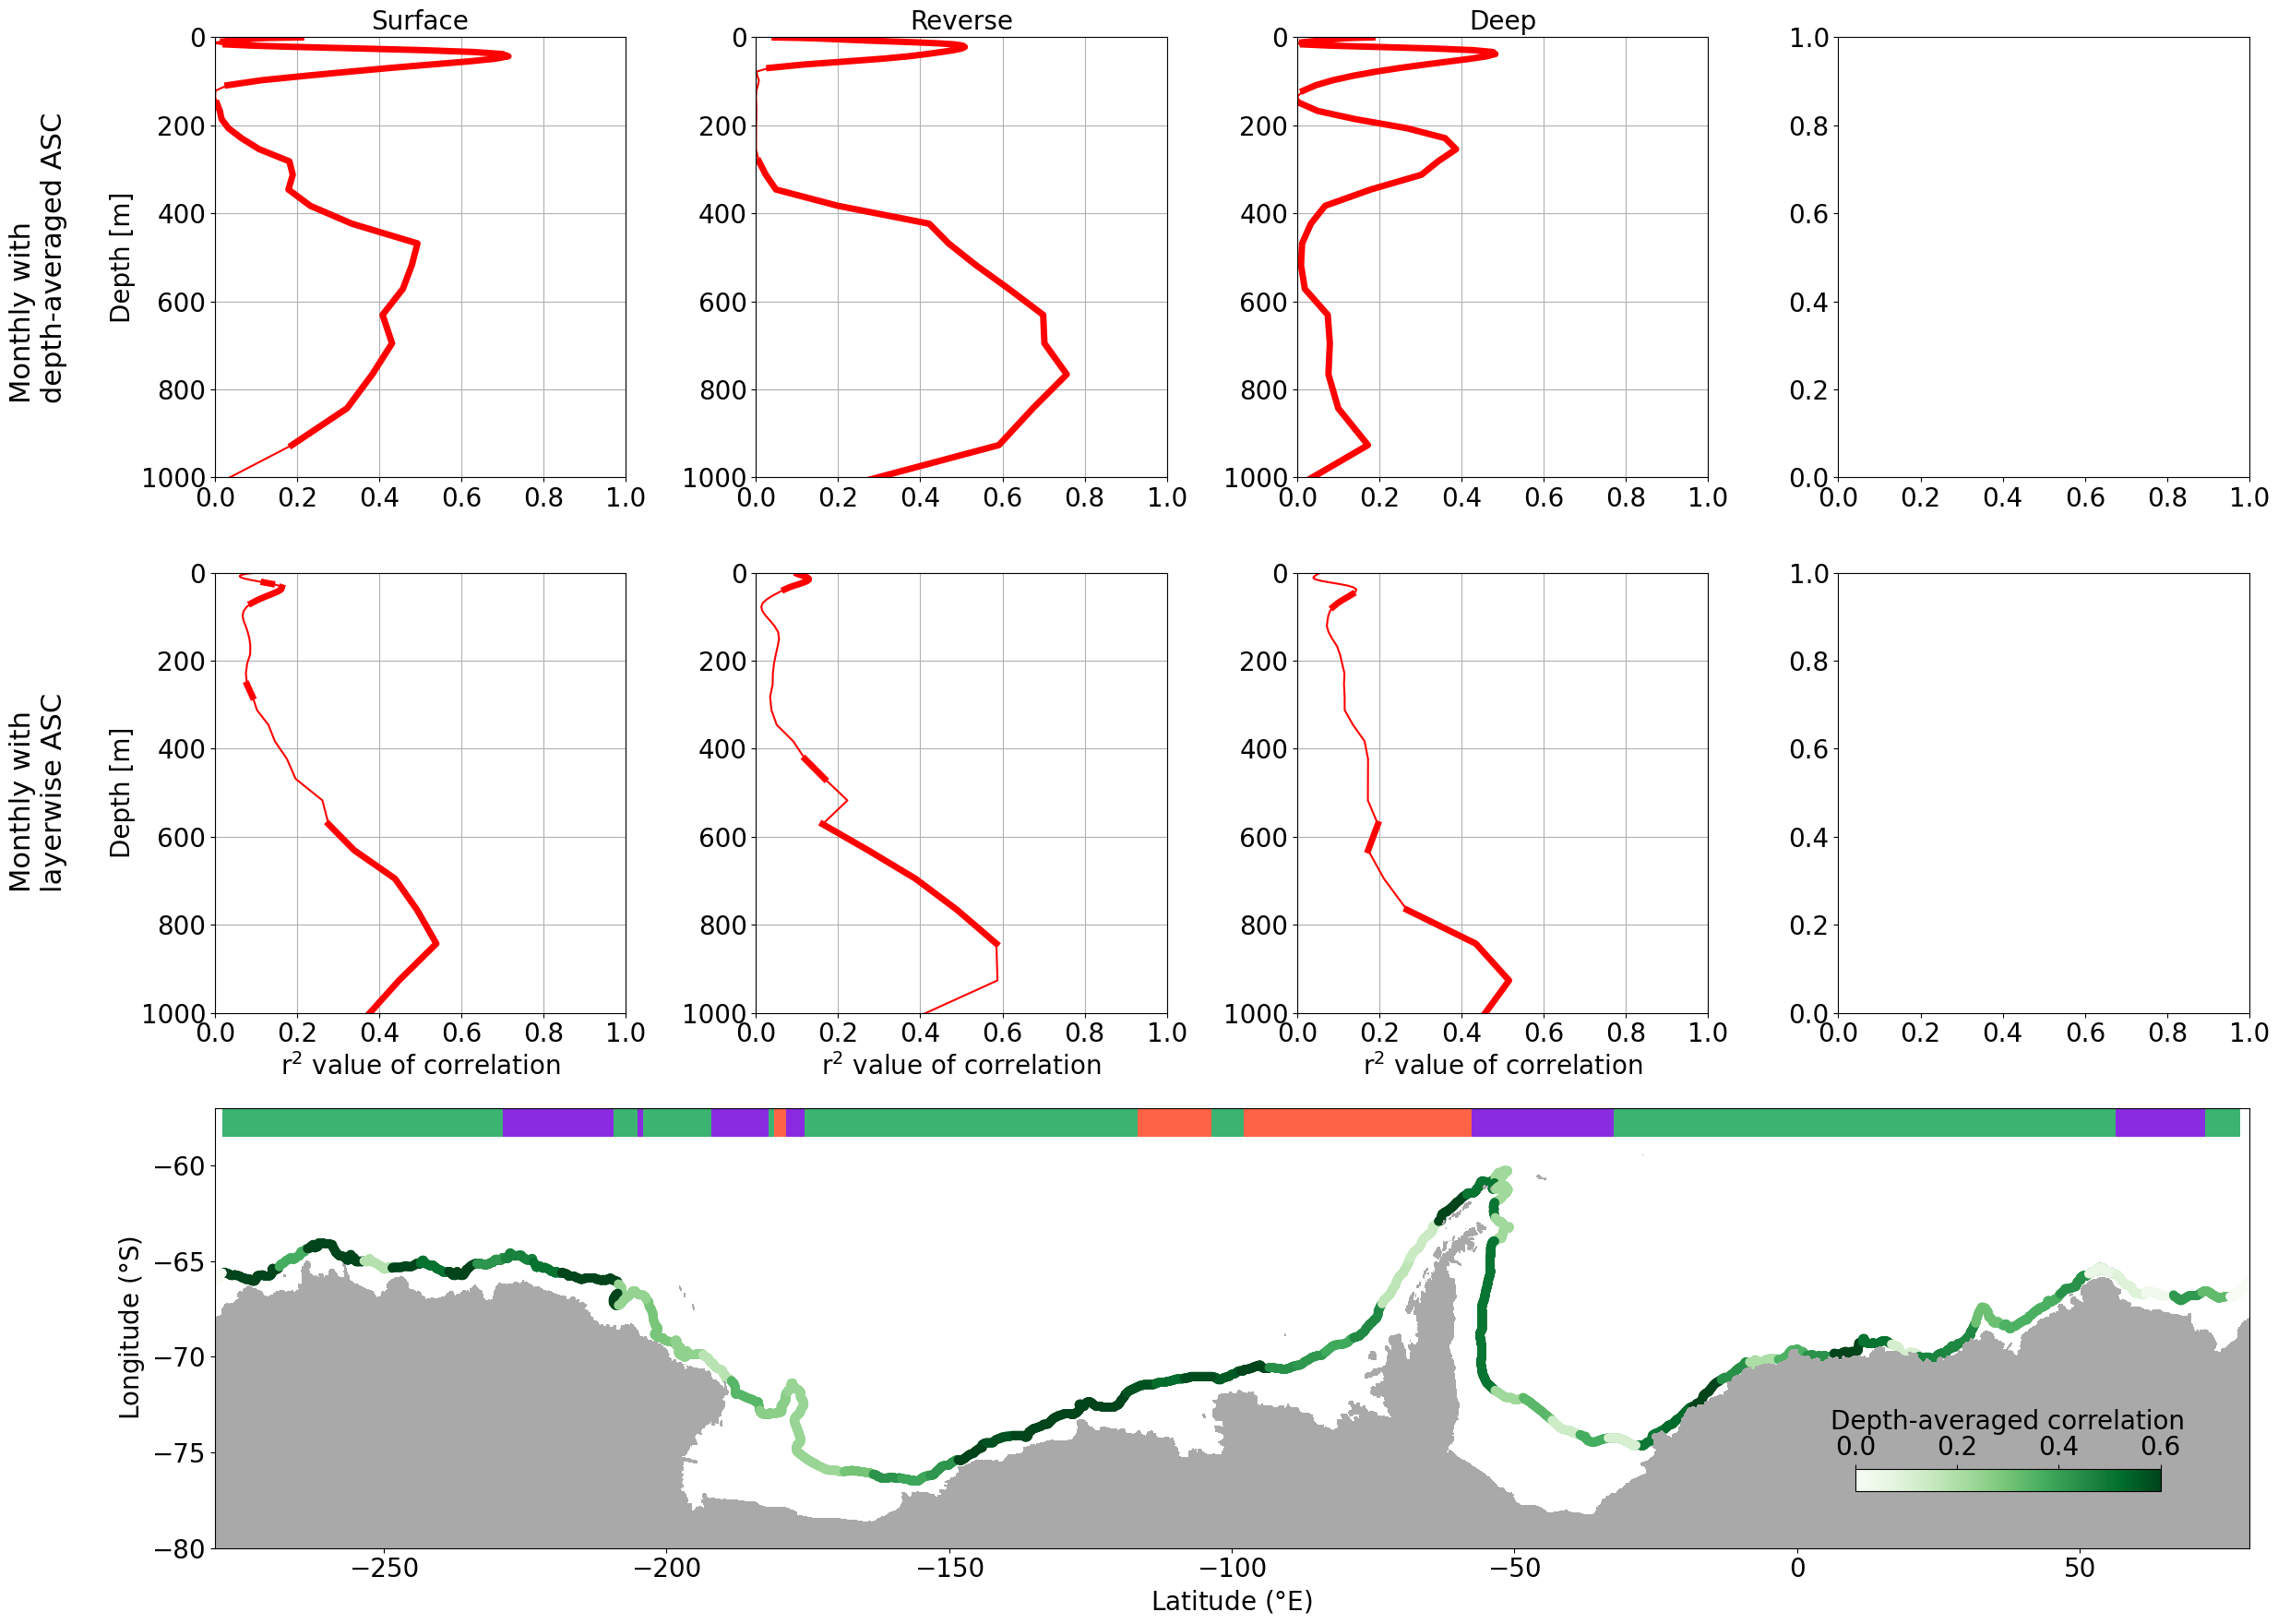

In [31]:
## With changing line thickness past threshold p value
fig =  plt.figure(figsize=(25,18))
plt.subplots_adjust(hspace = 0.2, wspace=0.25)
axs = [plt.subplot(3,4,i) for i in range(1,9)]
thresholdp = 0.95

for i in range(3): # going through regimes in i

    ## r^2 of regimes
    axs[i].set_title(classes[i])
    '''
    ax1 = axs[i].twiny()
    ax2 = axs[i+4].twiny()
    #ax3 = axs[i+6].twiny()
    '''
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(1000,0)
    axs[i+4].set_xlabel('r$^2$ value of correlation')
    axs[i].plot(r_sq_depthav[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    axs[i].plot(np.where(pval_depthav[:,i]>thresholdp,r_sq_depthav[:,i], np.nan), masked_u_along.depth, 'r', label = 'r-squared', lw = 5)

    
    ## using binned correlation
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(binned_corr_av[:,i], binned_corr_av.depth, 'r', label = 'r-squared')
    axs[i+4].plot(np.where(pval_binned_av[:,i]>thresholdp, binned_corr_av[:,i], np.nan), binned_corr_av.depth, 'r', label = 'r-squared', lw =5)
    '''
    ## domain av correlation
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    axs[i+4].plot(np.where(pval_all[:,i]>thresholdp, r_sq_all[:,i], np.nan), masked_u_along.depth, 'r', label = 'r-squared', lw =5)
    '''
    axs[0].set_ylabel('Depth [m]')
    axs[4].set_ylabel('Depth [m]')
    #axs[6].set_ylabel('Depth [m]')

    #axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    #axs[3*i].set_xlim(-1.1,0.1)
    #axs[3*i+1].set_xlim(-2,0.6)
    #axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+4].invert_yaxis()
    axs[i+4].set_ylim(1000,0)
    axs[i+4].grid()
    #axs[i+6].invert_yaxis()
    #axs[i+6].set_ylim(1000,0)
    #axs[i+6].grid()
    #axs[1].legend()

axs[0].text(-0.5,0.5, 'Monthly with \ndepth-averaged ASC',  rotation=90, va= 'center', transform = axs[0].transAxes, fontsize = 22)
axs[4].text(-0.5,0.5, 'Monthly with \nlayerwise ASC', rotation=90, va= 'center', transform = axs[4].transAxes, fontsize = 22)


## Plotting spatial depth-average correlation
ax_cric = plt.subplot(313)
ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 0), cmap = 'Greens', vmin = 0, vmax = 0.6)
ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 1), cmap = 'Greens', vmin = 0, vmax = 0.6)
cmap = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 2), cmap = 'Greens', vmin = 0, vmax = 0.6)
ax_cric.pcolormesh(clustering_mask.lon, [-58,-57],  np.vstack((clustering_mask_sum,clustering_mask_sum)) , cmap=CustomCmap_no3)

axins1 = inset_axes(
    ax_cric,
    width="15%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.8,0.1,1,1),
    bbox_transform=ax_cric.transAxes

)

cb = fig.colorbar(cmap, cax = axins1, orientation = 'horizontal', label = 'Depth-averaged correlation')
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")

ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)')
ax_cric.set_xlabel('Latitude ($\degree$E)')

#ax1.legend(loc=4)
plt.tight_layout()
plt.show()

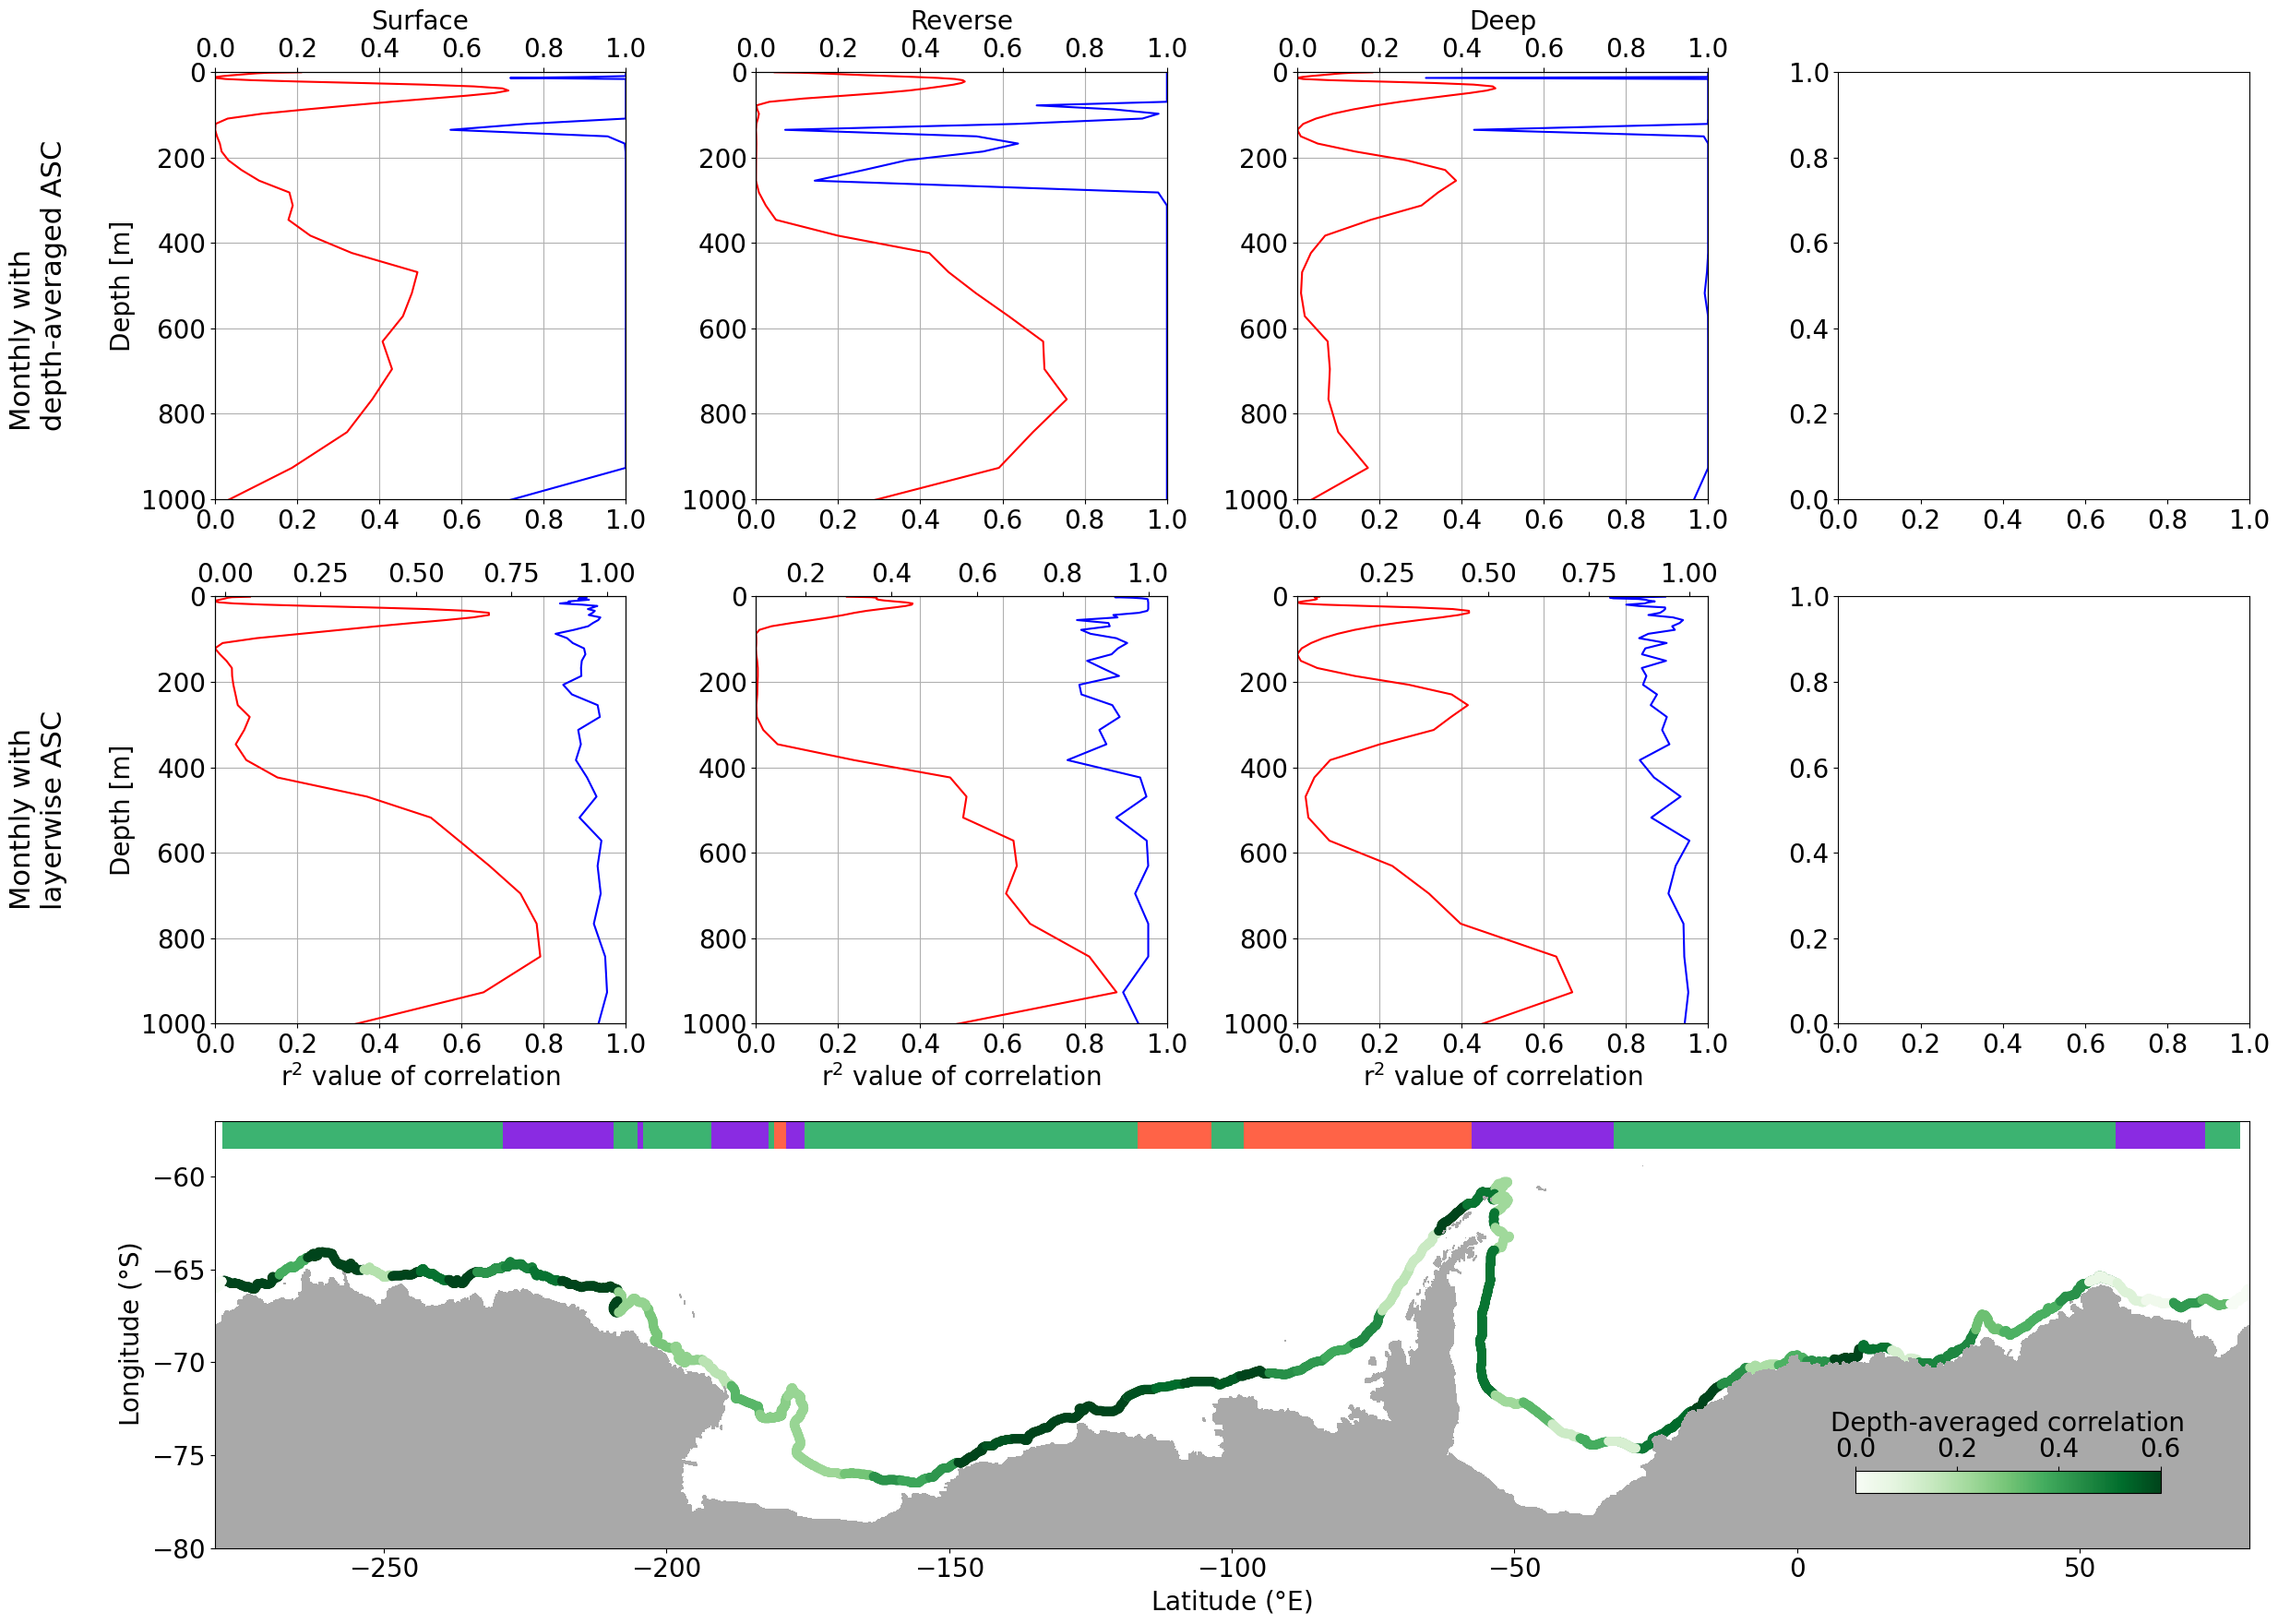

In [32]:
fig =  plt.figure(figsize=(25,18))
plt.subplots_adjust(hspace = 0.2, wspace=0.25)
axs = [plt.subplot(3,4,i) for i in range(1,9)]

for i in range(3): # going through regimes in i

    ## r^2 of regimes
    axs[i].set_title(classes[i])
    '''
    ax1 = axs[i].twiny()
    ax2 = axs[i+4].twiny()
    #ax3 = axs[i+6].twiny()
    '''
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(1000,0)
    axs[i+4].set_xlabel('r$^2$ value of correlation')
    axs[i].plot(r_sq_depthav[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    #ax3.set_xlim(0,1)
    #ax3.set_ylim(1000,0)
    #ax3.plot(r_sq_clima[:,i], masked_u_along.depth, 'r', label = 'r-squared')

    ax1 = axs[i].twiny()
    ax1.plot(pval_depthav[:,i], masked_u_along.depth, 'b', label = 'significance')
    ax1.set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    ax2 = axs[i+4].twiny()
    ax2.plot(pval_binned_av[:,i], binned_corr.depth, 'b', label = 'significance')


    axs[0].set_ylabel('Depth [m]')
    axs[4].set_ylabel('Depth [m]')
    #axs[6].set_ylabel('Depth [m]')

    #axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    #axs[3*i].set_xlim(-1.1,0.1)
    #axs[3*i+1].set_xlim(-2,0.6)
    #axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+4].invert_yaxis()
    axs[i+4].set_ylim(1000,0)
    axs[i+4].grid()
    #axs[i+6].invert_yaxis()
    #axs[i+6].set_ylim(1000,0)
    #axs[i+6].grid()
    #axs[1].legend()

axs[0].text(-0.5,0.5, 'Monthly with \ndepth-averaged ASC',  rotation=90, va= 'center', transform = axs[0].transAxes, fontsize = 22)
axs[4].text(-0.5,0.5, 'Monthly with \nlayerwise ASC', rotation=90, va= 'center', transform = axs[4].transAxes, fontsize = 22)


## Plotting spatial depth-average correlation
ax_cric = plt.subplot(313)
ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 0), cmap = 'Greens', vmin = 0, vmax = 0.6)
ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 1), cmap = 'Greens', vmin = 0, vmax = 0.6)
cmap = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = da_binned_corr_av_ext.isel(regimes = 2), cmap = 'Greens', vmin = 0, vmax = 0.6)
ax_cric.pcolormesh(clustering_mask.lon, [-58,-57],  np.vstack((clustering_mask_sum,clustering_mask_sum)) , cmap=CustomCmap_no3)

axins1 = inset_axes(
    ax_cric,
    width="15%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.8,0.1,1,1),
    bbox_transform=ax_cric.transAxes

)

cb = fig.colorbar(cmap, cax = axins1, orientation = 'horizontal', label = 'Depth-averaged correlation')
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")

ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)')
ax_cric.set_xlabel('Latitude ($\degree$E)')

#ax1.legend(loc=4)
plt.tight_layout()
plt.show()

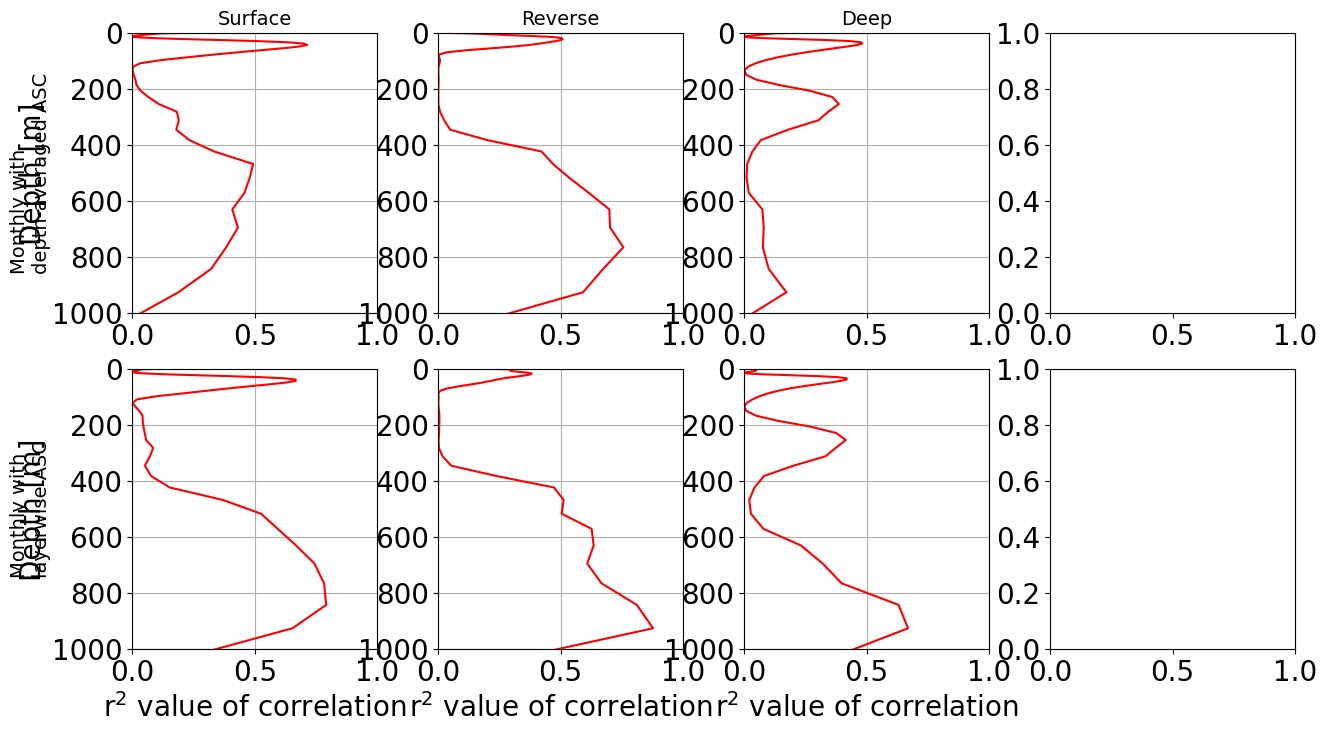

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,8))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

for i in range(3): # going through regimes in i

    axs[i].set_title(classes[i], fontsize=14)
    '''
    ax1 = axs[i].twiny()
    ax2 = axs[i+4].twiny()
    #ax3 = axs[i+6].twiny()
    '''
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(1000,0)
    axs[i+4].set_xlabel('r$^2$ value of correlation')
    axs[i].plot(r_sq_depthav[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    axs[i+4].set_xlim(0,1)
    axs[i+4].set_ylim(1000,0)
    axs[i+4].plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = 'r-squared')
    #ax3.set_xlim(0,1)
    #ax3.set_ylim(1000,0)
    #ax3.plot(r_sq_clima[:,i], masked_u_along.depth, 'r', label = 'r-squared')

    axs[0].set_ylabel('Depth [m]')
    axs[4].set_ylabel('Depth [m]')
    #axs[6].set_ylabel('Depth [m]')

    #axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    #axs[3*i].set_xlim(-1.1,0.1)
    #axs[3*i+1].set_xlim(-2,0.6)
    #axs[3*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+4].invert_yaxis()
    axs[i+4].set_ylim(1000,0)
    axs[i+4].grid()
    #axs[i+6].invert_yaxis()
    #axs[i+6].set_ylim(1000,0)
    #axs[i+6].grid()
    #axs[1].legend()

axs[0].text(-0.5,0.5, 'Monthly with \ndepth-averaged ASC', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[4].text(-0.5,0.5, 'Monthly with \nlayerwise ASC', fontsize = 14, rotation=90, va= 'center', transform = axs[4].transAxes)


#ax1.legend(loc=4)
plt.show()